- Linformer cannot be implemented on Decoder models.
- Multi-ped can be run for longer sequences if we increase the number of peds but performance is not as good as the linformer.
- Attention3D and Attention combined cannot be run for longer sequences.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import contextlib
import io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/BioTransformer/TAPE ')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining the Models

- The goal is to first make sure that the models output all sequences instead of only one output so no collapsing no pooling.
- Then we will need to check the padding and sequence length is it the same for all of the samples?


In [ ]:
### Modify the code for the linear combination of the encoder output
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, p):
        super().__init__()
        self.layer1 = nn.Linear(d_model, d_ff)
        self.layer2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        return self.layer2(self.dropout(self.relu(self.layer1(x))))

class Encoder(nn.Module):
    def __init__(self, p, dim_feedforward, attn_mechanism, **kwargs):
        super().__init__()

        # Extract required arguments from kwargs
        d_model = kwargs["d_model"]
        num_heads = kwargs["num_heads"]
        len_seq = kwargs["len_seq"]
        self.block_size = kwargs.get('block_size', None)
        self.stride = kwargs.get('stride',None)

        # Modify len-seq if padding is required
        if attn_mechanism in {"Attn2DMultiPed3Dselected", "Multiped2D", "MultiLin2D", "Attn3DLinformerMultiPed", "Multiped3D_Dual", "MultiLin3D_Dual", "Attn2DMultiPed3Dselected_Dual"}:
              remainder = (len_seq - self.block_size) % self.stride
              pad_len = (self.stride - remainder) % self.stride
              if pad_len > 0:
                len_seq = len_seq + pad_len
                #print(f'len of seq in enc is changed to {len_seq}')
                kwargs["len_seq"] = len_seq  # Update the value in kwargs  # Update the value in kwargs

        # Initialize attention mechanism
        self.mha = get_attention(attn_mechanism, **kwargs)

        # Feedforward and normalization layers
        self.ffn = FeedForward(d_model, dim_feedforward, p)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p)

    def forward(self, x,mask = None):
        attn_output = self.dropout(self.mha(x,mask))
        x = self.norm1(x + attn_output)
        ffn_output = self.dropout(self.ffn(x))
        x = self.norm2(x + ffn_output)
        return x

class ProteinTransformerSS3(nn.Module):
    def __init__(self, num_classes, vocab_size, num_layers=2, p=0.2, dim_feedforward=32, attn_mechanism="Plain3D", **kwargs):
        super().__init__()
        self.kwargs = kwargs
        d_model = kwargs["d_model"]
        self.attn_mechanism = attn_mechanism
        self.num_classes = num_classes
        len_seq = kwargs["len_seq"]
        self.block_size = kwargs.get('block_size', None)
        self.stride = kwargs.get('stride',None)

        # Encoder and Attention
        self.encoder_layers = nn.ModuleList([
            Encoder(p=p, dim_feedforward=dim_feedforward, attn_mechanism=attn_mechanism, **kwargs)
            for _ in range(num_layers)
        ])

        # Modify the len-seq based on padding required
        if attn_mechanism in {"Attn2DMultiPed3Dselected", "Multiped2D", "MultiLin2D", "Multiped3D", "Attn3DLinformerMultiPed", "Multiped3D_Dual", "MultiLin3D_Dual", "Attn2DMultiPed3Dselected_Dual"}:
          # how much we need to pad
          remainder = (len_seq - self.block_size) % self.stride
          pad_len = (self.stride - remainder) % self.stride
          if pad_len > 0:
            len_seq = len_seq + pad_len
            #print(f'len of seq var in transformer is changed to {len_seq}')
            kwargs["len_seq"] = len_seq  # Update the value in kwargs

        # AA embedding layer
        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # Positional Embeddings
        self.position_embedding = nn.Embedding(len_seq, d_model)

        # Feed Forward Layer
        self.classifier = nn.Linear(d_model, num_classes)

    def sliding_blocks(self, x):
        """
        Args:
            x (Tensor): Input tensor of shape (batch, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (batch, num_blocks, l, d_model).
        """
        l = self.block_size
        d = self.stride
        batch, seq_len = x.shape

        # unfold along the sequence dimension
        blocks = x.unfold(dimension=1, size=l, step=d)   # (batch, num_blocks, l, d_model)

        return blocks

    def generate_padding_mask(self, input_seq):
      seq_len = input_seq.shape[1]
      batch_size = input_seq.shape[0]
      mask = input_seq != 0 # shape = [bs, len_seq]
      # if self.num_peds:
      #   len_ped = seq_len // self.num_peds
      if self.attn_mechanism in {"Multiped3D","Multiped3D_Dual"}:
        return self.sliding_blocks(input_seq !=0).unsqueeze(2).unsqueeze(2).unsqueeze(2)
      elif self.attn_mechanism == "Multiped2D":
        return self.sliding_blocks(input_seq !=0).unsqueeze(2).unsqueeze(2)
      elif self.attn_mechanism == 'Linformer2D':
        return mask.unsqueeze(1).unsqueeze(3)
      elif self.attn_mechanism == 'Plain2D':
        return mask.unsqueeze(1).unsqueeze(1)
      elif self.attn_mechanism == 'Plain3D':
        return mask.unsqueeze(1).unsqueeze(1).unsqueeze(1)
      elif self.attn_mechanism in {'Linformer3D', 'Linformer3D_Dual'}:
        return mask.unsqueeze(1).unsqueeze(3).unsqueeze(3)
      elif self.attn_mechanism == 'MultiLin2D':
        return self.sliding_blocks(input_seq !=0).unsqueeze(2).unsqueeze(4)
      elif self.attn_mechanism in {"Attn3DLinformerMultiPed", "MultiLin3D_Dual"}:
        return self.sliding_blocks(input_seq !=0).unsqueeze(2).unsqueeze(4).unsqueeze(4)
      elif self.attn_mechanism == "Combined2D3D":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3DLin":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d =  mask.unsqueeze(1).unsqueeze(3).unsqueeze(3)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3D_MultiPed":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.reshape(batch_size, self.num_peds, len_ped).unsqueeze(2).unsqueeze(2).unsqueeze(2)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3D_MultiPedLin":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.reshape(batch_size, self.num_peds, len_ped).unsqueeze(2).unsqueeze(4).unsqueeze(4)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3DLinAlter":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.unsqueeze(1).unsqueeze(3).unsqueeze(3)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3D_MultiPedLinAlter":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.reshape(batch_size, self.num_peds, len_ped).unsqueeze(2).unsqueeze(4).unsqueeze(4)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3D_MultiPedAlter":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.reshape(batch_size, self.num_peds, len_ped).unsqueeze(2).unsqueeze(2).unsqueeze(2)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism in {"Attn2DMultiPed3Dselected", "Attn2DMultiPed3Dselected_Dual"}:
        return self.sliding_blocks(input_seq !=0)

    def pad_tensor(self, labels, pad_value, len_seq):
      return torch.nn.functional.pad(labels, (0, len_seq-labels.size(1)), value=pad_value)

    def pad_to_sliding_blocks(self, x, pad_value=0):
        """
        Pad sequence length so it divides evenly into sliding-window blocks.

        Args:
            x (Tensor): (B, L, D) input sequence
            block_size (int): size of each block (l)
            stride (int): sliding window step (d)
            pad_value (float, optional): value to use for padding. Defaults to 0.

        Returns:
            Tensor: padded sequence of shape (B, L', D), where
                    (L' - block_size) % stride == 0
            int: number of padding tokens added
        """
        B, L = x.shape

        # how much we need to pad
        remainder = (L - self.block_size) % self.stride
        pad_len = (self.stride - remainder) % self.stride
        #print(f'pad_len : {pad_len}')
        if pad_len > 0:
            pad_tensor = x.new_full((B, pad_len), pad_value)
            x = torch.cat([x, pad_tensor], dim=1)

        return x

    def forward(self, input_ids, labels):
      B, L = input_ids.shape

      is_multiped = self.attn_mechanism in {"Attn3DLinformerMultiPed", "MultiLin2D", "Attn2D3D_MultiPed", "Attn2D3D_MultiPedLin", "Attn2DMultiPed3Dselected", "Multiped2D", "Multiped3D", "Multiped3D_Dual", "MultiLin3D_Dual", "Attn2DMultiPed3Dselected_Dual"}
      #print(f'is_multiped: {is_multiped}')
      # Add Padding if multiped
      if is_multiped:
        if self.attn_mechanism in {"Attn2DMultiPed3Dselected", "Multiped2D", "MultiLin2D", "Multiped3D", "Attn3DLinformerMultiPed", "Multiped3D_Dual", "MultiLin3D_Dual", "Attn2DMultiPed3Dselected_Dual"}:
          # how much we need to pad
          remainder = (L - self.block_size) % self.stride
          pad_len = (self.stride - remainder) % self.stride
          #print(f'number of pads needed: {pad_len}')
          if pad_len > 0:
            input_ids = F.pad(input_ids, (0, pad_len), value=0)
            # Modify the labels
            L = input_ids.shape[1]
            labels = self.pad_tensor(labels, -100, L)
            #print(f'padding is applied to the input shape: {input_ids.shape}')
            #print(f'padding is applied to the labels shape: {labels.shape}')

        # Create the mask internally
      masks = self.generate_padding_mask(input_ids)
      # Create placeholder for positions in the sequence
      pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)
      # Embedding of AAs + Positional Encoding
      x = self.token_embedding(input_ids) + self.position_embedding(pos_ids)
      for layer in self.encoder_layers:
        x = layer(x, mask=masks)

      return self.classifier(x), labels

### 2D Attention Mechanisms

#### Attention 2D

In [ ]:
class MultiHeadAttn2D(nn.Module):

    def __init__(self,num_heads, d_model):
        super(MultiHeadAttn2D,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Check if the number of len_emb (d_model) is divisable by num_heads
        assert d_model % num_heads == 0, "d_model is not divisable by the number of heads"


    def self_attention(self, q, k, v, mask):

        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(attention_scores,result)

    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        to
        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, _ = q.shape
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, mask=None):
        k = q.clone()
        v = q.clone()

        # Define Query, Key, Value
        Query = self.split_heads(self.W_q(q))
        Key  = self.split_heads(self.W_k(k))
        Value = self.split_heads(self.W_v(v))

        # Run the self-attention
        attention_scores, attn_output = self.self_attention(Query, Key,Value, mask)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_output.shape
        attn_output = attn_output.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)

        return result_final



#### Attention 2D Multi-Ped

In [ ]:
class Attn2D_MultiPed(nn.Module):
    """
    """

    def __init__(self,num_heads, d_model, stride = 10, block_size = 40):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.stride = stride
        self.block_size = block_size

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def self_attention(self, q, k, v, mask):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dot-product: {dotqk.shape}')
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in the new sliding block multiped2d')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def _sliding_blocks(self, x):
        """
        Create sliding-window blocks from the sequence.

        Args:
            x (Tensor): (B, L, D).

        Returns:
            Tensor: (B, num_blocks, block_size, D).
        """
        l = self.block_size
        d = self.stride
        B, L, D = x.shape

        num_blocks = (L - l) // d + 1

        # Compute new shape and strides
        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),        # batch stride
            d * x.stride(1),    # jump d steps for each block
            x.stride(1),        # step 1 inside a block
            x.stride(2),        # feature stride
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """
        Reconstruct sequence from overlapping sliding blocks.

        Args:
            blocks (Tensor): (B, num_blocks, block_size, D).
            seq_len (int): Original sequence length.

        Returns:
            Tensor: (B, seq_len, D).
        """
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape

        device = blocks.device

        # Build index map: (num_blocks, block_size) -> positions in seq_len
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        # Expand to batch and feature dims
        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)

        # Flatten everything for scatter
        flat_pos = positions.reshape(B, -1)  # (B, num_blocks * block_size)
        flat_blocks = blocks.reshape(B, -1, D)  # (B, num_blocks * block_size, D)

        # Allocate output
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        # Scatter add the block values into the right positions
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward(self, q,mask = None):
        k = q.clone()
        v = q.clone()
        # Define Query, Key, Value
        Query = self.split_heads(self._sliding_blocks(self.W_q(q)))
        Key  = self.split_heads(self._sliding_blocks(self.W_k(k)))
        Value = self.split_heads(self._sliding_blocks(self.W_v(v)))

        # Run the self-attention
        attn_output = self.self_attention(Query, Key, Value, mask = mask)
        #print(f'shape of the attn outputs:{attn_output.shape}')

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = self._reconstruct_from_blocks(attn_output, q.shape[1])

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)

        return result_final

#### 2D Attention Linformer

In [ ]:
class Attn2DLinformer(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
    """
    def __init__(self, num_heads, d_model, k, len_seq):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)

    def split_heads(self, x):
        B, L, D = x.size()
        x = x.view(B, L, self.num_heads, self.head_dim)
        return x.transpose(1, 2)  # [B, H, L, D]

    def self_attention(self, q, k, v, mask):

        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_dim**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in the linformer')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)


    def forward(self, q,mask = None):
        k = q.clone()
        v = q.clone()
        Q = self.split_heads(self.W_q(q))

        def project(x, linear_proj, W):
            x = W(x).permute(0, 2, 1)
            x = linear_proj(x).permute(0, 2, 1)
            return self.split_heads(x)

        K = project(k, self.E, self.W_k)
        V = project(v, self.F, self.W_v)

        attn_out = self.self_attention(Q, K, V, mask)

        B, H, L, D = attn_out.shape
        concat = attn_out.transpose(1, 2).contiguous().view(B, L, self.d_model)
        return self.W_o(concat)

#### 2D Linformer + Multi-Ped

In [ ]:
class Attn2DLinformerMultiPed(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
        first multi-ped then linformer attention
    """
    def __init__(self, num_heads, d_model, k, len_seq, num_peds):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(len_seq//num_peds, k)
        self.F = nn.Linear(len_seq//num_peds, k)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_dim).transpose(2,3)

    def self_attention(self, q, k, v, mask= None):

        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_dim**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            print(f'mask in implemented')
            print(f'shape of the mask implemented: {mask.shape}')
            print(f'shape of the attn: {dotqk.shape}')

        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def split_sequence(self, q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, seq_len, d_model = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        return q.reshape(samples, self.num_peds, seq_len // self.num_peds, d_model)


    def forward(self, q,mask = None):
        k = q.clone()
        v = q.clone()
        Q = self.split_heads(self.split_sequence(self.W_q(q)))

        def project(x, linear_proj, W):
            '''
            Expected input shape: ([batch_size, len_seq, d_model])

            '''
            x = self.split_sequence(W(x)) #shape: ([batch_size, num_peds, len_ped, d_model])
            x = x.permute(0, 1, 3, 2) #shape: ([batch_size, num_peds, d_model, len_ped])
            #print(f'linear proj: {linear_proj}, shape of x: {x.shape}')
            x = linear_proj(x) # shape: torch.Size([batch_size, num_peds, d_model, k])
            x = x.permute(0, 1, 3, 2) # shape: torch.Size([batch_size, num_peds, k, d_model])
            return self.split_heads((x)) # shape: torch.Size([batch_size, num_peds, num_heads, k , head_dim])

        K = project(k, self.E, self.W_k)
        V = project(v, self.F, self.W_v)

        attn_output = self.self_attention(Q, K, V,mask = mask)

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = attn_output.contiguous().view(batch_size, len_ped * num_peds, self.d_model)
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

In [ ]:
class Attn2DLinformerMultiPed(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
        first multi-ped then linformer attention
    """
    def __init__(self, num_heads, d_model, k, len_seq, stride, block_size):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.stride = stride
        self.block_size = block_size

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(block_size, k)
        self.F = nn.Linear(block_size, k)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_dim).transpose(2,3)

    def self_attention(self, q, k, v, mask):

        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_dim**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk: {dotqk.shape}')
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def _sliding_blocks(self, x):
        """
        Create sliding-window blocks from the sequence.

        Args:
            x (Tensor): (B, L, D).

        Returns:
            Tensor: (B, num_blocks, block_size, D).
        """
        l = self.block_size
        d = self.stride
        B, L, D = x.shape

        num_blocks = (L - l) // d + 1

        # Compute new shape and strides
        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),        # batch stride
            d * x.stride(1),    # jump d steps for each block
            x.stride(1),        # step 1 inside a block
            x.stride(2),        # feature stride
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """
        Reconstruct sequence from overlapping sliding blocks.

        Args:
            blocks (Tensor): (B, num_blocks, block_size, D).
            seq_len (int): Original sequence length.

        Returns:
            Tensor: (B, seq_len, D).
        """
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape

        device = blocks.device

        # Build index map: (num_blocks, block_size) -> positions in seq_len
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        # Expand to batch and feature dims
        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)

        # Flatten everything for scatter
        flat_pos = positions.reshape(B, -1)  # (B, num_blocks * block_size)
        flat_blocks = blocks.reshape(B, -1, D)  # (B, num_blocks * block_size, D)

        # Allocate output
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        # Scatter add the block values into the right positions
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward(self, q,mask = None):
        k = q.clone()
        v = q.clone()
        Q = self.split_heads(self._sliding_blocks(self.W_q(q)))
        #print(f'shape of query: {Q.shape}')

        def project(x, linear_proj, W):
            '''
            Expected input shape: ([batch_size, len_seq, d_model])

            '''
            x = self._sliding_blocks(W(x)) #shape: ([batch_size, num_peds, len_ped, d_model])
            x = x.permute(0, 1, 3, 2) #shape: ([batch_size, num_peds, d_model, len_ped])
            #print(f'linear proj: {linear_proj}, shape of x permuted: {x.shape}')
            x = linear_proj(x) # shape: torch.Size([batch_size, num_peds, d_model, k])
            x = x.permute(0, 1, 3, 2) # shape: torch.Size([batch_size, num_peds, k, d_model])
            return self.split_heads((x)) # shape: torch.Size([batch_size, num_peds, num_heads, k , head_dim])

        K = project(k, self.E, self.W_k)
        #print(f'shape of key lin: {K.shape}')
        V = project(v, self.F, self.W_v)

        attn_output = self.self_attention(Q, K, V,mask)

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = self._reconstruct_from_blocks(attn_output, q.shape[1])
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

### 3D Attention Mechanisms

#### Combined 2D+ 3D Attention

In [ ]:
class Attn_2D3DC(nn.Module):
    """
    """

    def __init__(self,num_heads, d_model):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

    def self_attention1(self, q, k, v, mask= None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention2(self, q, k,l, v,mask= None):
        # Save the length of the sequence
        #seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abid,abjd,abkd -> abijk', q, k, l) /(self.head_params**0.5) # Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask received: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate the V^2 matrix
        vtilde = torch.einsum('abcd,abed->abced', v, v)
        # Multiply 3D attention with V^2
        result = torch.einsum('abijk,abjkl->abil', attention_scores, vtilde)
        return(result)

    def combined_attention(self, q, k,l, v, masks):
      """
      This is combining the original attention with the modified attention.
      mask1 is the mask with the original dimensions
      mask2 is the mask with the modified dimensions
      """
      mask2d, mask3d = masks
      result1_attention = self.self_attention1(q, k, v, mask2d)
      result2_attention = self.self_attention2(q, k,l, v, mask3d)

      return(self.norm1(result1_attention)+self.norm2(result2_attention)) #combined normalized results


    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        to
        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, masks = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()

        # Define Query, Key, Value
        Query = self.split_heads(self.W_q(q))
        Key  = self.split_heads(self.W_k(k))
        L_matrix = self.split_heads(self.W_l(l))
        Value = self.split_heads(self.W_v(v))

        # Run the self-attention
        attn_outputs_combined = self.combined_attention(Query, Key,L_matrix, Value, masks)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Combined 2D + Linformer 3D

In [ ]:
class Attn2D3DLin(nn.Module):

    """
    Combined 2D and 3D Linformer Attention
    """

    def __init__(self,num_heads, d_model, k, len_seq):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Linformer Projections
        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

    def self_attention2D(self, q, k, v, mask= None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3DLin(self, q, k, l, v, mask = None):
        # Compute trilinear attention scores
        scores = torch.einsum('bhid,bhjd,bhkd->bhijk', q, k, l) / (self.head_params ** 0.5)
        #print(f'shape of scores: {scores.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            scores = scores.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 3D attn')
        attn_weights = softmax_5d(scores, axis=(-1, -2))

        v_3d = torch.einsum('bhld,bhLd->bhlLd', v, v)  # Could be simplified
        output = torch.einsum('bhijk,bhjkl->bhil', attn_weights, v_3d)
        return output


    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, mask = None):
        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()

        # Unwarp the masks
        mask2D = mask[0]
        mask3D = mask[1]

        # Query will be the same for both attentions
        Q = self.split_heads(self.W_q(q))

        # Define Key and Value for 2D Attention
        K_2D  = self.split_heads(self.W_k(k))
        V_2D = self.split_heads(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Q, K_2D, V_2D, mask2D)

        def project(x, linear_proj, W):
          x = W(x).permute(0, 2, 1)
          x = linear_proj(x).permute(0, 2, 1)
          return self.split_heads(x)

        # Define the Query, Key, Utinity and Value matrices for Linformer 3D
        K_Lin = project(k, self.E, self.W_k)
        L_Lin = project(l, self.F, self.W_l)
        V_Lin = project(v, self.G, self.W_v)

        # Run Linformer 3D attention
        attn_outputs_3DLin= self.self_attention3DLin(Q, K_Lin, L_Lin, V_Lin, mask3D)

        # Combine the attentions
        attn_outputs_combined = self.norm1(attn_outputs_2D) + self.norm2(attn_outputs_3DLin)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Alternate Combined 2D + 3D Linformer

In [ ]:
class Attn2D3DLinAlter(nn.Module):

    """
    Combined 2D and 3D Linformer Attention
    """

    def __init__(self,num_heads, d_model, k, len_seq):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Linformer Projections
        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

        self.linear = nn.Linear(2*self.head_params,self.head_params)

    def self_attention2D(self, q, k, v, mask= None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk 2D: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3DLin(self, q, k, l, v, mask = None):
        # Compute trilinear attention scores
        scores = torch.einsum('bhid,bhjd,bhkd->bhijk', q, k, l) / (self.head_params ** 0.5)
        #print(f'shape of scores Linformer: {scores.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            scores = scores.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 3D attn')
        attn_weights = softmax_5d(scores, axis=(-1, -2))

        v_3d = torch.einsum('bhld,bhLd->bhlLd', v, v)  # Could be simplified
        output = torch.einsum('bhijk,bhjkl->bhil', attn_weights, v_3d)
        return output


    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, mask = None):
        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()

        # Unwarp the masks
        mask2D = mask[0]
        mask3D = mask[1]

        # Query will be the same for both attentions
        Q = self.split_heads(self.W_q(q))

        # Define Key and Value for 2D Attention
        K_2D  = self.split_heads(self.W_k(k))
        V_2D = self.split_heads(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Q, K_2D, V_2D, mask2D)

        def project(x, linear_proj, W):
          x = W(x).permute(0, 2, 1)
          x = linear_proj(x).permute(0, 2, 1)
          return self.split_heads(x)

        # Define the Query, Key, Utinity and Value matrices for Linformer 3D
        K_Lin = project(k, self.E, self.W_k)
        L_Lin = project(l, self.F, self.W_l)
        V_Lin = project(v, self.G, self.W_v)

        # Run Linformer 3D attention
        attn_outputs_3DLin= self.self_attention3DLin(Q, K_Lin, L_Lin, V_Lin, mask3D)

        # Concatenate the two attentions
        combined_attention = torch.cat((attn_outputs_2D, attn_outputs_3DLin), dim=-1)
        #print(f'shape of combined attention before linear: {combined_attention.shape}')
        combined_attention = self.linear(combined_attention)
        #print(f'shape of combined attention after linear: {combined_attention.shape}')

        # Concatenate the heads
        batch_size, _,seq_len, _= combined_attention.shape
        combined_attention = combined_attention.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(combined_attention) #shape = (#samples, len_seq, d_model)

        return result_final

#### Combined 2D and 3D Multiped Alternative

In [ ]:
class Attn2D3D_MultiPedAlter(nn.Module):

    """
    Combined 2D and 3D Multi-Ped Attention
    """

    def __init__(self,num_heads, d_model, num_peds):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)


        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

        self.linear = nn.Linear(2*self.head_params,self.head_params)

    def self_attention2D(self, q, k, v, mask = None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk in 2D : {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3DMultiPed(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl in 3D MultiPed: {mul_qkl.shape}')
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 3D attn')
            #print(f'mask applied to 3D multiped; shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads2D(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)


    def split_sequence(self, q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, seq_len, d_model = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, seq_len // self.num_peds, d_model)

    def split_heads3D(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def forward(self, q, mask = None):
        #print(f'combined 2D and 3D multiped is activated')

        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()

        mask_2D = None
        mask_3DMP = None

        # Unpack the masks
        if mask is not None:
          mask_2D = mask[0]
          #print(f'mask_2D{mask_2D}, shape = {mask_2D.shape}')
          mask_3DMP = mask[1]
          #print(f'mask_3DMP{mask_3DMP}, shape = {mask_3DMP.shape}')

        Query_2D = self.split_heads2D(self.W_q(q))
        Key_2D  = self.split_heads2D(self.W_k(k))
        Value_2D = self.split_heads2D(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Query_2D, Key_2D, Value_2D, mask = mask_2D) # (batch_size, num_heads, len_seq, head_params)

        # Define the Query, Key, Utinity and Value matrices for Multi-Ped 3D
        Query_3D = self.split_heads3D(self.split_sequence(self.W_q(q)))
        Key_3D  = self.split_heads3D(self.split_sequence(self.W_k(k)))
        Value_3D = self.split_heads3D(self.split_sequence(self.W_v(v)))
        L_matrix = self.split_heads3D(self.split_sequence(self.W_l(l)))

        # Run MultiPed 3D attention
        attn_outputs_3DMultiPed= self.self_attention3DMultiPed(Query_3D, Key_3D, L_matrix, Value_3D, mask = mask_3DMP) # (batch_size, num_peds, num_heads, len_ped, head_params)
        #print(f'shape of attention 2D output: {attn_outputs_3DMultiPed.shape}')

        # Combine the peds
        batch_size, num_peds, num_heads, len_ped ,len_head = attn_outputs_3DMultiPed.shape
        attn_outputs_3DMultiPed = attn_outputs_3DMultiPed.contiguous().view(batch_size, num_heads, num_peds*len_ped, len_head)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_3DMultiPed.shape}')
        # Concatenate the output of the attentions
        attn_outputs_concat = torch.cat((attn_outputs_2D, attn_outputs_3DMultiPed), dim=-1)
        #print(f'shape of attns concatednate : {attn_outputs_concat.shape}')

        # Combine the attentions
        attn_outputs_combined = self.linear(attn_outputs_concat)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_combined.shape}')

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Combined 2D + Multi-Ped 3D (global 2D + Local 3D)

In [ ]:
class Attn2D3D_MultiPed(nn.Module):

    """
    Combined 2D and 3D Multi-Ped Attention
    """

    def __init__(self,num_heads, d_model, num_peds):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)


        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

    def self_attention2D(self, q, k, v, mask = None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk in 2D : {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3DMultiPed(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl in 3D MultiPed: {mul_qkl.shape}')
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 3D attn')
            #print(f'mask applied to 3D multiped; shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads2D(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)


    def split_sequence(self, q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, seq_len, d_model = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, seq_len // self.num_peds, d_model)

    def split_heads3D(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def forward(self, q, mask = None):
        #print(f'combined 2D and 3D multiped is activated')

        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()

        mask_2D = None
        mask_3DMP = None

        # Unpack the masks
        if mask is not None:
          mask_2D = mask[0]
          #print(f'mask_2D{mask_2D}, shape = {mask_2D.shape}')
          mask_3DMP = mask[1]
          #print(f'mask_3DMP{mask_3DMP}, shape = {mask_3DMP.shape}')

        Query_2D = self.split_heads2D(self.W_q(q))
        Key_2D  = self.split_heads2D(self.W_k(k))
        Value_2D = self.split_heads2D(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Query_2D, Key_2D, Value_2D, mask = mask_2D) # (batch_size, num_heads, len_seq, head_params)

        # Define the Query, Key, Utinity and Value matrices for Multi-Ped 3D
        Query_3D = self.split_heads3D(self.split_sequence(self.W_q(q)))
        Key_3D  = self.split_heads3D(self.split_sequence(self.W_k(k)))
        Value_3D = self.split_heads3D(self.split_sequence(self.W_v(v)))
        L_matrix = self.split_heads3D(self.split_sequence(self.W_l(l)))

        # Run MultiPed 3D attention
        attn_outputs_3DMultiPed= self.self_attention3DMultiPed(Query_3D, Key_3D, L_matrix, Value_3D, mask = mask_3DMP) # (batch_size, num_peds, num_heads, len_ped, head_params)
        #print(f'shape of attention 2D output: {attn_outputs_3DMultiPed.shape}')

        # Combine the peds
        batch_size, num_peds, num_heads, len_ped ,len_head = attn_outputs_3DMultiPed.shape
        attn_outputs_3DMultiPed = attn_outputs_3DMultiPed.contiguous().view(batch_size, num_heads, num_peds*len_ped, len_head)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_3DMultiPed.shape}')

        # Combine the attentions
        attn_outputs_combined = self.norm1(attn_outputs_2D) + self.norm2(attn_outputs_3DMultiPed)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Dual 3D Attns

In [ ]:
class Attn3D_MultiPed_Dual(nn.Module):
    """
    Multi-ped 3D Attention with two parallel attention modules
    whose outputs are summed together.
    """

    def __init__(self, num_heads, d_model, block_size, stride):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model // num_heads
        self.block_size = block_size
        self.stride = stride

        # First attention set
        self.W_q1 = nn.Linear(d_model, d_model)
        self.W_k1 = nn.Linear(d_model, d_model)
        self.W_l1 = nn.Linear(d_model, d_model)
        self.W_v1 = nn.Linear(d_model, d_model)
        self.W_o1 = nn.Linear(d_model, d_model)

        # Second attention set
        self.W_q2 = nn.Linear(d_model, d_model)
        self.W_k2 = nn.Linear(d_model, d_model)
        self.W_l2 = nn.Linear(d_model, d_model)
        self.W_v2 = nn.Linear(d_model, d_model)
        self.W_o2 = nn.Linear(d_model, d_model)

    def self_attention(self, q, k, l, v, mask=None):
        mul_qkl = torch.einsum(
            'abcid,abcjd,abckd -> abcijk', q, k, l
        ) / (self.head_params ** 0.5)

        if mask is not None:
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)

        attention_scores = softmax_5d(mul_qkl, axis=(-1, -2))

        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        return result

    def split_heads(self, x):
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2, 3)

    def _sliding_blocks(self, x):
        l = self.block_size
        d = self.stride
        B, L, D = x.shape
        num_blocks = (L - l) // d + 1

        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),
            d * x.stride(1),
            x.stride(1),
            x.stride(2),
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape
        device = blocks.device

        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)
        flat_pos = positions.reshape(B, -1)
        flat_blocks = blocks.reshape(B, -1, D)

        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def _run_attention_set(self, q, W_q, W_k, W_l, W_v, W_o, mask=None):
        k = q.clone()
        l = q.clone()
        v = q.clone()

        Query = self.split_heads(self._sliding_blocks(W_q(q)))
        Key = self.split_heads(self._sliding_blocks(W_k(k)))
        L_matrix = self.split_heads(self._sliding_blocks(W_l(l)))
        Value = self.split_heads(self._sliding_blocks(W_v(v)))

        attn_output = self.self_attention(Query, Key, L_matrix, Value, mask=mask)

        batch_size, num_peds, num_heads, len_ped, len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)

        len_seq = q.shape[1]
        attn_output = self._reconstruct_from_blocks(attn_output, len_seq)

        return W_o(attn_output)

    def forward(self, q, mask=None):
        # Run first attention set
        out1 = self._run_attention_set(q, self.W_q1, self.W_k1, self.W_l1, self.W_v1, self.W_o1, mask)

        # Run second attention set
        out2 = self._run_attention_set(q, self.W_q2, self.W_k2, self.W_l2, self.W_v2, self.W_o2, mask)

        # Add results
        return out1 + out2


In [ ]:
class Attn3DLinformer_Dual(nn.Module):
    """
    Dual Attention 3D Linformer:
    Runs two independent attention mechanisms (with separate weights)
    and sums their outputs.
    """
    def __init__(self, num_heads, d_model, k, len_seq):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        # First attention weights
        self.W_q1 = nn.Linear(d_model, d_model)
        self.W_k1 = nn.Linear(d_model, d_model)
        self.W_l1 = nn.Linear(d_model, d_model)
        self.W_v1 = nn.Linear(d_model, d_model)
        self.W_o1 = nn.Linear(d_model, d_model)

        self.E1 = nn.Linear(len_seq, k)
        self.F1 = nn.Linear(len_seq, k)
        self.G1 = nn.Linear(len_seq, k)

        # Second attention weights
        self.W_q2 = nn.Linear(d_model, d_model)
        self.W_k2 = nn.Linear(d_model, d_model)
        self.W_l2 = nn.Linear(d_model, d_model)
        self.W_v2 = nn.Linear(d_model, d_model)
        self.W_o2 = nn.Linear(d_model, d_model)

        self.E2 = nn.Linear(len_seq, k)
        self.F2 = nn.Linear(len_seq, k)
        self.G2 = nn.Linear(len_seq, k)

    def split_heads(self, x):
        B, L, D = x.size()
        x = x.view(B, L, self.num_heads, self.head_dim)
        return x.transpose(1, 2)  # [B, H, L, D]

    def self_attention(self, q, k, l, v, mask):
        scores = torch.einsum('bhid,bhjd,bhkd->bhijk', q, k, l) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn_weights = softmax_5d(scores, axis=(-1, -2))

        v_3d = torch.einsum('bhld,bhLd->bhlLd', v, v)
        output = torch.einsum('bhijk,bhjkl->bhil', attn_weights, v_3d)
        return output

    def forward_path(self, q, k, l, v, W_q, W_k, W_l, W_v, W_o, E, F, G, mask):
        Q = self.split_heads(W_q(q))

        def project(x, linear_proj, W):
            x = W(x).permute(0, 2, 1)
            x = linear_proj(x).permute(0, 2, 1)
            return self.split_heads(x)

        K = project(k, E, W_k)
        L = project(l, F, W_l)
        V = project(v, G, W_v)

        attn_out = self.self_attention(Q, K, L, V, mask)
        B, H, L_seq, D = attn_out.shape
        concat = attn_out.transpose(1, 2).contiguous().view(B, L_seq, self.d_model)
        return W_o(concat)

    def forward(self, q, mask=None):
        k, l, v = q.clone(), q.clone(), q.clone()

        out1 = self.forward_path(q, k, l, v, self.W_q1, self.W_k1, self.W_l1, self.W_v1, self.W_o1, self.E1, self.F1, self.G1, mask)
        out2 = self.forward_path(q, k, l, v, self.W_q2, self.W_k2, self.W_l2, self.W_v2, self.W_o2, self.E2, self.F2, self.G2, mask)

        return out1 + out2


In [ ]:
class Attn3DLinformerMultiPed_Dual(nn.Module):
    """
    Dual Attention version of MultiPed + Linformer 3D attention.
    Runs two independent attention mechanisms (with separate weights)
    and sums their outputs.
    """
    def __init__(self, num_heads, d_model, k, len_seq, block_size, stride):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.block_size = block_size
        self.stride = stride

        # First attention weights
        self.W_q1 = nn.Linear(d_model, d_model)
        self.W_k1 = nn.Linear(d_model, d_model)
        self.W_l1 = nn.Linear(d_model, d_model)
        self.W_v1 = nn.Linear(d_model, d_model)
        self.W_o1 = nn.Linear(d_model, d_model)

        self.E1 = nn.Linear(block_size, k)
        self.F1 = nn.Linear(block_size, k)
        self.G1 = nn.Linear(block_size, k)

        # Second attention weights
        self.W_q2 = nn.Linear(d_model, d_model)
        self.W_k2 = nn.Linear(d_model, d_model)
        self.W_l2 = nn.Linear(d_model, d_model)
        self.W_v2 = nn.Linear(d_model, d_model)
        self.W_o2 = nn.Linear(d_model, d_model)

        self.E2 = nn.Linear(block_size, k)
        self.F2 = nn.Linear(block_size, k)
        self.G2 = nn.Linear(block_size, k)

    def split_heads(self, x):
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_dim).transpose(2, 3)

    def self_attention(self, q, k, l, v, mask=None):
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_dim**0.5)
        if mask is not None:
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
        attention_scores = softmax_5d(mul_qkl, axis=(-1, -2))
        vtilde = torch.einsum('abcid,abcjd->abcijd', v, v)
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        return result

    def _sliding_blocks(self, x):
        l = self.block_size
        d = self.stride
        B, L, D = x.shape
        num_blocks = (L - l) // d + 1
        shape = (B, num_blocks, l, D)
        strides = (x.stride(0), d * x.stride(1), x.stride(1), x.stride(2))
        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape
        device = blocks.device

        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]
        positions = positions.unsqueeze(0).expand(B, -1, -1)

        flat_pos = positions.reshape(B, -1)
        flat_blocks = blocks.reshape(B, -1, D)

        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward_path(self, q, W_q, W_k, W_l, W_v, W_o, E, F, G, mask):
        k, l, v = q.clone(), q.clone(), q.clone()
        Q = self.split_heads(self._sliding_blocks(W_q(q)))

        def project(x, linear_proj, W):
            x = self._sliding_blocks(W(x))
            x = x.permute(0, 1, 3, 2)
            x = linear_proj(x)
            x = x.permute(0, 1, 3, 2)
            return self.split_heads(x)

        K = project(k, E, W_k)
        L = project(l, F, W_l)
        V = project(v, G, W_v)

        attn_output = self.self_attention(Q, K, L, V, mask)
        batch_size, num_peds, num_heads, len_ped, len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        attn_output = self._reconstruct_from_blocks(attn_output, q.shape[1])
        return W_o(attn_output)

    def forward(self, q, mask=None):
        out1 = self.forward_path(q, self.W_q1, self.W_k1, self.W_l1, self.W_v1, self.W_o1, self.E1, self.F1, self.G1, mask)
        out2 = self.forward_path(q, self.W_q2, self.W_k2, self.W_l2, self.W_v2, self.W_o2, self.E2, self.F2, self.G2, mask)
        return out1 + out2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attn2DMultiPed3Dselected_Dual(nn.Module):
    """
    Two completely separate Attention Mechanisms with 2D and selected 3D interactions.
    Each branch has its own Q, K, V, L projections.
    The outputs of the two branches are added together.
    """
    def __init__(self, num_heads: int, d_model: int, stride: int = 10, block_size: int = 40, k=4, k_prime=2):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.stride = stride
        self.block_size = block_size
        self.k = k
        self.k_prime = k_prime

        # Branch 1 projections
        self.W_q1 = nn.Linear(d_model, d_model)
        self.W_k1 = nn.Linear(d_model, d_model)
        self.W_v1 = nn.Linear(d_model, d_model)
        self.W_l1 = nn.Linear(d_model, d_model)

        # Branch 2 projections
        self.W_q2 = nn.Linear(d_model, d_model)
        self.W_k2 = nn.Linear(d_model, d_model)
        self.W_v2 = nn.Linear(d_model, d_model)
        self.W_l2 = nn.Linear(d_model, d_model)

        # Output projection (shared after adding the two branches)
        self.W_o = nn.Linear(d_model, d_model)

        # Fusion layer (per-branch fusion of 2D and 3D outputs)
        self.fusion_layer = nn.Linear(2 * self.head_dim, self.head_dim)

    #### Helper functions (same as before) ####
    def _split_heads(self, x):
        B, Blk, L, D = x.size()
        return x.view(B, Blk, L, self.num_heads, self.head_dim).transpose(2, 3)

    def _sliding_blocks(self, x):
        l, d = self.block_size, self.stride
        B, L, D = x.shape
        num_blocks = (L - l) // d + 1
        shape = (B, num_blocks, l, D)
        strides = (x.stride(0), d * x.stride(1), x.stride(1), x.stride(2))
        return x.as_strided(shape, strides).contiguous()

    def _topk_submats_adv(self, attn_scores: torch.Tensor, topk_idx: torch.Tensor):
        B, Blk, H, L, _ = attn_scores.shape
        K = topk_idx.shape[-1]
        device = attn_scores.device
        topk_idx = topk_idx.long().to(device)

        # Select rows
        b = torch.arange(B, device=device)[:, None, None, None, None].expand(B, Blk, H, L, K)
        bl = torch.arange(Blk, device=device)[None, :, None, None, None].expand(B, Blk, H, L, K)
        h = torch.arange(H, device=device)[None, None, :, None, None].expand(B, Blk, H, L, K)
        q = torch.arange(L, device=device)[None, None, None, :, None].expand(B, Blk, H, L, K)
        row_selected = attn_scores[b, bl, h, topk_idx, :]  # (B, Blk, H, L, K, L)

        # Select cols
        b2 = torch.arange(B, device=device)[:, None, None, None, None, None].expand(B, Blk, H, L, K, K)
        bl2 = torch.arange(Blk, device=device)[None, :, None, None, None, None].expand(B, Blk, H, L, K, K)
        h2 = torch.arange(H, device=device)[None, None, :, None, None, None].expand(B, Blk, H, L, K, K)
        q2 = torch.arange(L, device=device)[None, None, None, :, None, None].expand(B, Blk, H, L, K, K)
        cols = topk_idx.unsqueeze(-2).expand(B, Blk, H, L, K, K)

        sub = row_selected[b2, bl2, h2, q2, torch.arange(K, device=device)[None, None, None, None, :, None], cols]
        return sub

    def _reconstruct_from_blocks(self, blocks, seq_len):
        l, d = self.block_size, self.stride
        B, num_blocks, _, D = blocks.shape
        device = blocks.device
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = (start_idx[:, None] + block_offsets).unsqueeze(0).expand(B, -1, -1)
        flat_pos, flat_blocks = positions.reshape(B, -1), blocks.reshape(B, -1, D)
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())
        return out / counts

    def _gather_partners(self, tensor, partner_idx):
        return torch.gather(tensor, 4, partner_idx.unsqueeze(-1).expand(*partner_idx.shape, self.head_dim))

    def _self_attention_2d(self, q, k, v, mask=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(2).unsqueeze(4) == 0, -1e9)
        attn_scores = torch.softmax(scores, dim=-1)
        return attn_scores, torch.matmul(attn_scores, v)

    def compute_selected_mask(self, mask, partner1, partner2, L):
        if mask is None:
            return None
        mask_reshaped1 = mask.unsqueeze(2).expand(-1, -1, self.num_heads, -1)
        mask_reshaped2 = mask_reshaped1.unsqueeze(-2).expand(-1, -1, -1, L, -1)
        mask1_comp = torch.gather(mask_reshaped2, 4, partner1)
        mask2_comp = torch.gather(mask_reshaped2, 4, partner2)
        two_way_interac_mask = mask1_comp * mask2_comp
        mask_comp3 = mask_reshaped1.unsqueeze(-1).expand(-1, -1, -1, -1, partner1.size(-1))
        return mask_comp3 * two_way_interac_mask

    #### Branch-specific computation ####
    def _branch_attention(self, Q, Key, V, L_mat, mask):
        attn_scores, attn_out_2d = self._self_attention_2d(Q, Key, V, mask=mask)

        topk_scores, topk_idx = torch.topk(attn_scores, self.k, dim=-1)
        outer = topk_scores[..., :, None] * topk_scores[..., None, :]
        selected = self._topk_submats_adv(attn_scores, topk_idx)
        res = outer * selected
        B, Blk, H, L, K, _ = res.shape
        _, topk_exp = torch.topk(res.view(B, Blk, H, L, -1), self.k_prime, dim=-1)
        row_idx, col_idx = topk_exp // self.k, topk_exp % self.k_prime
        partner1, partner2 = torch.gather(topk_idx, -1, row_idx), torch.gather(topk_idx, -1, col_idx)

        K_exp = Key.unsqueeze(-3).expand(-1, -1, -1, L, -1, -1)
        L_exp = L_mat.unsqueeze(-3).expand(-1, -1, -1, L, -1, -1)
        V_exp = V.unsqueeze(-3).expand(-1, -1, -1, L, -1, -1)

        k_sel = self._gather_partners(K_exp, partner1)
        l_sel = self._gather_partners(L_exp, partner2)
        v1 = self._gather_partners(V_exp, partner1)
        v2 = self._gather_partners(V_exp, partner2)

        q_exp = Q.unsqueeze(-2)
        dot_qkl = (q_exp * k_sel * l_sel).sum(-1)
        final_mask = self.compute_selected_mask(mask, partner1, partner2, L)
        if final_mask is not None:
            dot_qkl = dot_qkl.masked_fill(final_mask == 0, -1e9)

        attn_weights_3d = torch.softmax(dot_qkl, dim=-1)
        v_sq = v1 * v2
        dot_qkl_exp = attn_weights_3d.unsqueeze(-1).expand(-1, -1, -1, -1, -1, self.head_dim)
        res_3d = (dot_qkl_exp * v_sq).sum(-2)

        res_combined = torch.cat([attn_out_2d, res_3d], dim=-1)
        return self.fusion_layer(res_combined)

    #### Forward ####
    def forward(self, x, mask=None):
        B, L, D = x.shape

        # Branch 1
        q1, k1, v1, l1 = self.W_q1(x), self.W_k1(x), self.W_v1(x), self.W_l1(x)
        Q1, K1, V1, L1 = map(lambda t: self._split_heads(self._sliding_blocks(t)), (q1, k1, v1, l1))
        out1 = self._branch_attention(Q1, K1, V1, L1, mask)

        # Branch 2
        q2, k2, v2, l2 = self.W_q2(x), self.W_k2(x), self.W_v2(x), self.W_l2(x)
        Q2, K2, V2, L2 = map(lambda t: self._split_heads(self._sliding_blocks(t)), (q2, k2, v2, l2))
        out2 = self._branch_attention(Q2, K2, V2, L2, mask)

        # Add branches
        summed = out1 + out2
        B, Blk, H, L_blk, hd = summed.shape
        out = summed.transpose(2, 3).contiguous().view(B, Blk, L_blk, self.d_model)

        # Reconstruct and project
        recon = self._reconstruct_from_blocks(out, x.shape[1])
        return self.W_o(recon)


#### Combined 2D with 3D MultiPed Linformer

In [ ]:
class Attn2D3D_MultiPedLin(nn.Module):

    """
    Combined 2D and 3D Multi-Ped Attention
    """

    def __init__(self,num_heads, d_model, num_peds, len_seq, k):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Linformer Projections
        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

    def self_attention2D(self, q, k, v, mask = None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk 2D Attn: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
            #print(f'mask applied to 2D attention. Shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3D(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied to 3D multiped Linformer; shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)


    def split_sequence(self,q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, num_heads, seq_len, head_params = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, num_heads, seq_len // self.num_peds, head_params)


    def forward(self, q, mask = None):
        #print(f'combined 2D and 3D multiped is activated')

        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()
        mask_2D = None
        mask_3DMP = None

        # Unpack the masks
        if mask is not None:
          mask_2D = mask[0]
          #print(f'mask_2D{mask_2D}, shape = {mask_2D.shape}')
          mask_3DMP = mask[1]
          #print(f'mask_3DMP{mask_3DMP}, shape = {mask_3DMP.shape}')

        Query_2D = self.split_heads(self.W_q(q))
        Key_2D  = self.split_heads(self.W_k(k))
        Value_2D = self.split_heads(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Query_2D, Key_2D, Value_2D, mask = mask_2D) # (batch_size, num_heads, len_seq, head_params)

        # Define the Query, Key, Utinity and Value matrices for Multi-Ped 3D
        Query_3D = self.split_sequence(Query_2D)
        Key_3D  = self.split_sequence(Key_2D)
        Value_3D = self.split_sequence(Value_2D)
        L_matrix = self.split_sequence(self.split_heads(self.W_l(l)))

        # Run MultiPed 3D attention
        attn_outputs_3DMultiPed= self.self_attention3D(Query_3D, Key_3D, L_matrix, Value_3D, mask = mask_3DMP) # (batch_size, num_peds, num_heads, len_ped, head_params)
        #print(f'shape of attention 2D output: {attn_outputs_3DMultiPed.shape}')

        # Combine the peds
        batch_size, num_peds, num_heads, len_ped ,len_head = attn_outputs_3DMultiPed.shape
        attn_outputs_3DMultiPed = attn_outputs_3DMultiPed.contiguous().view(batch_size, num_heads, num_peds*len_ped, len_head)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_3DMultiPed.shape}')

        # Combine the attentions
        attn_outputs_combined = self.norm1(attn_outputs_2D) + self.norm2(attn_outputs_3DMultiPed)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Combined 2D with 3D Multi-Ped Linformer

In [ ]:
class Attn2D3D_MultiPedLinAlter(nn.Module):

    """
    Combined 2D and 3D Multi-Ped Attention
    """

    def __init__(self,num_heads, d_model, num_peds, len_seq, k):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Linformer Projections
        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

        self.linear = nn.Linear(2*self.head_params, self.head_params)

    def self_attention2D(self, q, k, v, mask = None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk 2D Attn: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
            #print(f'mask applied to 2D attention. Shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3D(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied to 3D multiped Linformer; shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)


    def split_sequence(self,q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, num_heads, seq_len, head_params = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, num_heads, seq_len // self.num_peds, head_params)


    def forward(self, q, mask = None):
        #print(f'combined 2D and 3D multiped is activated')

        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()
        mask_2D = None
        mask_3DMP = None

        # Unpack the masks
        if mask is not None:
          mask_2D = mask[0]
          #print(f'mask_2D{mask_2D}, shape = {mask_2D.shape}')
          mask_3DMP = mask[1]
          #print(f'mask_3DMP{mask_3DMP}, shape = {mask_3DMP.shape}')

        Query_2D = self.split_heads(self.W_q(q))
        Key_2D  = self.split_heads(self.W_k(k))
        Value_2D = self.split_heads(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Query_2D, Key_2D, Value_2D, mask = mask_2D) # (batch_size, num_heads, len_seq, head_params)

        # Define the Query, Key, Utinity and Value matrices for Multi-Ped 3D
        Query_3D = self.split_sequence(Query_2D)
        Key_3D  = self.split_sequence(Key_2D)
        Value_3D = self.split_sequence(Value_2D)
        L_matrix = self.split_sequence(self.split_heads(self.W_l(l)))

        # Run MultiPed 3D attention
        attn_outputs_3DMultiPed= self.self_attention3D(Query_3D, Key_3D, L_matrix, Value_3D, mask = mask_3DMP) # (batch_size, num_peds, num_heads, len_ped, head_params)
        #print(f'shape of attention 2D output: {attn_outputs_3DMultiPed.shape}')

        # Combine the peds
        batch_size, num_peds, num_heads, len_ped ,len_head = attn_outputs_3DMultiPed.shape
        attn_outputs_3DMultiPed = attn_outputs_3DMultiPed.contiguous().view(batch_size, num_heads, num_peds*len_ped, len_head)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_3DMultiPed.shape}')

        # Concatenate the attentions
        attn_outputs_concat = torch.cat((attn_outputs_2D, attn_outputs_3DMultiPed), dim = -1)

        # Combine the attentions
        attn_outputs_combined = self.linear(attn_outputs_concat)
        print(f'shape of attn_outputs_combined: {attn_outputs_combined.shape}')

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Attention 2D overlapping blocks and 3D selected

In [ ]:
class Attn2DMultiPed3Dselected(nn.Module):
    """
  Attention Mechanism with 2D and selected 3D interactions.
    """

    def __init__(self, num_heads: int, d_model: int, stride: int = 10, block_size: int = 40, k=4, k_prime=2):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.stride = stride
        self.block_size = block_size
        self.k = k
        self.k_prime = k_prime

        # Projection layers
        self.W_q, self.W_k, self.W_v, self.W_o, self.W_l = [nn.Linear(d_model, d_model) for _ in range(5)]

        # Fusion layer for combining 2D & 3D attention
        self.fusion_layer = nn.Linear(2 * self.head_dim, self.head_dim)

    #### Helper functions

    def _split_heads(self, x):
        """Split embeddings into multiple heads."""
        B, Blk, L, D = x.size()
        return x.view(B, Blk, L, self.num_heads, self.head_dim).transpose(2, 3)

    def _sliding_blocks(self, x):
        """Create sliding-window blocks from the sequence."""
        l, d, (B, L, D) = self.block_size, self.stride, x.shape
        num_blocks = (L - l) // d + 1
        shape = (B, num_blocks, l, D)
        strides = (x.stride(0), d * x.stride(1), x.stride(1), x.stride(2))
        return x.as_strided(shape, strides).contiguous()

    def _topk_submats_adv(self, attn_scores: torch.Tensor, topk_idx: torch.Tensor):
        """
        Extract submatrices of attention for top-k indices.

        Args:
            attn_scores (Tensor): (B, Blk, H, L, L).
            topk_idx (Tensor): (B, Blk, H, L, K).

        Returns:
            Tensor: (B, Blk, H, L, K, K).
        """
        B, Blk, H, L, _ = attn_scores.shape
        K = topk_idx.shape[-1]
        device = attn_scores.device
        topk_idx = topk_idx.long().to(device)

        # Select rows
        b = torch.arange(B, device=device)[:, None, None, None, None].expand(B, Blk, H, L, K)
        bl = torch.arange(Blk, device=device)[None, :, None, None, None].expand(B, Blk, H, L, K)
        h = torch.arange(H, device=device)[None, None, :, None, None].expand(B, Blk, H, L, K)
        q = torch.arange(L, device=device)[None, None, None, :, None].expand(B, Blk, H, L, K)

        row_selected = attn_scores[b, bl, h, topk_idx, :]  # (B, Blk, H, L, K, L)

        # Select cols
        b2 = torch.arange(B, device=device)[:, None, None, None, None, None].expand(B, Blk, H, L, K, K)
        bl2 = torch.arange(Blk, device=device)[None, :, None, None, None, None].expand(B, Blk, H, L, K, K)
        h2 = torch.arange(H, device=device)[None, None, :, None, None, None].expand(B, Blk, H, L, K, K)
        q2 = torch.arange(L, device=device)[None, None, None, :, None, None].expand(B, Blk, H, L, K, K)

        cols = topk_idx.unsqueeze(-2).expand(B, Blk, H, L, K, K)
        sub = row_selected[b2, bl2, h2, q2, torch.arange(K, device=device)[None, None, None, None, :, None], cols]
        return sub

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """Reconstruct sequence from overlapping sliding blocks."""
        l, d, (B, num_blocks, _, D) = self.block_size, self.stride, blocks.shape
        device = blocks.device
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = (start_idx[:, None] + block_offsets).unsqueeze(0).expand(B, -1, -1)
        flat_pos, flat_blocks = positions.reshape(B, -1), blocks.reshape(B, -1, D)
        out, counts = torch.zeros(B, seq_len, D, device=device), torch.zeros(B, seq_len, 1, device=device)
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())
        return out / counts

    def _expand_for_gather(self, tensor, expand_dims, expand_sizes):
        """Utility for repeated unsqueeze + expand before gather."""
        for axis, size in zip(expand_dims, expand_sizes):
            tensor = tensor.unsqueeze(axis).expand(*size)
        return tensor

    def _gather_partners(self, tensor, partner_idx):
        """Helper for gathering partner-specific selections (K, L, or V)."""
        return torch.gather(tensor, 4, partner_idx.unsqueeze(-1).expand(*partner_idx.shape, self.head_dim))

    def _self_attention_2d(self, q, k, v, mask=None):
        """Standard scaled dot-product attention (2D)."""
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(2).unsqueeze(4) == 0, -1e9)
        attn_scores = torch.softmax(scores, dim=-1)
        return attn_scores, torch.matmul(attn_scores, v)

    def compute_selected_mask(self, mask, partner1, partner2, L):
        """Compute the final interaction mask for 3D attention."""
        if mask is None:
            return None
        mask_reshaped1 = mask.unsqueeze(2).expand(-1, -1, self.num_heads, -1)
        mask_reshaped2 = mask_reshaped1.unsqueeze(-2).expand(-1, -1, -1, L, -1)
        mask1_comp, mask2_comp = torch.gather(mask_reshaped2, 4, partner1), torch.gather(mask_reshaped2, 4, partner2)
        two_way_interac_mask = mask1_comp * mask2_comp
        mask_comp3 = mask_reshaped1.unsqueeze(-1).expand(-1, -1, -1, -1, partner1.size(-1))
        return mask_comp3 * two_way_interac_mask

    ####

    def forward(self, x, mask=None):
        """Forward pass through Multi-Ped Attention."""
        #print(f'shape of x inputted: {x.shape}')
        q, k, v, l = self.W_q(x), self.W_k(x), self.W_v(x), self.W_l(x)
        Q, Key, V, L_mat = map(lambda t: self._split_heads(self._sliding_blocks(t)), (q, k, v, l))

        # 2D Attention
        attn_scores, attn_out_2d = self._self_attention_2d(Q, Key, V, mask=mask)

        # Top-k selection
        topk_scores, topk_idx = torch.topk(attn_scores, self.k, dim=-1)
        outer = topk_scores[..., :, None] * topk_scores[..., None, :]
        selected = self._topk_submats_adv(attn_scores, topk_idx)
        res = outer * selected
        B, Blk, H, L, K, _ = res.shape
        _, topk_exp = torch.topk(res.view(B, Blk, H, L, -1), self.k_prime, dim=-1)
        row_idx, col_idx = topk_exp // self.k, topk_exp % self.k_prime
        partner1, partner2 = torch.gather(topk_idx, -1, row_idx), torch.gather(topk_idx, -1, col_idx)

        # 3D Attention
        K_exp, L_exp, V_exp = (Key, L_mat, V)
        K_exp, L_exp, V_exp = (t.unsqueeze(-3).expand(-1, -1, -1, L, -1, -1) for t in (K_exp, L_exp, V_exp))
        k_sel, l_sel, v1, v2 = (self._gather_partners(K_exp, partner1),
                                self._gather_partners(L_exp, partner2),
                                self._gather_partners(V_exp, partner1),
                                self._gather_partners(V_exp, partner2))
        q_exp = Q.unsqueeze(-2)
        dot_qkl = (q_exp * k_sel * l_sel).sum(-1)
        # print(f'shape of dotqkl: {dot_qkl.shape}')
        final_mask = self.compute_selected_mask(mask, partner1, partner2, L)
        if final_mask is not None:
            dot_qkl = dot_qkl.masked_fill(final_mask == 0, -1e9)
            # print(f'shape of mask: {final_mask.shape}')
        attn_weights_3d = torch.softmax(dot_qkl, dim=-1)

        # Apply to values
        v_sq, dot_qkl_exp = v1 * v2, attn_weights_3d.unsqueeze(-1).expand(-1, -1, -1, -1, -1, self.head_dim)
        res_3d = (dot_qkl_exp * v_sq).sum(-2)

        # Fusion
        res_combined = torch.cat([attn_out_2d, res_3d], dim=-1)
        out = self.fusion_layer(res_combined).view(B, Blk, L, self.d_model)

        # Reconstruct from blocks
        return self.W_o(self._reconstruct_from_blocks(out, x.shape[1]))


#### 3D Attention with Multi-Ped

In [ ]:
class Attn3D_MultiPed(nn.Module):
    """
    num_peds defaults to 10

    """

    def __init__(self,num_heads, d_model, num_peds):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def self_attention(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'mask given to Multi3D: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9) ######changed
            #print(f'mask applied')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)


    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def split_sequence(self, q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, seq_len, d_model = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, seq_len // self.num_peds, d_model)


    def forward(self, q,mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()
        #print(f'Multi-Ped is activated')
        # Define Query, Key, Value
        Query = self.split_heads(self.split_sequence(self.W_q(q)))
        Key  = self.split_heads(self.split_sequence(self.W_k(k)))
        L_matrix = self.split_heads(self.split_sequence(self.W_l(l)))
        Value = self.split_heads(self.split_sequence(self.W_v(v)))
        #print(f'shape of Query: {Query.shape}')
        #print(f'shape of Key: {Key.shape}')
        #print(f'shape of Value: {Value.shape}')

        # Run the self-attention
        attn_output = self.self_attention(Query, Key,L_matrix, Value, mask = mask)
        #print(f'shape of the attn outputs received:{attn_output.shape}')

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = attn_output.contiguous().view(batch_size, len_ped * num_peds, self.d_model)
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

In [ ]:
class Attn3D_MultiPed(nn.Module):
    """


    """

    def __init__(self,num_heads, d_model, block_size, stride):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.block_size = block_size
        self.stride = stride

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def self_attention(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9) ######changed
            #print(f'mask applied in the sliding blocks Multiped 3D')
            #print(f'shape of mask applied: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def _sliding_blocks(self, x):
        """
        Create sliding-window blocks from the sequence.

        Args:
            x (Tensor): (B, L, D).

        Returns:
            Tensor: (B, num_blocks, block_size, D).
        """
        l = self.block_size
        d = self.stride
        B, L, D = x.shape

        num_blocks = (L - l) // d + 1

        # Compute new shape and strides
        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),        # batch stride
            d * x.stride(1),    # jump d steps for each block
            x.stride(1),        # step 1 inside a block
            x.stride(2),        # feature stride
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """
        Reconstruct sequence from overlapping sliding blocks.

        Args:
            blocks (Tensor): (B, num_blocks, block_size, D).
            seq_len (int): Original sequence length.

        Returns:
            Tensor: (B, seq_len, D).
        """
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape

        device = blocks.device

        # Build index map: (num_blocks, block_size) -> positions in seq_len
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        # Expand to batch and feature dims
        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)

        # Flatten everything for scatter
        flat_pos = positions.reshape(B, -1)  # (B, num_blocks * block_size)
        flat_blocks = blocks.reshape(B, -1, D)  # (B, num_blocks * block_size, D)

        # Allocate output
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        # Scatter add the block values into the right positions
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward(self, q,mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()
        # Define Query, Key, Value
        Query = self.split_heads(self._sliding_blocks(self.W_q(q)))
        Key  = self.split_heads(self._sliding_blocks(self.W_k(k)))
        L_matrix = self.split_heads(self._sliding_blocks(self.W_l(l)))
        Value = self.split_heads(self._sliding_blocks(self.W_v(v)))
        #print(f'shape of Query: {Query.shape}')
        #print(f'shape of Key: {Key.shape}')
        #print(f'shape of Value: {Value.shape}')

        # Run the self-attention
        attn_output = self.self_attention(Query, Key,L_matrix, Value, mask = mask)
        #print(f'shape of the attn outputs received:{attn_output.shape}')

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        len_seq = q.shape[1]
        attn_output = self._reconstruct_from_blocks(attn_output,len_seq)
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

#### 3D Linformer Attention

In [ ]:
class Attn3DLinformer(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
    """
    def __init__(self, num_heads, d_model, k, len_seq):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

    def split_heads(self, x):
        B, L, D = x.size()
        x = x.view(B, L, self.num_heads, self.head_dim)
        return x.transpose(1, 2)  # [B, H, L, D]

    def self_attention(self, q, k, l, v,mask=None):
        # Compute trilinear attention scores
        scores = torch.einsum('bhid,bhjd,bhkd->bhijk', q, k, l) / (self.head_dim ** 0.5)
        if mask is not None:
            #print(f'shape of mask given Linformer3D : {mask.shape}')
            scores = scores.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in linformer 3d')

        attn_weights = softmax_5d(scores, axis=(-1, -2))

        v_3d = torch.einsum('bhld,bhLd->bhlLd', v, v)  # Could be simplified
        output = torch.einsum('bhijk,bhjkl->bhil', attn_weights, v_3d)

        return output

    def forward(self, q,mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()
        Q = self.split_heads(self.W_q(q))

        def project(x, linear_proj, W):
            x = W(x).permute(0, 2, 1)
            x = linear_proj(x).permute(0, 2, 1)
            return self.split_heads(x)

        K = project(k, self.E, self.W_k)
        L = project(l, self.F, self.W_l)
        V = project(v, self.G, self.W_v)

        attn_out = self.self_attention(Q, K, L, V,mask)

        B, H, L, D = attn_out.shape
        concat = attn_out.transpose(1, 2).contiguous().view(B, L, self.d_model)
        return self.W_o(concat)

#### Multi-ped + Linformer 3D Attention

In [ ]:
class Attn3DLinformerMultiPed(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
        first multi-ped then linformer attention
    """
    def __init__(self, num_heads, d_model, k, len_seq, block_size, stride):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.block_size = block_size
        self.stride = stride

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(block_size, k)
        self.F = nn.Linear(block_size, k)
        self.G = nn.Linear(block_size, k)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_dim).transpose(2,3)

    def self_attention(self, q, k,l, v, mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_dim**0.5)# Shape: (#samples,num_heads,len_seq,k, k)
        #print(f'shape of the attention scores: {mul_qkl.shape}')
        if mask is not None:
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask is implemented in MultiLin3D')
            #print(f'shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcid,abcjd->abcijd', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def _sliding_blocks(self, x):
        """
        Create sliding-window blocks from the sequence.

        Args:
            x (Tensor): (B, L, D).

        Returns:
            Tensor: (B, num_blocks, block_size, D).
        """
        l = self.block_size
        d = self.stride
        B, L, D = x.shape

        num_blocks = (L - l) // d + 1

        # Compute new shape and strides
        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),        # batch stride
            d * x.stride(1),    # jump d steps for each block
            x.stride(1),        # step 1 inside a block
            x.stride(2),        # feature stride
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """
        Reconstruct sequence from overlapping sliding blocks.

        Args:
            blocks (Tensor): (B, num_blocks, block_size, D).
            seq_len (int): Original sequence length.

        Returns:
            Tensor: (B, seq_len, D).
        """
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape

        device = blocks.device

        # Build index map: (num_blocks, block_size) -> positions in seq_len
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        # Expand to batch and feature dims
        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)

        # Flatten everything for scatter
        flat_pos = positions.reshape(B, -1)  # (B, num_blocks * block_size)
        flat_blocks = blocks.reshape(B, -1, D)  # (B, num_blocks * block_size, D)

        # Allocate output
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        # Scatter add the block values into the right positions
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward(self, q,mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()
        Q = self.split_heads(self._sliding_blocks(self.W_q(q)))
        #print(f'shape of Q: {Q.shape}')

        def project(x, linear_proj, W):
            '''
            Expected input shape: ([batch_size, len_seq, d_model])

            '''
            x = self._sliding_blocks(W(x)) #shape: ([batch_size, num_peds, len_ped, d_model])
            x = x.permute(0, 1, 3, 2) #shape: ([batch_size, num_peds, d_model, len_ped])
            x = linear_proj(x) # shape: torch.Size([batch_size, num_peds, d_model, k])
            x = x.permute(0, 1, 3, 2) # shape: torch.Size([batch_size, num_peds, k, d_model])
            return self.split_heads((x)) # shape: torch.Size([batch_size, num_peds, num_heads, k , head_dim])

        K = project(k, self.E, self.W_k)
        #print(f'shape of K: {K.shape}')
        L = project(l, self.F, self.W_l)
        V = project(v, self.G, self.W_v)

        attn_output = self.self_attention(Q, K, L, V,mask)

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = self._reconstruct_from_blocks(attn_output, q.shape[1])
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

#### Plain 3D Attention

In [ ]:
class MultiHeadAttnMod3D(nn.Module):
    """
    Encoder Attention:
    Input is mapped to Query, Key, and L-matrix, each matrix is (d_model x d_model).
    Query, Key, and L-matrix are multiplied to get a len_seq x len_seq x len_seq matrix:
        - shows correlation between 3 elements.
    Softmax is taken across the last two dimensions (defined by 5D Softmax)
    Value is calculated by multiplying input sequence by another matrix of d_model x d_model -> dim = len_seq x d_model
    Attention scores after softmax are multiplied by Value
            -> (#samples, num_heads, head_param, head_param, head_param) x (//, //, len_seq, head_param)
            = (//,//, len_seq, head_param)
    mask: padding mask


    Decoder Attention
    Decoder input mapped to Query
    Encoder output mapped to Key, L-matrix and Value
    mask: look-ahead mask and the padding mask
    """

    def __init__(self,num_heads, d_model):
        super(MultiHeadAttnMod3D,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Check if the number of len_emb (d_model) is divisable by num_heads
        assert d_model % num_heads == 0, "d_model is not divisable by the number of heads"


    def self_attention(self, q, k,l, v, mask):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K ## multiplication occurs across the last dim (embedding dim)
        mul_qkl = torch.einsum('abcd,abed,abfd -> abcef', q, k, l) /(self.head_params**0.5) # Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'mask shape 3D attn : {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            print(f'mask applied in 3d plain')

        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Multiply v by v -> Dim = NxNxd
        v_3d = torch.einsum('shld, shLd -> shlLd', v,v) # shape: torch.Size([#samples, #heads, len_seq, len_seq, d_model/#heads])
        # Multiply to the value matrix
        result = torch.einsum('shijk,shjkl->shil', attention_scores, v_3d)
        #return(attention_scores,result)
        return(result)

    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        to
        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, _ = q.shape
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()

        # Define Query, Key, Value
        Query = self.split_heads(self.W_q(q))
        Key  = self.split_heads(self.W_k(k))
        L_matrix = self.split_heads(self.W_l(l))
        Value = self.split_heads(self.W_v(v))

        # Run the self-attention
        attn_output = self.self_attention(Query, Key,L_matrix, Value, mask)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_output.shape
        attn_output = attn_output.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)

        return result_final

In [ ]:
def get_attention(attn_type, **kwargs):
  """
  Attention options include:
  - Plain2D
  - Linformer2D
  - Multiped2D

  - Plain3D
  - Linformer3D
  - Multiped3D
  - Combined3D
  - Attn3DLinformerMultiPed

  Combined2D3D
  Combined2D3DLinformer
  Combined2D3DMultiPed
  Combined2D3DMultiPedLinformer

  """
  if attn_type == "Plain3D":
      print(f'Plain3D is activated')
      return MultiHeadAttnMod3D(d_model=kwargs["d_model"], num_heads=kwargs["num_heads"])
  elif attn_type == "Linformer3D":
      print(f'Linformer3D is activated')
      return Attn3DLinformer(num_heads = kwargs['num_heads'], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Combined2D3D":
      print(f'Combined2D3D is activated')
      return Attn_2D3DC(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"])
  elif attn_type == "Multiped3D":
      print(f'Multiped3D is activated')
      return Attn3D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride=kwargs["stride"])
  elif attn_type == "Attn3DLinformerMultiPed":
      print(f'Attn3DLinformerMultiPed is activated')
      return Attn3DLinformerMultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"], block_size = kwargs["block_size"], stride=kwargs["stride"])
  elif attn_type == "Plain2D":
      print(f'Plain2D is activated')
      return MultiHeadAttn2D(d_model=kwargs["d_model"], num_heads=kwargs["num_heads"])
  elif attn_type == "Linformer2D":
      print(f'Linformer2D is activated')
      return Attn2DLinformer(num_heads = kwargs['num_heads'], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Multiped2D":
      print(f'Multiped2D is activated')
      return Attn2D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride = kwargs["stride"])
  elif attn_type == "MultiLin2D":
      print(f'MultiLin2D is activated')
      return Attn2DLinformerMultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"],k=kwargs["k"], len_seq=kwargs["len_seq"], stride = kwargs["stride"], block_size = kwargs["block_size"])
  elif attn_type == "Attn2D3DLin":
      print(f'Attn2D3DLin is activated')
      return Attn2D3DLin(num_heads = kwargs['num_heads'], d_model= kwargs['d_model'], k = kwargs['k'], len_seq = kwargs['len_seq'])
  elif attn_type == 'Attn2D3D_MultiPed':
      print(f'Attn2D3D_MultiPed is activated')
      return Attn2D3D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], num_peds=kwargs["num_peds"])
  elif attn_type == "Attn2D3D_MultiPedLin":
      print(f'Attn2D3DMultiPed_Linformer is activated')
      return Attn2D3D_MultiPedLin(num_heads= kwargs["num_heads"], d_model= kwargs["d_model"], num_peds=kwargs["num_peds"], len_seq=kwargs["len_seq"], k=kwargs["k"])
  elif attn_type =="Attn2DMultiPed3Dselected":
    return Attn2DMultiPed3Dselected(num_heads = kwargs["num_heads"], d_model = kwargs["d_model"], stride = kwargs["stride"], block_size=kwargs["block_size"])
  elif attn_type == "Linformer3D_Dual":
      print(f'Linformer3D Dual is activated')
      return Attn3DLinformer_Dual(num_heads = kwargs['num_heads'], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Multiped3D_Dual":
      print(f'Multiped3D Dual is activated')
      return Attn3D_MultiPed_Dual(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride=kwargs["stride"])
  elif attn_type == "MultiLin3D_Dual":
      print(f'MultiLin3D Dual is activated')
      return Attn3DLinformerMultiPed_Dual(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"], block_size = kwargs["block_size"], stride=kwargs["stride"])
  elif attn_type == 'Attn2DMultiPed3Dselected_Dual':
    print(f'Attn2DMultiPed3Dselected_Dual is activated')
    return Attn2DMultiPed3Dselected_Dual(num_heads = kwargs["num_heads"], d_model = kwargs["d_model"], stride = kwargs["stride"], block_size=kwargs["block_size"])
  else:
      raise ValueError(f"Unknown attention type: {attn_type}")

def softmax_5d(X, axis):
    """
    Compute softmax for a 5D tensor along the specified axis.

    Parameters:
        X (numpy.ndarray or torch.Tensor): Input tensor of shape (sample_size, heads, n, n, n)
        axis (int or tuple): Axis along which to apply softmax

    Returns:
        numpy.ndarray or torch.Tensor: Softmax-applied tensor of the same shape as X.
    """
    X_exp = torch.exp(X - torch.amax(X, dim=axis, keepdim=True))  # Stability trick
    return X_exp / torch.sum(X_exp, dim=axis, keepdim=True)


 Training Alternative Attentions

#### Training Function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import time
import contextlib
import io
import numpy as np

def evaluate_model(model, eval_loader, class_report=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss(ignore_index=-100)

    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            logits, labels = model(input_ids, labels)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            total_loss += loss.item()

            preds = logits.argmax(dim=-1)
            mask = labels != -100
            preds = preds[mask]
            labels = labels[mask]

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(eval_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    if eval_loader == test1_loader:
      print(f'Evaluating the trained model on CB513 dataset')
    elif eval_loader == test2_loader:
      print(f'Evaluating the trained model on TS115 dataset')
    elif eval_loader == test3_loader:
      print(f'Evaluating the trained model on CASP12 dataset')

    if class_report:
        print(classification_report(all_labels, all_preds, digits=4))
        print(f"Average Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    else:
      return avg_loss, accuracy


def train_model(model_class, model_kwargs, train_loader, val_loader, epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class(**model_kwargs).to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}\n")

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)

    epoch_losses = []
    epoch_times = []
    # Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        epoch_start_time = time.time()

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            logits, labels = model(input_ids, labels)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        epoch_duration = time.time() - epoch_start_time
        epoch_times.append(epoch_duration)
        avg_epoch_loss = total_loss / len(train_loader)

        # Silent validation
        with contextlib.redirect_stdout(io.StringIO()):
            avg_val_loss, val_accuracy = evaluate_model(model, val_loader)

        epoch_losses.append(avg_val_loss)

        print(f" Epoch {epoch+1} | Training Loss: {avg_epoch_loss:.4f} | "
              f"Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f}")


    total_training_time = sum(epoch_times)
    avg_epoch_time = np.mean(epoch_times)

    print(f"Average training time per epoch: {avg_epoch_time:.2f}s")

    return model, epoch_losses


## Secondary Structure Prediction

In [ ]:
# Step 1: Download all 5 datasets
# !wget http://s3.amazonaws.com/songlabdata/proteindata/data_pytorch/secondary_structure.tar.gz
# !wget http://s3.amazonaws.com/songlabdata/proteindata/data_pytorch/proteinnet.tar.gz
# !wget http://s3.amazonaws.com/songlabdata/proteindata/data_pytorch/remote_homology.tar.gz
# !wget http://s3.amazonaws.com/songlabdata/proteindata/data_pytorch/fluorescence.tar.gz
# !wget http://s3.amazonaws.com/songlabdata/proteindata/data_pytorch/stability.tar.gz

# Unzip the downloaded files
# !tar -xzf secondary_structure.tar.gz
# !tar -xzf proteinnet.tar.gz
# !tar -xzf remote_homology.tar.gz
# !tar -xzf fluorescence.tar.gz
# !tar -xzf stability.tar.gz



In [ ]:
!pip install tape-proteins

In [ ]:
from tape.datasets import LMDBDataset

# Change the path below to the dataset you want to inspect
lmdb_path = "/content/drive/My Drive/BioTransformer/TAPE /secondary_structure/secondary_structure_train.lmdb"
dataset_train = LMDBDataset(lmdb_path)
dataset_val = LMDBDataset("/content/drive/My Drive/BioTransformer/TAPE /secondary_structure/secondary_structure_valid.lmdb")
dataset_test1 = LMDBDataset("/content/drive/My Drive/BioTransformer/TAPE /secondary_structure/secondary_structure_cb513.lmdb")
dataset_test2 = LMDBDataset("/content/drive/My Drive/BioTransformer/TAPE /secondary_structure/secondary_structure_ts115.lmdb")
dataset_test3 = LMDBDataset("/content/drive/My Drive/BioTransformer/TAPE /secondary_structure/secondary_structure_casp12.lmdb")


# Show size
print("Number of sequences for training set:", len(dataset_train))
print("Number of sequences for validation set:", len(dataset_val))
print("Number of sequences for test set 1:", len(dataset_test1))
print("Number of sequences for test set 2:", len(dataset_test2))
print("Number of sequences for test set 3:", len(dataset_test3))

# Inspect the first sample
sample = dataset_train[0]
print(f"Amino Acids (tokens): {sample['primary']}, \nlen_seq = {len(sample['primary'])}")
print("Secondary Structure Labels (targets):", sample['ss3'])

Number of sequences for training set: 8678
Number of sequences for validation set: 2170
Number of sequences for test set 1: 513
Number of sequences for test set 2: 115
Number of sequences for test set 3: 21
Amino Acids (tokens): AETVESCLAKSHTENSFTNVXKDDKTLDRYANYEGCLWNATGVVVCTGDETQCYGTWVPIGLAIPENEGGGSEGGGSEGGGSEGGGTKPPEYGDTPIPGYTYINPLDGTYPPGTEQNPANPNPSLEESQPLNTFMFQNNRFRNRQGALTVYTGTVTQGTDPVKTYYQYTPVSSKAMYDAYWNGKFRDCAFHSGFNEDIFVCEYQGQSSDLPQPPVNA, 
len_seq = 217
Secondary Structure Labels (targets): [2 2 2 0 0 0 0 0 2 2 2 2 1 1 1 1 1 1 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 1 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 1 1 1 2 2 1 1 1 1 1 1 2 2 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2]


The goal is that for every amino acid, we need to predict a secondary structure label. So we will not need any pooling or CLS token for this classification and we will need padding because the legnth of the sequences is fixed.

#### Keys:

- Primary: primary sequence of amino acids (as a string or array of token IDs)
- Protein_length
- Evolutionary:	Evolutionary information, usually a Position-Specific Scoring Matrix (PSSM) or HHblits profiles. Shape: (L, 20) where L = sequence length.
- ss3:	Secondary structure in 3 classes (H = Helix, E = Strand, C = Coil). Label format -> this will be our target
- ss8: Secondary structure in 8 classes (more fine-grained).
- phi, psi: Backbone torsion angles in radians for each residue.
- asa_max: Max accessible surface area (used for normalization).
- rsa: Relative solvent accessibility per residue (between 0 and 1).
- interface:	Whether each residue is at a protein–protein interface (binary label).
- disorder:	Binary label for whether the residue is in a disordered region.
- valid_mask:	A mask indicating valid residues (e.g., for padding or missing data).

In [ ]:
sample.keys()

dict_keys(['asa_max', 'disorder', 'evolutionary', 'interface', 'phi', 'primary', 'psi', 'rsa', 'ss3', 'ss8', 'valid_mask', 'id', 'protein_length'])

In [ ]:
import torch
from torch.utils.data import Dataset

from tape.tokenizers import TAPETokenizer
# Define the Tokenizer
tokenizer = TAPETokenizer(vocab='iupac')

class SecondaryStructureDataset(Dataset):
    def __init__(self, lmdb_dataset, tokenizer):
        self.data = lmdb_dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      sample = self.data[idx]
      # Tokenize without special tokens
      tokens = list(sample['primary'])  # List of single-letter amino acids
      input_ids = torch.tensor(self.tokenizer.convert_tokens_to_ids(tokens), dtype=torch.long)

      attention_mask = torch.tensor(sample['valid_mask'], dtype=torch.long)
      labels = torch.tensor(sample['ss3'], dtype=torch.long)

      return {
          'input_ids': input_ids,
          'attention_mask': attention_mask,
          'labels': labels
      }

from torch.nn.utils.rnn import pad_sequence

FIXED_LEN_SEQ = 512

def collate_fn(batch):
    def pad_tensor(t, pad_value):
        return torch.nn.functional.pad(t, (0, FIXED_LEN_SEQ - t.size(0)), value=pad_value)

    input_ids = torch.stack([pad_tensor(x['input_ids'], 0) for x in batch])
    attention_mask = torch.stack([pad_tensor(x['attention_mask'], 0) for x in batch])
    labels = torch.stack([pad_tensor(x['labels'], -100) for x in batch])  # -100 for ignored tokens

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }


In [ ]:
from torch.utils.data import DataLoader

dataset_train = SecondaryStructureDataset(dataset_train, tokenizer)
dataset_val = SecondaryStructureDataset(dataset_val, tokenizer)
dataset_test1 = SecondaryStructureDataset(dataset_test1, tokenizer)
dataset_test2 = SecondaryStructureDataset(dataset_test2, tokenizer)
dataset_test3 = SecondaryStructureDataset(dataset_test3, tokenizer)


train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=collate_fn)
test1_loader = DataLoader(dataset_test1, batch_size=16, shuffle=False, collate_fn=collate_fn)
test2_loader = DataLoader(dataset_test2, batch_size=16, shuffle=False, collate_fn=collate_fn)
test3_loader = DataLoader(dataset_test3, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [ ]:
sample = next(iter(train_loader))
print(sample['input_ids'].shape)
print(sample['attention_mask'].shape)
print(sample['labels'].shape)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])


### Try Models

### Training 2D models

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Plain2D',
    'num_peds': 30
}
trained_model, avg_val_loss_Plain2D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)


Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated

Total trainable parameters: 25,512,451



Epoch 1: 100%|██████████| 543/543 [01:18<00:00,  6.95it/s, loss=0.924]


 Epoch 1 | Training Loss: 0.9967 | Validation Loss: 0.9602 | Accuracy: 0.5296


Epoch 2: 100%|██████████| 543/543 [01:18<00:00,  6.95it/s, loss=0.948]


 Epoch 2 | Training Loss: 0.9638 | Validation Loss: 0.9736 | Accuracy: 0.5308


Epoch 3: 100%|██████████| 543/543 [01:18<00:00,  6.95it/s, loss=0.977]


 Epoch 3 | Training Loss: 0.9579 | Validation Loss: 0.9524 | Accuracy: 0.5369


Epoch 4: 100%|██████████| 543/543 [01:18<00:00,  6.96it/s, loss=0.932]


 Epoch 4 | Training Loss: 0.9538 | Validation Loss: 0.9829 | Accuracy: 0.5190


Epoch 5: 100%|██████████| 543/543 [01:17<00:00,  6.96it/s, loss=0.994]


 Epoch 5 | Training Loss: 0.9507 | Validation Loss: 0.9711 | Accuracy: 0.5323


Epoch 6: 100%|██████████| 543/543 [01:18<00:00,  6.96it/s, loss=0.92]


 Epoch 6 | Training Loss: 0.9457 | Validation Loss: 0.9614 | Accuracy: 0.5326


Epoch 7: 100%|██████████| 543/543 [01:18<00:00,  6.96it/s, loss=0.935]


 Epoch 7 | Training Loss: 0.9410 | Validation Loss: 0.9473 | Accuracy: 0.5382


Epoch 8: 100%|██████████| 543/543 [01:18<00:00,  6.96it/s, loss=0.79]


 Epoch 8 | Training Loss: 0.9351 | Validation Loss: 0.9488 | Accuracy: 0.5425


Epoch 9: 100%|██████████| 543/543 [01:18<00:00,  6.96it/s, loss=0.935]


 Epoch 9 | Training Loss: 0.9297 | Validation Loss: 0.9396 | Accuracy: 0.5453


Epoch 10: 100%|██████████| 543/543 [01:18<00:00,  6.95it/s, loss=1]


 Epoch 10 | Training Loss: 0.9230 | Validation Loss: 0.9406 | Accuracy: 0.5457


Epoch 11: 100%|██████████| 543/543 [01:18<00:00,  6.95it/s, loss=0.854]


 Epoch 11 | Training Loss: 0.9168 | Validation Loss: 0.9691 | Accuracy: 0.5452


Epoch 12: 100%|██████████| 543/543 [01:18<00:00,  6.95it/s, loss=0.889]


 Epoch 12 | Training Loss: 0.9090 | Validation Loss: 0.9435 | Accuracy: 0.5490


Epoch 13: 100%|██████████| 543/543 [01:18<00:00,  6.96it/s, loss=0.806]


 Epoch 13 | Training Loss: 0.8983 | Validation Loss: 0.9291 | Accuracy: 0.5551


Epoch 14: 100%|██████████| 543/543 [01:18<00:00,  6.95it/s, loss=0.869]


 Epoch 14 | Training Loss: 0.8859 | Validation Loss: 0.9393 | Accuracy: 0.5614


Epoch 15: 100%|██████████| 543/543 [01:18<00:00,  6.95it/s, loss=0.91]


 Epoch 15 | Training Loss: 0.8715 | Validation Loss: 0.9285 | Accuracy: 0.5616
Average training time per epoch: 78.08s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.5480    0.4803    0.5119     46162
           1     0.4294    0.4275    0.4284     29902
           2     0.5909    0.6494    0.6188     58858

    accuracy                         0.5424    134922
   macro avg     0.5228    0.5191    0.5197    134922
weighted avg     0.5404    0.5424    0.5400    134922

Average Validation Loss: 0.9633, Accuracy: 0.5424
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.6154    0.6048    0.6100     11062
           1     0.4547    0.4303    0.4421      5327
           2     0.6193    0.6433    0.6311     12275

    accuracy                         0.5889     28664
   macro avg     0.5631    0.5595    0.5611     28664
weighted avg     0.5872    0.588

In [ ]:
# New MultiPed with sliding blocks
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Multiped2D',
    "num_peds": 30,
    "block_size": 30,
    "stride": 15
}
trained_model, avg_val_loss_Multi2D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated

Total trainable parameters: 25,519,107



Epoch 1: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.919]


 Epoch 1 | Training Loss: 0.9488 | Validation Loss: 0.9124 | Accuracy: 0.5819


Epoch 2: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.732]


 Epoch 2 | Training Loss: 0.8798 | Validation Loss: 0.8553 | Accuracy: 0.6176


Epoch 3: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.791]


 Epoch 3 | Training Loss: 0.8229 | Validation Loss: 0.8103 | Accuracy: 0.6501


Epoch 4: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.78]


 Epoch 4 | Training Loss: 0.7789 | Validation Loss: 0.7890 | Accuracy: 0.6596


Epoch 5: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.783]


 Epoch 5 | Training Loss: 0.7507 | Validation Loss: 0.7877 | Accuracy: 0.6699


Epoch 6: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.74]


 Epoch 6 | Training Loss: 0.7263 | Validation Loss: 0.7709 | Accuracy: 0.6740


Epoch 7: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.679]


 Epoch 7 | Training Loss: 0.7035 | Validation Loss: 0.8047 | Accuracy: 0.6750


Epoch 8: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.704]


 Epoch 8 | Training Loss: 0.6812 | Validation Loss: 0.8027 | Accuracy: 0.6701


Epoch 9: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.6]


 Epoch 9 | Training Loss: 0.6578 | Validation Loss: 0.8223 | Accuracy: 0.6759


Epoch 10: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.67]


 Epoch 10 | Training Loss: 0.6338 | Validation Loss: 0.8789 | Accuracy: 0.6707


Epoch 11: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.652]


 Epoch 11 | Training Loss: 0.6125 | Validation Loss: 0.8614 | Accuracy: 0.6731


Epoch 12: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.501]


 Epoch 12 | Training Loss: 0.5917 | Validation Loss: 0.9134 | Accuracy: 0.6649


Epoch 13: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.59]


 Epoch 13 | Training Loss: 0.5730 | Validation Loss: 0.9341 | Accuracy: 0.6652


Epoch 14: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.493]


 Epoch 14 | Training Loss: 0.5567 | Validation Loss: 0.9705 | Accuracy: 0.6672


Epoch 15: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.561]


 Epoch 15 | Training Loss: 0.5400 | Validation Loss: 0.9731 | Accuracy: 0.6640
Average training time per epoch: 71.55s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.6633    0.7041    0.6831     46162
           1     0.5435    0.5695    0.5562     29902
           2     0.6893    0.6393    0.6634     58858

    accuracy                         0.6460    134922
   macro avg     0.6320    0.6376    0.6342    134922
weighted avg     0.6481    0.6460    0.6464    134922

Average Validation Loss: 1.0254, Accuracy: 0.6460
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.6910    0.7543    0.7212     11062
           1     0.5470    0.5818    0.5639      5327
           2     0.7166    0.6376    0.6748     12275

    accuracy                         0.6723     28664
   macro avg     0.6515    0.6579    0.6533     28664
weighted avg     0.6752    0.672

In [ ]:
import gc
#del model
torch.cuda.empty_cache()
gc.collect()

95

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Linformer2D',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Lin2D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated

Total trainable parameters: 26,128,051



Epoch 1: 100%|██████████| 543/543 [00:59<00:00,  9.20it/s, loss=0.94]


 Epoch 1 | Training Loss: 1.0135 | Validation Loss: 1.0090 | Accuracy: 0.5013


Epoch 2: 100%|██████████| 543/543 [00:58<00:00,  9.21it/s, loss=1]


 Epoch 2 | Training Loss: 0.9658 | Validation Loss: 0.9932 | Accuracy: 0.5290


Epoch 3: 100%|██████████| 543/543 [00:58<00:00,  9.21it/s, loss=0.938]


 Epoch 3 | Training Loss: 0.9506 | Validation Loss: 0.9830 | Accuracy: 0.5314


Epoch 4: 100%|██████████| 543/543 [00:58<00:00,  9.21it/s, loss=0.895]


 Epoch 4 | Training Loss: 0.9348 | Validation Loss: 1.0056 | Accuracy: 0.5234


Epoch 5: 100%|██████████| 543/543 [00:58<00:00,  9.21it/s, loss=0.927]


 Epoch 5 | Training Loss: 0.9231 | Validation Loss: 1.0138 | Accuracy: 0.5283


Epoch 6: 100%|██████████| 543/543 [00:58<00:00,  9.21it/s, loss=0.849]


 Epoch 6 | Training Loss: 0.9127 | Validation Loss: 0.9986 | Accuracy: 0.5254


Epoch 7: 100%|██████████| 543/543 [00:58<00:00,  9.22it/s, loss=0.868]


 Epoch 7 | Training Loss: 0.9027 | Validation Loss: 1.0019 | Accuracy: 0.5250


Epoch 8: 100%|██████████| 543/543 [00:58<00:00,  9.21it/s, loss=0.901]


 Epoch 8 | Training Loss: 0.8938 | Validation Loss: 0.9935 | Accuracy: 0.5268


Epoch 9: 100%|██████████| 543/543 [00:59<00:00,  9.20it/s, loss=0.835]


 Epoch 9 | Training Loss: 0.8850 | Validation Loss: 0.9964 | Accuracy: 0.5278


Epoch 10: 100%|██████████| 543/543 [00:58<00:00,  9.21it/s, loss=0.943]


 Epoch 10 | Training Loss: 0.8748 | Validation Loss: 1.0015 | Accuracy: 0.5270


Epoch 11: 100%|██████████| 543/543 [00:59<00:00,  9.20it/s, loss=0.948]


 Epoch 11 | Training Loss: 0.8637 | Validation Loss: 0.9970 | Accuracy: 0.5328


Epoch 12: 100%|██████████| 543/543 [00:58<00:00,  9.20it/s, loss=0.849]


 Epoch 12 | Training Loss: 0.8502 | Validation Loss: 0.9952 | Accuracy: 0.5325


Epoch 13: 100%|██████████| 543/543 [00:58<00:00,  9.21it/s, loss=0.931]


 Epoch 13 | Training Loss: 0.8342 | Validation Loss: 1.0039 | Accuracy: 0.5336


Epoch 14: 100%|██████████| 543/543 [00:58<00:00,  9.20it/s, loss=0.851]


 Epoch 14 | Training Loss: 0.8152 | Validation Loss: 1.0111 | Accuracy: 0.5334


Epoch 15: 100%|██████████| 543/543 [00:58<00:00,  9.20it/s, loss=0.83]


 Epoch 15 | Training Loss: 0.7928 | Validation Loss: 1.0076 | Accuracy: 0.5371
Average training time per epoch: 58.98s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.5197    0.4899    0.5044     46162
           1     0.4027    0.3626    0.3816     29902
           2     0.5613    0.6149    0.5869     58858

    accuracy                         0.5162    134922
   macro avg     0.4946    0.4891    0.4910    134922
weighted avg     0.5119    0.5162    0.5132    134922

Average Validation Loss: 1.0427, Accuracy: 0.5162
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.5656    0.6185    0.5909     11062
           1     0.4133    0.3407    0.3735      5327
           2     0.5905    0.5858    0.5882     12275

    accuracy                         0.5529     28664
   macro avg     0.5232    0.5150    0.5175     28664
weighted avg     0.5480    0.552

In [ ]:
# sliding block multiped
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'MultiLin2D',
    'k': 10,
    'block_size': 30,
    'stride': 15
}
trained_model, avg_val_loss_MultiLin2D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)


MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated

Total trainable parameters: 25,526,547



Epoch 1: 100%|██████████| 543/543 [01:11<00:00,  7.62it/s, loss=0.792]


 Epoch 1 | Training Loss: 0.9216 | Validation Loss: 0.8612 | Accuracy: 0.6226


Epoch 2: 100%|██████████| 543/543 [01:11<00:00,  7.62it/s, loss=0.778]


 Epoch 2 | Training Loss: 0.8300 | Validation Loss: 0.8229 | Accuracy: 0.6393


Epoch 3: 100%|██████████| 543/543 [01:11<00:00,  7.62it/s, loss=0.77]


 Epoch 3 | Training Loss: 0.7898 | Validation Loss: 0.8005 | Accuracy: 0.6598


Epoch 4: 100%|██████████| 543/543 [01:11<00:00,  7.61it/s, loss=0.786]


 Epoch 4 | Training Loss: 0.7523 | Validation Loss: 0.7958 | Accuracy: 0.6628


Epoch 5: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.734]


 Epoch 5 | Training Loss: 0.7231 | Validation Loss: 0.7756 | Accuracy: 0.6700


Epoch 6: 100%|██████████| 543/543 [01:11<00:00,  7.61it/s, loss=0.774]


 Epoch 6 | Training Loss: 0.6984 | Validation Loss: 0.7762 | Accuracy: 0.6776


Epoch 7: 100%|██████████| 543/543 [01:11<00:00,  7.61it/s, loss=0.734]


 Epoch 7 | Training Loss: 0.6722 | Validation Loss: 0.7877 | Accuracy: 0.6735


Epoch 8: 100%|██████████| 543/543 [01:11<00:00,  7.61it/s, loss=0.665]


 Epoch 8 | Training Loss: 0.6466 | Validation Loss: 0.8169 | Accuracy: 0.6755


Epoch 9: 100%|██████████| 543/543 [01:11<00:00,  7.61it/s, loss=0.64]


 Epoch 9 | Training Loss: 0.6223 | Validation Loss: 0.8405 | Accuracy: 0.6722


Epoch 10: 100%|██████████| 543/543 [01:11<00:00,  7.61it/s, loss=0.538]


 Epoch 10 | Training Loss: 0.5992 | Validation Loss: 0.8652 | Accuracy: 0.6697


Epoch 11: 100%|██████████| 543/543 [01:11<00:00,  7.56it/s, loss=0.48]


 Epoch 11 | Training Loss: 0.5784 | Validation Loss: 0.8898 | Accuracy: 0.6694


Epoch 12: 100%|██████████| 543/543 [01:11<00:00,  7.57it/s, loss=0.576]


 Epoch 12 | Training Loss: 0.5599 | Validation Loss: 0.9145 | Accuracy: 0.6646


Epoch 13: 100%|██████████| 543/543 [01:11<00:00,  7.60it/s, loss=0.584]


 Epoch 13 | Training Loss: 0.5422 | Validation Loss: 0.9377 | Accuracy: 0.6667


Epoch 14: 100%|██████████| 543/543 [01:11<00:00,  7.59it/s, loss=0.552]


 Epoch 14 | Training Loss: 0.5267 | Validation Loss: 0.9403 | Accuracy: 0.6622


Epoch 15: 100%|██████████| 543/543 [01:11<00:00,  7.60it/s, loss=0.528]


 Epoch 15 | Training Loss: 0.5125 | Validation Loss: 0.9731 | Accuracy: 0.6603
Average training time per epoch: 71.44s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.6981    0.6378    0.6666     46162
           1     0.5368    0.5705    0.5531     29902
           2     0.6634    0.6872    0.6751     58858

    accuracy                         0.6444    134922
   macro avg     0.6328    0.6318    0.6316    134922
weighted avg     0.6472    0.6444    0.6451    134922

Average Validation Loss: 1.0072, Accuracy: 0.6444
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.7310    0.6862    0.7079     11062
           1     0.5442    0.5921    0.5671      5327
           2     0.6913    0.7031    0.6971     12275

    accuracy                         0.6759     28664
   macro avg     0.6555    0.6605    0.6574     28664
weighted avg     0.6793    0.675

### Training 3D Models

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.1,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Plain3D',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Plain3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=30, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated
Plain3D is activated

Total trainable parameters: 28,664,323



Epoch 1:   0%|          | 0/543 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 GiB. GPU 0 has a total capacity of 79.32 GiB of which 51.26 GiB is free. Process 12139 has 28.05 GiB memory in use. Of the allocated memory 23.11 GiB is allocated by PyTorch, and 4.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import gc
#del model
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Linformer3D',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Lin3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)


Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated

Total trainable parameters: 29,587,723



Epoch 1: 100%|██████████| 543/543 [04:39<00:00,  1.94it/s, loss=0.931]


 Epoch 1 | Training Loss: 1.0119 | Validation Loss: 0.9868 | Accuracy: 0.5281


Epoch 2: 100%|██████████| 543/543 [04:39<00:00,  1.94it/s, loss=0.961]


 Epoch 2 | Training Loss: 0.9706 | Validation Loss: 1.0122 | Accuracy: 0.5177


Epoch 3: 100%|██████████| 543/543 [04:40<00:00,  1.94it/s, loss=0.998]


 Epoch 3 | Training Loss: 0.9543 | Validation Loss: 1.0075 | Accuracy: 0.5206


Epoch 4: 100%|██████████| 543/543 [04:40<00:00,  1.94it/s, loss=0.946]


 Epoch 4 | Training Loss: 0.9380 | Validation Loss: 1.0171 | Accuracy: 0.5260


Epoch 5: 100%|██████████| 543/543 [04:40<00:00,  1.93it/s, loss=0.948]


 Epoch 5 | Training Loss: 0.9252 | Validation Loss: 0.9974 | Accuracy: 0.5290


Epoch 6: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.933]


 Epoch 6 | Training Loss: 0.9147 | Validation Loss: 0.9993 | Accuracy: 0.5304


Epoch 7: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.79]


 Epoch 7 | Training Loss: 0.9068 | Validation Loss: 1.0005 | Accuracy: 0.5259


Epoch 8: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.963]


 Epoch 8 | Training Loss: 0.9003 | Validation Loss: 0.9889 | Accuracy: 0.5281


Epoch 9: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.961]


 Epoch 9 | Training Loss: 0.8940 | Validation Loss: 1.0006 | Accuracy: 0.5284


Epoch 10: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.985]


 Epoch 10 | Training Loss: 0.8880 | Validation Loss: 0.9932 | Accuracy: 0.5266


Epoch 11: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.9]


 Epoch 11 | Training Loss: 0.8833 | Validation Loss: 1.0076 | Accuracy: 0.5236


Epoch 12: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.829]


 Epoch 12 | Training Loss: 0.8764 | Validation Loss: 1.0059 | Accuracy: 0.5252


Epoch 13: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.777]


 Epoch 13 | Training Loss: 0.8686 | Validation Loss: 0.9838 | Accuracy: 0.5265


Epoch 14: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.792]


 Epoch 14 | Training Loss: 0.8614 | Validation Loss: 0.9990 | Accuracy: 0.5241


Epoch 15: 100%|██████████| 543/543 [04:41<00:00,  1.93it/s, loss=0.768]


 Epoch 15 | Training Loss: 0.8534 | Validation Loss: 1.0033 | Accuracy: 0.5255
Average training time per epoch: 280.83s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.4757    0.4992    0.4872     46162
           1     0.3937    0.3025    0.3421     29902
           2     0.5566    0.6006    0.5778     58858

    accuracy                         0.4998    134922
   macro avg     0.4753    0.4674    0.4690    134922
weighted avg     0.4928    0.4998    0.4945    134922

Average Validation Loss: 1.0435, Accuracy: 0.4998
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.5425    0.6359    0.5855     11062
           1     0.4308    0.2949    0.3501      5327
           2     0.5778    0.5673    0.5725     12275

    accuracy                         0.5432     28664
   macro avg     0.5170    0.4994    0.5027     28664
weighted avg     0.5369    0.54

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 408,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Linformer3D_Dual',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Lin3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)


Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated
Linformer3D Dual is activated

Total trainable parameters: 32,157,579



Epoch 1: 100%|██████████| 543/543 [08:39<00:00,  1.04it/s, loss=0.959]


 Epoch 1 | Training Loss: 1.0031 | Validation Loss: 0.9994 | Accuracy: 0.5178


Epoch 2: 100%|██████████| 543/543 [08:26<00:00,  1.07it/s, loss=0.928]


 Epoch 2 | Training Loss: 0.9650 | Validation Loss: 0.9839 | Accuracy: 0.5309


Epoch 3: 100%|██████████| 543/543 [08:26<00:00,  1.07it/s, loss=0.944]


 Epoch 3 | Training Loss: 0.9489 | Validation Loss: 0.9960 | Accuracy: 0.5325


Epoch 4: 100%|██████████| 543/543 [08:27<00:00,  1.07it/s, loss=0.844]


 Epoch 4 | Training Loss: 0.9330 | Validation Loss: 1.0010 | Accuracy: 0.5319


Epoch 5: 100%|██████████| 543/543 [08:27<00:00,  1.07it/s, loss=0.875]


 Epoch 5 | Training Loss: 0.9183 | Validation Loss: 0.9820 | Accuracy: 0.5364


Epoch 6: 100%|██████████| 543/543 [08:27<00:00,  1.07it/s, loss=0.931]


 Epoch 6 | Training Loss: 0.9068 | Validation Loss: 1.0014 | Accuracy: 0.5279


Epoch 7: 100%|██████████| 543/543 [08:28<00:00,  1.07it/s, loss=0.839]


 Epoch 7 | Training Loss: 0.8973 | Validation Loss: 0.9817 | Accuracy: 0.5340


Epoch 8: 100%|██████████| 543/543 [08:28<00:00,  1.07it/s, loss=0.862]


 Epoch 8 | Training Loss: 0.8885 | Validation Loss: 0.9823 | Accuracy: 0.5298


Epoch 9: 100%|██████████| 543/543 [08:28<00:00,  1.07it/s, loss=0.817]


 Epoch 9 | Training Loss: 0.8795 | Validation Loss: 0.9833 | Accuracy: 0.5306


Epoch 10: 100%|██████████| 543/543 [08:29<00:00,  1.07it/s, loss=0.866]


 Epoch 10 | Training Loss: 0.8698 | Validation Loss: 0.9910 | Accuracy: 0.5285


Epoch 11: 100%|██████████| 543/543 [08:29<00:00,  1.07it/s, loss=0.73]


 Epoch 11 | Training Loss: 0.8589 | Validation Loss: 1.0327 | Accuracy: 0.5273


Epoch 12: 100%|██████████| 543/543 [08:29<00:00,  1.07it/s, loss=0.795]


 Epoch 12 | Training Loss: 0.8466 | Validation Loss: 1.0019 | Accuracy: 0.5263


Epoch 13: 100%|██████████| 543/543 [08:29<00:00,  1.07it/s, loss=0.809]


 Epoch 13 | Training Loss: 0.8329 | Validation Loss: 1.0174 | Accuracy: 0.5189


Epoch 14: 100%|██████████| 543/543 [08:29<00:00,  1.07it/s, loss=0.7]


 Epoch 14 | Training Loss: 0.8165 | Validation Loss: 1.0335 | Accuracy: 0.5201


Epoch 15:  29%|██▉       | 157/543 [02:27<06:02,  1.07it/s, loss=0.8]

In [ ]:
import gc
#del model
torch.cuda.empty_cache()
gc.collect()

In [ ]:
## Multiped sliding block version
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 408,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Multiped3D',
    'k': 50,
    'block_size': 30,
    'stride': 15
}
trained_model, avg_val_loss_Mutli3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated

Total trainable parameters: 20,303,763



AttributeError: module 'sympy' has no attribute 'printing'

In [ ]:
## Multiped sliding block version
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 408,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Multiped3D_Dual',
    'k': 50,
    'block_size': 30,
    'stride': 15
}
trained_model, avg_val_loss_Mutli3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

In [ ]:
import gc
#del model
torch.cuda.empty_cache()
gc.collect()

In [ ]:
#### Multiped Sliding window
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn3DLinformerMultiPed',
    'k': 30,
    'block_size': 30,
    'stride': 15
}
trained_model, avg_val_loss_MutliLin3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated

Total trainable parameters: 28,704,459



Epoch 1: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.937]


 Epoch 1 | Training Loss: 0.9447 | Validation Loss: 0.8795 | Accuracy: 0.6077


Epoch 2: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.791]


 Epoch 2 | Training Loss: 0.8304 | Validation Loss: 0.8532 | Accuracy: 0.6384


Epoch 3: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.781]


 Epoch 3 | Training Loss: 0.7836 | Validation Loss: 0.7832 | Accuracy: 0.6623


Epoch 4: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.799]


 Epoch 4 | Training Loss: 0.7419 | Validation Loss: 0.8134 | Accuracy: 0.6669


Epoch 5: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.649]


 Epoch 5 | Training Loss: 0.6980 | Validation Loss: 0.8366 | Accuracy: 0.6664


Epoch 6: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.535]


 Epoch 6 | Training Loss: 0.6545 | Validation Loss: 0.8725 | Accuracy: 0.6608


Epoch 7: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.511]


 Epoch 7 | Training Loss: 0.6131 | Validation Loss: 0.8890 | Accuracy: 0.6599


Epoch 8: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.565]


 Epoch 8 | Training Loss: 0.5778 | Validation Loss: 0.9662 | Accuracy: 0.6553


Epoch 9: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.54]


 Epoch 9 | Training Loss: 0.5472 | Validation Loss: 0.9820 | Accuracy: 0.6549


Epoch 10: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.444]


 Epoch 10 | Training Loss: 0.5213 | Validation Loss: 1.0287 | Accuracy: 0.6496


Epoch 11: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.509]


 Epoch 11 | Training Loss: 0.4979 | Validation Loss: 1.0605 | Accuracy: 0.6486


Epoch 12: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.517]


 Epoch 12 | Training Loss: 0.4747 | Validation Loss: 1.1364 | Accuracy: 0.6458


Epoch 13: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.402]


 Epoch 13 | Training Loss: 0.4540 | Validation Loss: 1.1381 | Accuracy: 0.6424


Epoch 14: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.378]


 Epoch 14 | Training Loss: 0.4352 | Validation Loss: 1.1760 | Accuracy: 0.6373


Epoch 15: 100%|██████████| 543/543 [07:25<00:00,  1.22it/s, loss=0.402]


 Epoch 15 | Training Loss: 0.4144 | Validation Loss: 1.2119 | Accuracy: 0.6364
Average training time per epoch: 445.63s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.6408    0.6392    0.6400     46162
           1     0.5279    0.4816    0.5037     29902
           2     0.6444    0.6743    0.6590     58858

    accuracy                         0.6196    134922
   macro avg     0.6044    0.5984    0.6009    134922
weighted avg     0.6173    0.6196    0.6181    134922

Average Validation Loss: 1.2461, Accuracy: 0.6196
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.6789    0.6952    0.6869     11062
           1     0.5510    0.4969    0.5226      5327
           2     0.6635    0.6775    0.6704     12275

    accuracy                         0.6507     28664
   macro avg     0.6311    0.6232    0.6266     28664
weighted avg     0.6486    0.65

In [ ]:
#### Multiped Sliding window
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'MultiLin3D_Dual',
    'k': 30,
    'block_size': 30,
    'stride': 15
}
trained_model, avg_val_loss_MutliLin3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

### Training Combined Attns

In [ ]:

# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2DMultiPed3Dselected',
    'k': 30,
    'block_size': 30,
    'stride': 15
}b
trained_model, avg_val_loss_MutliLin3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated

Total trainable parameters: 28,770,051



Epoch 1: 100%|██████████| 543/543 [02:30<00:00,  3.60it/s, loss=0.857]


 Epoch 1 | Training Loss: 0.9689 | Validation Loss: 0.9274 | Accuracy: 0.5689


Epoch 2: 100%|██████████| 543/543 [02:30<00:00,  3.60it/s, loss=0.89]


 Epoch 2 | Training Loss: 0.9021 | Validation Loss: 0.9141 | Accuracy: 0.5704


Epoch 3: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.864]


 Epoch 3 | Training Loss: 0.8699 | Validation Loss: 0.8593 | Accuracy: 0.6153


Epoch 4: 100%|██████████| 543/543 [02:30<00:00,  3.60it/s, loss=0.822]


 Epoch 4 | Training Loss: 0.8331 | Validation Loss: 0.8208 | Accuracy: 0.6383


Epoch 5: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.795]


 Epoch 5 | Training Loss: 0.8014 | Validation Loss: 0.8251 | Accuracy: 0.6444


Epoch 6: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.803]


 Epoch 6 | Training Loss: 0.7782 | Validation Loss: 0.7876 | Accuracy: 0.6629


Epoch 7: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.753]


 Epoch 7 | Training Loss: 0.7538 | Validation Loss: 0.7957 | Accuracy: 0.6635


Epoch 8: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.824]


 Epoch 8 | Training Loss: 0.7344 | Validation Loss: 0.7923 | Accuracy: 0.6652


Epoch 9: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.719]


 Epoch 9 | Training Loss: 0.7181 | Validation Loss: 0.8453 | Accuracy: 0.6609


Epoch 10: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.764]


 Epoch 10 | Training Loss: 0.7012 | Validation Loss: 0.8061 | Accuracy: 0.6708


Epoch 11: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.789]


 Epoch 11 | Training Loss: 0.6860 | Validation Loss: 0.8130 | Accuracy: 0.6746


Epoch 12: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.721]


 Epoch 12 | Training Loss: 0.6727 | Validation Loss: 0.8197 | Accuracy: 0.6740


Epoch 13: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.688]


 Epoch 13 | Training Loss: 0.6572 | Validation Loss: 0.8513 | Accuracy: 0.6703


Epoch 14: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.671]


 Epoch 14 | Training Loss: 0.6466 | Validation Loss: 0.8432 | Accuracy: 0.6741


Epoch 15: 100%|██████████| 543/543 [02:30<00:00,  3.61it/s, loss=0.59]


 Epoch 15 | Training Loss: 0.6311 | Validation Loss: 0.8307 | Accuracy: 0.6761
Average training time per epoch: 150.59s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.6840    0.6854    0.6847     46162
           1     0.5881    0.4976    0.5391     29902
           2     0.6678    0.7190    0.6924     58858

    accuracy                         0.6584    134922
   macro avg     0.6467    0.6340    0.6387    134922
weighted avg     0.6557    0.6584    0.6558    134922

Average Validation Loss: 0.8760, Accuracy: 0.6584
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.7157    0.7361    0.7258     11062
           1     0.6017    0.5132    0.5539      5327
           2     0.6898    0.7161    0.7027     12275

    accuracy                         0.6861     28664
   macro avg     0.6691    0.6551    0.6608     28664
weighted avg     0.6834    0.68

In [ ]:

# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 408,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2DMultiPed3Dselected_Dual',
    'k': 30,
    'block_size': 30,
    'stride': 15
}
trained_model, avg_val_loss_MutliLin3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated

Total trainable parameters: 28,376,655



Epoch 1: 100%|██████████| 543/543 [03:47<00:00,  2.38it/s, loss=0.996]


 Epoch 1 | Training Loss: 0.9744 | Validation Loss: 0.9369 | Accuracy: 0.5529


Epoch 2: 100%|██████████| 543/543 [03:48<00:00,  2.38it/s, loss=0.967]


 Epoch 2 | Training Loss: 0.9370 | Validation Loss: 0.9413 | Accuracy: 0.5571


Epoch 3: 100%|██████████| 543/543 [03:47<00:00,  2.38it/s, loss=0.927]


 Epoch 3 | Training Loss: 0.9279 | Validation Loss: 0.9216 | Accuracy: 0.5623


Epoch 4: 100%|██████████| 543/543 [03:47<00:00,  2.38it/s, loss=0.876]


 Epoch 4 | Training Loss: 0.9154 | Validation Loss: 0.9537 | Accuracy: 0.5746


Epoch 5: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.804]


 Epoch 5 | Training Loss: 0.8857 | Validation Loss: 0.9076 | Accuracy: 0.5901


Epoch 6: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.875]


 Epoch 6 | Training Loss: 0.8572 | Validation Loss: 0.8857 | Accuracy: 0.6051


Epoch 7: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.87]


 Epoch 7 | Training Loss: 0.8380 | Validation Loss: 0.8613 | Accuracy: 0.6146


Epoch 8: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.768]


 Epoch 8 | Training Loss: 0.8208 | Validation Loss: 0.8623 | Accuracy: 0.6190


Epoch 9: 100%|██████████| 543/543 [03:47<00:00,  2.38it/s, loss=0.857]


 Epoch 9 | Training Loss: 0.8082 | Validation Loss: 0.8616 | Accuracy: 0.6244


Epoch 10: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.839]


 Epoch 10 | Training Loss: 0.7937 | Validation Loss: 0.8510 | Accuracy: 0.6174


Epoch 11: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.835]


 Epoch 11 | Training Loss: 0.7811 | Validation Loss: 0.8464 | Accuracy: 0.6316


Epoch 12: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.85]


 Epoch 12 | Training Loss: 0.7669 | Validation Loss: 0.8607 | Accuracy: 0.6280


Epoch 13: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.836]


 Epoch 13 | Training Loss: 0.7544 | Validation Loss: 0.8536 | Accuracy: 0.6340


Epoch 14: 100%|██████████| 543/543 [03:47<00:00,  2.39it/s, loss=0.753]


 Epoch 14 | Training Loss: 0.7415 | Validation Loss: 0.8568 | Accuracy: 0.6299


Epoch 15: 100%|██████████| 543/543 [03:47<00:00,  2.38it/s, loss=0.788]


 Epoch 15 | Training Loss: 0.7312 | Validation Loss: 0.8593 | Accuracy: 0.6357
Average training time per epoch: 227.67s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.6200    0.6379    0.6288     46162
           1     0.5594    0.4181    0.4786     29902
           2     0.6448    0.7129    0.6771     58858

    accuracy                         0.6219    134922
   macro avg     0.6081    0.5896    0.5948    134922
weighted avg     0.6174    0.6219    0.6166    134922

Average Validation Loss: 0.8805, Accuracy: 0.6219
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.6717    0.7011    0.6861     11062
           1     0.5631    0.4408    0.4945      5327
           2     0.6714    0.7082    0.6893     12275

    accuracy                         0.6558     28664
   macro avg     0.6354    0.6167    0.6233     28664
weighted avg     0.6514    0.65

In [ ]:
import os
os.kill(os.getpid(), 9)


In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.1,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Combined2D3D',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Comb2D3D = train_model(model, model_kwargs, train_loader, val_loader, epochs=30, lr=1e-4)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Combined2D3D is activated
Total trainable parameters: 4,103


Epoch 1:   0%|          | 2/543 [00:02<08:38,  1.04it/s, loss=1.09]

shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied
shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied


Epoch 1:   1%|          | 4/543 [00:04<08:13,  1.09it/s, loss=1.12]

shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied
shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied


Epoch 1:   1%|          | 6/543 [00:04<04:17,  2.08it/s, loss=1.17]

shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied
shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied
shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied


Epoch 1:   2%|▏         | 10/543 [00:04<01:59,  4.45it/s, loss=1.05]

shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied
shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied
shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied


Epoch 1:   2%|▏         | 13/543 [00:06<02:27,  3.59it/s, loss=1.03]

shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied
shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied
shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied


Epoch 1:   2%|▏         | 13/543 [00:06<02:27,  3.59it/s, loss=1.11]

shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied


Epoch 1:   3%|▎         | 15/543 [00:06<02:53,  3.04it/s, loss=1.09]

shape of dotqk: torch.Size([16, 4, 20, 20])
shape of the mask applied: torch.Size([16, 1, 1, 20])
mask applied
shape of mul_qkl: torch.Size([16, 4, 20, 20, 20])
shape of the mask received: torch.Size([16, 1, 1, 1, 20])
mask applied


Epoch 1:   3%|▎         | 15/543 [00:08<04:59,  1.76it/s, loss=1.09]


KeyboardInterrupt: 

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3DLin',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Comb2D3DLin = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=0.5e-5)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated
Attn2D3DLin is activated

Total trainable parameters: 29,590,795



Epoch 1: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=1]


 Epoch 1 | Training Loss: 1.0905 | Validation Loss: 1.0270 | Accuracy: 0.4608


Epoch 2: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=1.05]


 Epoch 2 | Training Loss: 1.0497 | Validation Loss: 1.0226 | Accuracy: 0.4654


Epoch 3: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=1.02]


 Epoch 3 | Training Loss: 1.0368 | Validation Loss: 1.0281 | Accuracy: 0.4612


Epoch 4: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=1.03]


 Epoch 4 | Training Loss: 1.0306 | Validation Loss: 1.0169 | Accuracy: 0.4695


Epoch 5: 100%|██████████| 543/543 [05:58<00:00,  1.51it/s, loss=0.971]


 Epoch 5 | Training Loss: 1.0259 | Validation Loss: 1.0133 | Accuracy: 0.4698


Epoch 6: 100%|██████████| 543/543 [05:58<00:00,  1.51it/s, loss=0.982]


 Epoch 6 | Training Loss: 1.0224 | Validation Loss: 1.0188 | Accuracy: 0.4673


Epoch 7: 100%|██████████| 543/543 [05:58<00:00,  1.51it/s, loss=1]


 Epoch 7 | Training Loss: 1.0195 | Validation Loss: 1.0172 | Accuracy: 0.4661


Epoch 8: 100%|██████████| 543/543 [05:58<00:00,  1.51it/s, loss=0.853]


 Epoch 8 | Training Loss: 1.0160 | Validation Loss: 1.0134 | Accuracy: 0.4713


Epoch 9: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=1.08]


 Epoch 9 | Training Loss: 1.0143 | Validation Loss: 1.0116 | Accuracy: 0.4725


Epoch 10: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=1.04]


 Epoch 10 | Training Loss: 1.0111 | Validation Loss: 1.0134 | Accuracy: 0.4735


Epoch 11: 100%|██████████| 543/543 [05:58<00:00,  1.51it/s, loss=0.948]


 Epoch 11 | Training Loss: 1.0081 | Validation Loss: 1.0075 | Accuracy: 0.4753


Epoch 12: 100%|██████████| 543/543 [05:58<00:00,  1.51it/s, loss=1.01]


 Epoch 12 | Training Loss: 1.0057 | Validation Loss: 1.0206 | Accuracy: 0.4652


Epoch 13: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=0.947]


 Epoch 13 | Training Loss: 1.0026 | Validation Loss: 1.0190 | Accuracy: 0.4713


Epoch 14: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=0.855]


 Epoch 14 | Training Loss: 0.9998 | Validation Loss: 1.0157 | Accuracy: 0.4771


Epoch 15: 100%|██████████| 543/543 [05:59<00:00,  1.51it/s, loss=0.998]


 Epoch 15 | Training Loss: 0.9971 | Validation Loss: 1.0112 | Accuracy: 0.4811
Average training time per epoch: 359.03s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.4555    0.5268    0.4886     46162
           1     0.4335    0.0820    0.1380     29902
           2     0.4830    0.6227    0.5440     58858

    accuracy                         0.4701    134922
   macro avg     0.4574    0.4105    0.3902    134922
weighted avg     0.4626    0.4701    0.4351    134922

Average Validation Loss: 1.0374, Accuracy: 0.4701
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.5344    0.7029    0.6072     11062
           1     0.4454    0.0858    0.1439      5327
           2     0.5060    0.5396    0.5222     12275

    accuracy                         0.5182     28664
   macro avg     0.4953    0.4427    0.4244     28664
weighted avg     0.5057    0.51

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3D_MultiPed',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Comb2D3DMulti = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=0.5e-5)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated
Attn2D3D_MultiPed is activated

Total trainable parameters: 28,681,731



Epoch 1: 100%|██████████| 543/543 [04:04<00:00,  2.22it/s, loss=1.01]


 Epoch 1 | Training Loss: 1.0630 | Validation Loss: 1.0078 | Accuracy: 0.4712


Epoch 2: 100%|██████████| 543/543 [04:05<00:00,  2.22it/s, loss=0.965]


 Epoch 2 | Training Loss: 1.0328 | Validation Loss: 1.0043 | Accuracy: 0.4758


Epoch 3: 100%|██████████| 543/543 [04:05<00:00,  2.22it/s, loss=0.993]


 Epoch 3 | Training Loss: 1.0223 | Validation Loss: 1.0014 | Accuracy: 0.4776


Epoch 4: 100%|██████████| 543/543 [04:05<00:00,  2.22it/s, loss=0.91]


 Epoch 4 | Training Loss: 1.0163 | Validation Loss: 0.9988 | Accuracy: 0.4791


Epoch 5: 100%|██████████| 543/543 [04:04<00:00,  2.22it/s, loss=1.03]


 Epoch 5 | Training Loss: 1.0120 | Validation Loss: 1.0029 | Accuracy: 0.4779


Epoch 6: 100%|██████████| 543/543 [04:04<00:00,  2.22it/s, loss=0.973]


 Epoch 6 | Training Loss: 1.0074 | Validation Loss: 0.9990 | Accuracy: 0.4795


Epoch 7: 100%|██████████| 543/543 [04:05<00:00,  2.22it/s, loss=1.05]


 Epoch 7 | Training Loss: 1.0045 | Validation Loss: 0.9976 | Accuracy: 0.4809


Epoch 8: 100%|██████████| 543/543 [04:04<00:00,  2.22it/s, loss=1.05]


 Epoch 8 | Training Loss: 1.0018 | Validation Loss: 0.9979 | Accuracy: 0.4804


Epoch 9: 100%|██████████| 543/543 [04:04<00:00,  2.22it/s, loss=0.966]


 Epoch 9 | Training Loss: 0.9973 | Validation Loss: 0.9988 | Accuracy: 0.4802


Epoch 10: 100%|██████████| 543/543 [04:04<00:00,  2.22it/s, loss=0.996]


 Epoch 10 | Training Loss: 0.9951 | Validation Loss: 1.0133 | Accuracy: 0.4733


Epoch 11: 100%|██████████| 543/543 [04:04<00:00,  2.22it/s, loss=1.02]


 Epoch 11 | Training Loss: 0.9930 | Validation Loss: 0.9943 | Accuracy: 0.4829


Epoch 12: 100%|██████████| 543/543 [04:04<00:00,  2.22it/s, loss=1.02]


 Epoch 12 | Training Loss: 0.9889 | Validation Loss: 0.9929 | Accuracy: 0.4834


Epoch 13: 100%|██████████| 543/543 [04:05<00:00,  2.22it/s, loss=0.964]


 Epoch 13 | Training Loss: 0.9861 | Validation Loss: 0.9899 | Accuracy: 0.4838


Epoch 14: 100%|██████████| 543/543 [04:05<00:00,  2.21it/s, loss=1.01]


 Epoch 14 | Training Loss: 0.9821 | Validation Loss: 1.0049 | Accuracy: 0.4808


Epoch 15: 100%|██████████| 543/543 [04:05<00:00,  2.21it/s, loss=1.02]


 Epoch 15 | Training Loss: 0.9800 | Validation Loss: 0.9887 | Accuracy: 0.4871
Average training time per epoch: 245.03s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.4541    0.5390    0.4929     46162
           1     0.3728    0.1315    0.1944     29902
           2     0.4854    0.5739    0.5260     58858

    accuracy                         0.4639    134922
   macro avg     0.4374    0.4148    0.4044    134922
weighted avg     0.4498    0.4639    0.4412    134922

Average Validation Loss: 1.0263, Accuracy: 0.4639
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.5240    0.7337    0.6113     11062
           1     0.4318    0.1449    0.2170      5327
           2     0.5308    0.4924    0.5109     12275

    accuracy                         0.5209     28664
   macro avg     0.4955    0.4570    0.4464     28664
weighted avg     0.5098    0.52

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3D_MultiPedLin',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Comb2D3DMultiLin = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=0.5e-5)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated
Attn2D3DMultiPed_Linformer is activated

Total trainable parameters: 29,655,531



Epoch 1: 100%|██████████| 543/543 [03:39<00:00,  2.47it/s, loss=0.864]


 Epoch 1 | Training Loss: 1.0378 | Validation Loss: 1.0046 | Accuracy: 0.5113


Epoch 2: 100%|██████████| 543/543 [03:39<00:00,  2.47it/s, loss=0.969]


 Epoch 2 | Training Loss: 0.9936 | Validation Loss: 0.9729 | Accuracy: 0.5149


Epoch 3: 100%|██████████| 543/543 [03:39<00:00,  2.47it/s, loss=0.972]


 Epoch 3 | Training Loss: 0.9795 | Validation Loss: 0.9648 | Accuracy: 0.5220


Epoch 4: 100%|██████████| 543/543 [03:39<00:00,  2.47it/s, loss=1.02]


 Epoch 4 | Training Loss: 0.9694 | Validation Loss: 0.9647 | Accuracy: 0.5235


Epoch 5: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=0.87]


 Epoch 5 | Training Loss: 0.9647 | Validation Loss: 0.9627 | Accuracy: 0.5253


Epoch 6: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=0.922]


 Epoch 6 | Training Loss: 0.9608 | Validation Loss: 0.9564 | Accuracy: 0.5272


Epoch 7: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=1.02]


 Epoch 7 | Training Loss: 0.9575 | Validation Loss: 0.9491 | Accuracy: 0.5315


Epoch 8: 100%|██████████| 543/543 [03:39<00:00,  2.47it/s, loss=0.802]


 Epoch 8 | Training Loss: 0.9545 | Validation Loss: 0.9545 | Accuracy: 0.5297


Epoch 9: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=0.883]


 Epoch 9 | Training Loss: 0.9507 | Validation Loss: 0.9564 | Accuracy: 0.5308


Epoch 10: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=0.922]


 Epoch 10 | Training Loss: 0.9484 | Validation Loss: 0.9523 | Accuracy: 0.5317


Epoch 11: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=0.95]


 Epoch 11 | Training Loss: 0.9463 | Validation Loss: 0.9569 | Accuracy: 0.5299


Epoch 12: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=0.947]


 Epoch 12 | Training Loss: 0.9441 | Validation Loss: 0.9566 | Accuracy: 0.5292


Epoch 13: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=0.864]


 Epoch 13 | Training Loss: 0.9410 | Validation Loss: 0.9633 | Accuracy: 0.5306


Epoch 14: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=1.03]


 Epoch 14 | Training Loss: 0.9384 | Validation Loss: 0.9628 | Accuracy: 0.5329


Epoch 15: 100%|██████████| 543/543 [03:39<00:00,  2.48it/s, loss=0.976]


 Epoch 15 | Training Loss: 0.9360 | Validation Loss: 0.9503 | Accuracy: 0.5322
Average training time per epoch: 219.36s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.5347    0.5855    0.5589     46162
           1     0.3951    0.2220    0.2843     29902
           2     0.5364    0.6158    0.5733     58858

    accuracy                         0.5181    134922
   macro avg     0.4887    0.4744    0.4722    134922
weighted avg     0.5045    0.5181    0.5043    134922

Average Validation Loss: 0.9849, Accuracy: 0.5181
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.5844    0.7180    0.6443     11062
           1     0.4518    0.2577    0.3282      5327
           2     0.5809    0.5695    0.5751     12275

    accuracy                         0.5688     28664
   macro avg     0.5390    0.5150    0.5159     28664
weighted avg     0.5582    0.56

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3DLinAlter',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Comb2D3DMultiLinAlter = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=0.5e-5)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True)

Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated

Total trainable parameters: 29,689,867



Epoch 1: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=1.06]


 Epoch 1 | Training Loss: 1.0489 | Validation Loss: 0.9940 | Accuracy: 0.5188


Epoch 2: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.942]


 Epoch 2 | Training Loss: 0.9949 | Validation Loss: 0.9747 | Accuracy: 0.5290


Epoch 3: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.973]


 Epoch 3 | Training Loss: 0.9813 | Validation Loss: 0.9753 | Accuracy: 0.5299


Epoch 4: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.934]


 Epoch 4 | Training Loss: 0.9765 | Validation Loss: 0.9713 | Accuracy: 0.5307


Epoch 5: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.948]


 Epoch 5 | Training Loss: 0.9718 | Validation Loss: 0.9669 | Accuracy: 0.5331


Epoch 6: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.979]


 Epoch 6 | Training Loss: 0.9694 | Validation Loss: 0.9673 | Accuracy: 0.5310


Epoch 7: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.999]


 Epoch 7 | Training Loss: 0.9665 | Validation Loss: 0.9661 | Accuracy: 0.5316


Epoch 8: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.93]


 Epoch 8 | Training Loss: 0.9643 | Validation Loss: 0.9656 | Accuracy: 0.5317


Epoch 9: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.999]


 Epoch 9 | Training Loss: 0.9633 | Validation Loss: 0.9609 | Accuracy: 0.5341


Epoch 10: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=1.08]


 Epoch 10 | Training Loss: 0.9624 | Validation Loss: 0.9579 | Accuracy: 0.5346


Epoch 11: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.943]


 Epoch 11 | Training Loss: 0.9605 | Validation Loss: 0.9629 | Accuracy: 0.5319


Epoch 12: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.897]


 Epoch 12 | Training Loss: 0.9587 | Validation Loss: 0.9629 | Accuracy: 0.5338


Epoch 13: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.968]


 Epoch 13 | Training Loss: 0.9580 | Validation Loss: 0.9632 | Accuracy: 0.5316


Epoch 14: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.907]


 Epoch 14 | Training Loss: 0.9573 | Validation Loss: 0.9577 | Accuracy: 0.5359


Epoch 15: 100%|██████████| 543/543 [05:53<00:00,  1.54it/s, loss=0.898]


 Epoch 15 | Training Loss: 0.9562 | Validation Loss: 0.9648 | Accuracy: 0.5348
Average training time per epoch: 353.43s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.4733    0.6396    0.5440     46162
           1     0.4517    0.2278    0.3029     29902
           2     0.5840    0.5701    0.5769     58858

    accuracy                         0.5180    134922
   macro avg     0.5030    0.4792    0.4746    134922
weighted avg     0.5168    0.5180    0.5049    134922

Average Validation Loss: 0.9919, Accuracy: 0.5180
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.5277    0.7500    0.6195     11062
           1     0.5167    0.2270    0.3154      5327
           2     0.6143    0.5306    0.5694     12275

    accuracy                         0.5588     28664
   macro avg     0.5529    0.5025    0.5014     28664
weighted avg     0.5627    0.55

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3D_MultiPedAlter',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Comb2D3DMultiAlter = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=0.5e-5)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True) ## stop here

Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated

Total trainable parameters: 28,780,803



Epoch 1: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=1.02]


 Epoch 1 | Training Loss: 1.0494 | Validation Loss: 0.9961 | Accuracy: 0.5188


Epoch 2: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.943]


 Epoch 2 | Training Loss: 0.9965 | Validation Loss: 0.9752 | Accuracy: 0.5317


Epoch 3: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.954]


 Epoch 3 | Training Loss: 0.9809 | Validation Loss: 0.9740 | Accuracy: 0.5286


Epoch 4: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.954]


 Epoch 4 | Training Loss: 0.9747 | Validation Loss: 0.9658 | Accuracy: 0.5340


Epoch 5: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.943]


 Epoch 5 | Training Loss: 0.9705 | Validation Loss: 0.9634 | Accuracy: 0.5346


Epoch 6: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.87]


 Epoch 6 | Training Loss: 0.9671 | Validation Loss: 0.9688 | Accuracy: 0.5334


Epoch 7: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.94]


 Epoch 7 | Training Loss: 0.9646 | Validation Loss: 0.9619 | Accuracy: 0.5350


Epoch 8: 100%|██████████| 543/543 [03:59<00:00,  2.27it/s, loss=0.892]


 Epoch 8 | Training Loss: 0.9619 | Validation Loss: 0.9615 | Accuracy: 0.5347


Epoch 9: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.873]


 Epoch 9 | Training Loss: 0.9598 | Validation Loss: 0.9622 | Accuracy: 0.5369


Epoch 10: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.956]


 Epoch 10 | Training Loss: 0.9578 | Validation Loss: 0.9623 | Accuracy: 0.5374


Epoch 11: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.899]


 Epoch 11 | Training Loss: 0.9568 | Validation Loss: 0.9568 | Accuracy: 0.5363


Epoch 12: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.983]


 Epoch 12 | Training Loss: 0.9554 | Validation Loss: 0.9552 | Accuracy: 0.5375


Epoch 13: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.925]


 Epoch 13 | Training Loss: 0.9534 | Validation Loss: 0.9556 | Accuracy: 0.5362


Epoch 14: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.979]


 Epoch 14 | Training Loss: 0.9529 | Validation Loss: 0.9567 | Accuracy: 0.5373


Epoch 15: 100%|██████████| 543/543 [03:58<00:00,  2.27it/s, loss=0.945]


 Epoch 15 | Training Loss: 0.9522 | Validation Loss: 0.9546 | Accuracy: 0.5397
Average training time per epoch: 238.83s
Evaluating the trained model on CB513 dataset
              precision    recall  f1-score   support

           0     0.4946    0.5731    0.5310     46162
           1     0.4137    0.3124    0.3560     29902
           2     0.5805    0.5804    0.5805     58858

    accuracy                         0.5185    134922
   macro avg     0.4963    0.4887    0.4892    134922
weighted avg     0.5142    0.5185    0.5138    134922

Average Validation Loss: 0.9902, Accuracy: 0.5185
Evaluating the trained model on TS115 dataset
              precision    recall  f1-score   support

           0     0.5549    0.7073    0.6219     11062
           1     0.4689    0.3096    0.3729      5327
           2     0.6131    0.5518    0.5808     12275

    accuracy                         0.5668     28664
   macro avg     0.5456    0.5229    0.5252     28664
weighted avg     0.5638    0.56

In [ ]:
# Start Training
model, model_kwargs = ProteinTransformerSS3, {
    'vocab_size': tokenizer.vocab_size,
    'num_classes': 3,
    'd_model': 512,
    'num_layers': 12,
    'dim_feedforward': 1024,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3D_MultiPedLinAlter',
    'num_peds': 30,
    'k': 50
}
trained_model, avg_val_loss_Comb2D3DMultiLinAlter = train_model(model, model_kwargs, train_loader, val_loader, epochs=15, lr=0.5e-5)
evaluate_model(trained_model, test1_loader, class_report = True)
evaluate_model(trained_model, test2_loader, class_report = True)
evaluate_model(trained_model, test3_loader, class_report = True) ## stop here

Attn2D3D_MultiPedLinAlter is activated


NameError: name 'Attn2D3D_MultiPedLinAlter' is not defined

In [ ]:
import pickle

# Step 1: Load the existing dictionary
with open('losses_Secondary_Structures.pkl', 'rb') as f:
    losses = pickle.load(f)

# Step 2: Add the new losses
losses['Plain 2D Loss'] = avg_val_loss_Plain2D
losses['Combined 2D and 3D Linformer Alter Loss'] = avg_val_loss_Comb2D3DMultiLinAlter
losses['Combined 2D and 3D Multi-Ped Alter'] = Attn2D3D_MultiPedAlter
#losses['Combined 2D and 3D Multi-Ped Linformer Alter'] = avg_val_loss_Comb2D3DMultiLinAlter

# Step 3: Save the updated dictionary back to the same file
with open('losses_Secondary_Structures.pkl', 'wb') as f:
    pickle.dump(losses, f)

In [ ]:
# Dictionary of all losses
losses = {
    '2D MultiPed': avg_val_loss_Multi2D,
    '2D Linformer': avg_val_loss_Lin2D,
    '2D MultiPed Linformer': avg_val_loss_MultiLin2D,
    '3D Linformer': avg_val_loss_Lin3D,
    '3D MultiPed': avg_val_loss_Mutli3D,
    '3D MultiPed Linformer': avg_val_loss_MutliLin3D,
    '2D 3D Combined Linformer': avg_val_loss_Comb2D3DLin,
    '2D 3D Combined MultiPed': avg_val_loss_Comb2D3DMulti,
    '2D 3D Combined MultiPed Linformer': avg_val_loss_Comb2D3DMultiLin,

}
import pickle

# Save the dictionary
with open('losses_Secondary_Structures.pkl', 'wb') as f:
    pickle.dump(losses, f)


In [ ]:
'2D 3D Combined Alter' : avg_val_loss_Comb2D3DMultiLinAlter

'3D Plain': loss_3DPlain

In [ ]:
losses.keys()

dict_keys(['2D MultiPed', '2D Linformer', '2D MultiPed Linformer', '3D Linformer', '3D MultiPed', '3D MultiPed Linformer', '2D 3D Combined Linformer', '2D 3D Combined MultiPed', '2D 3D Combined MultiPed Linformer', 'Plain 2D Loss', 'Combined 2D and 3D Linformer Alter Loss', 'Combined 2D and 3D Multi-Ped Alter'])

TypeError: float() argument must be a string or a real number, not 'type'

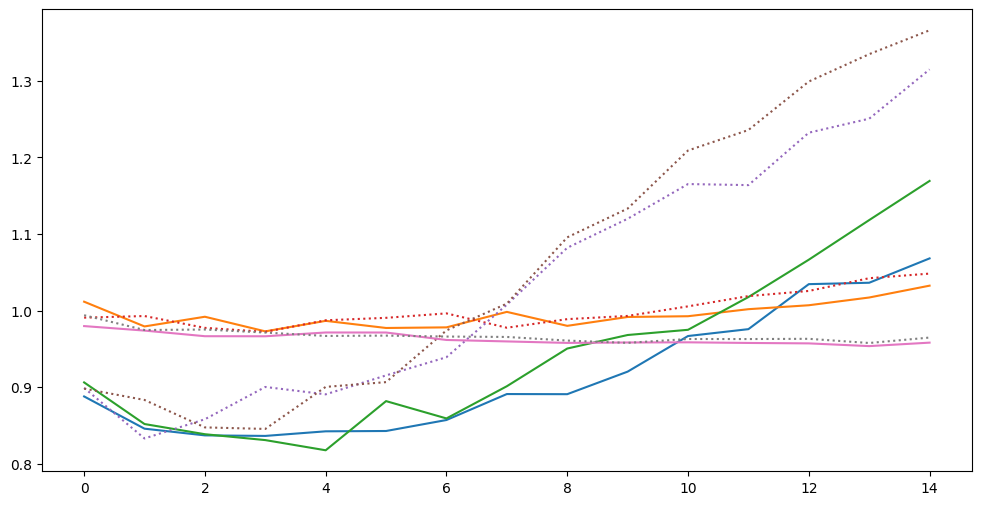

In [ ]:
plt.figure(figsize=(12, 6))

for name, values in losses.items():
  if '2D 3D' not in name:
    linestyle = ':' if '3D' in name else '-'  # Dotted if "3D" in name, solid otherwise
    plt.plot(values, label=name, linestyle=linestyle)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Next step is to define some alternate ways of combining the attentions
- Write the testing set
- Write the Validation set

# Fluorescence Prediction

In [ ]:
!pip install tape-proteins

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 147.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
from tape.datasets import LMDBDataset

# Change the path below to the dataset you want to inspect
dataset_train = LMDBDataset("/content/drive/My Drive/BioTransformer/TAPE /fluorescence/fluorescence_train.lmdb")
dataset_test = LMDBDataset("/content/drive/My Drive/BioTransformer/TAPE /fluorescence/fluorescence_test.lmdb")
dataset_valid = LMDBDataset("/content/drive/My Drive/BioTransformer/TAPE /fluorescence/fluorescence_valid.lmdb")



# Show size
print("Number of sequences for training set:", len(dataset_train))
print("Number of sequences for validation set:", len(dataset_valid))
print("Number of sequences for test set:", len(dataset_test))

Number of sequences for training set: 21446
Number of sequences for validation set: 5362
Number of sequences for test set: 27217


In [ ]:
from torch.utils.data import Dataset
from tape.tokenizers import TAPETokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# Setup tokenizer
tokenizer = TAPETokenizer(vocab='iupac')

# Dataset Class
class FluorescenceDataset(Dataset):
    def __init__(self, lmdb_dataset):
        self.data = lmdb_dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        sequence = entry['primary']
        target = entry['log_fluorescence']
        token_ids = tokenizer.encode(sequence)
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(target, dtype=torch.float32)

# Collate function with padding to 512
FIXED_LEN_SEQ = 512

def collate_fn(batch):
    def pad_tensor(t, pad_value):
        return torch.nn.functional.pad(t, (0, FIXED_LEN_SEQ - t.size(0)), value=pad_value)

    sequences, targets = zip(*batch)
    input_ids = torch.stack([pad_tensor(seq, pad_value=0) for seq in sequences])
    targets = torch.stack(targets)

    return {
        'input_ids': input_ids,
        'targets': targets
    }


# Dataloaders
train_loader = DataLoader(FluorescenceDataset(dataset_train), batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(FluorescenceDataset(dataset_valid), batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(FluorescenceDataset(dataset_test), batch_size=16, shuffle=False, collate_fn=collate_fn)

# Print a batch
batch = next(iter(train_loader))
print(batch['input_ids'].shape)       # [32, 512]
print(batch['targets'].shape)         # [32]


torch.Size([16, 512])
torch.Size([16, 1])


## Defining the Models

In [ ]:
def softmax_5d(X, axis):
    """
    Compute softmax for a 5D tensor along the specified axis.

    Parameters:
        X (numpy.ndarray or torch.Tensor): Input tensor of shape (sample_size, heads, n, n, n)
        axis (int or tuple): Axis along which to apply softmax

    Returns:
        numpy.ndarray or torch.Tensor: Softmax-applied tensor of the same shape as X.
    """
    X_exp = torch.exp(X - torch.amax(X, dim=axis, keepdim=True))  # Stability trick
    return X_exp / torch.sum(X_exp, dim=axis, keepdim=True)


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, p):
        super().__init__()
        self.layer1 = nn.Linear(d_model, d_ff)
        self.layer2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        return self.layer2(self.dropout(self.relu(self.layer1(x))))

class Encoder(nn.Module):
    def __init__(self, p, dim_feedforward, attn_mechanism, **kwargs):
        super().__init__()

        # Extract required arguments from kwargs
        d_model = kwargs["d_model"]
        num_heads = kwargs["num_heads"]
        len_seq = kwargs["len_seq"]
        self.block_size = kwargs.get('block_size', None)
        self.stride = kwargs.get('stride',None)

        # Modify len-seq if padding is required
        if attn_mechanism in {"Attn2DMultiPed3Dselected", "Multiped2D", "MultiLin2D", "Attn3DLinformerMultiPed"}:
              remainder = (len_seq - self.block_size) % self.stride
              pad_len = (self.stride - remainder) % self.stride
              if pad_len > 0:
                len_seq = len_seq + pad_len
                #print(f'len of seq in enc is changed to {len_seq}')
                kwargs["len_seq"] = len_seq  # Update the value in kwargs  # Update the value in kwargs

        # Initialize attention mechanism
        self.mha = get_attention(attn_mechanism, **kwargs)

        # Feedforward and normalization layers
        self.ffn = FeedForward(d_model, dim_feedforward, p)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p)

    def forward(self, x,mask = None):
        attn_output = self.dropout(self.mha(x,mask))
        x = self.norm1(x + attn_output)
        ffn_output = self.dropout(self.ffn(x))
        x = self.norm2(x + ffn_output)
        return x


class FluorescencePredict(nn.Module):
    def __init__(self, vocab_size, num_layers=2, p=0.2, dim_feedforward=32, attn_mechanism="Plain3D", **kwargs):
        super().__init__()
        self.kwargs = kwargs
        d_model = kwargs["d_model"]
        self.attn_mechanism = attn_mechanism
        len_seq = kwargs["len_seq"]
        self.block_size = kwargs.get('block_size', None)
        self.stride = kwargs.get('stride',None)

        # Encoder and Attention
        self.encoder_layers = nn.ModuleList([
            Encoder(p=p, dim_feedforward=dim_feedforward, attn_mechanism=attn_mechanism, **kwargs)
            for _ in range(num_layers)
        ])

        # Modify the len-seq based on padding required
        if attn_mechanism in {"Attn2DMultiPed3Dselected", "Multiped2D", "MultiLin2D", "Multiped3D", "Attn3DLinformerMultiPed", "Attn2DMultiPed3Dselected_Dual"}:
          # how much we need to pad
          remainder = (len_seq - self.block_size) % self.stride
          pad_len = (self.stride - remainder) % self.stride
          if pad_len > 0:
            len_seq = len_seq + pad_len
            #print(f'len of seq var in transformer is changed to {len_seq}')
            kwargs["len_seq"] = len_seq  # Update the value in kwargs

        # Feed Forward Layer
        self.classifier = nn.Sequential(
            nn.Flatten(), # shape: (batch_size, len_seq * len_emb)
            nn.Linear(len_seq * d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(dim_feedforward, 1)
            )

        # AA embedding layer
        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # Positional Embeddings
        self.position_embedding = nn.Embedding(len_seq, d_model)

    def sliding_blocks(self, x):
        """
        Args:
            x (Tensor): Input tensor of shape (batch, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (batch, num_blocks, l, d_model).
        """
        l = self.block_size
        d = self.stride
        batch, seq_len = x.shape

        # unfold along the sequence dimension
        blocks = x.unfold(dimension=1, size=l, step=d)   # (batch, num_blocks, l, d_model)

        return blocks

    def generate_padding_mask(self, input_seq):
      seq_len = input_seq.shape[1]
      batch_size = input_seq.shape[0]
      mask = input_seq != 0 # shape = [bs, len_seq]
      # if self.num_peds:
      #   len_ped = seq_len // self.num_peds
      if self.attn_mechanism == "Multiped3D":
        return self.sliding_blocks(input_seq !=0).unsqueeze(2).unsqueeze(2).unsqueeze(2)
      elif self.attn_mechanism == "Multiped2D":
        return self.sliding_blocks(input_seq !=0).unsqueeze(2).unsqueeze(2)
      elif self.attn_mechanism == 'Linformer2D':
        return mask.unsqueeze(1).unsqueeze(3)
      elif self.attn_mechanism == 'Plain2D':
        #print(f'shape of the mask: {mask.shape}')
        return mask.unsqueeze(1).unsqueeze(1)
      elif self.attn_mechanism == 'Plain3D':
        return mask.unsqueeze(1).unsqueeze(1).unsqueeze(1)
      elif self.attn_mechanism == 'Linformer3D':
        return mask.unsqueeze(1).unsqueeze(3).unsqueeze(3)
      elif self.attn_mechanism == 'MultiLin2D':
        return self.sliding_blocks(input_seq !=0).unsqueeze(2).unsqueeze(4)
      elif self.attn_mechanism == "Attn3DLinformerMultiPed":
        return self.sliding_blocks(input_seq !=0).unsqueeze(2).unsqueeze(4).unsqueeze(4)
      elif self.attn_mechanism == "Combined2D3D":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3DLin":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d =  mask.unsqueeze(1).unsqueeze(3).unsqueeze(3)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3D_MultiPed":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.reshape(batch_size, self.num_peds, len_ped).unsqueeze(2).unsqueeze(2).unsqueeze(2)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3D_MultiPedLin":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.reshape(batch_size, self.num_peds, len_ped).unsqueeze(2).unsqueeze(4).unsqueeze(4)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3DLinAlter":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.unsqueeze(1).unsqueeze(3).unsqueeze(3)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3D_MultiPedLinAlter":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.reshape(batch_size, self.num_peds, len_ped).unsqueeze(2).unsqueeze(4).unsqueeze(4)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2D3D_MultiPedAlter":
        mask2d = mask.unsqueeze(1).unsqueeze(1)
        mask3d = mask.reshape(batch_size, self.num_peds, len_ped).unsqueeze(2).unsqueeze(2).unsqueeze(2)
        return tuple([mask2d,mask3d])
      elif self.attn_mechanism == "Attn2DMultiPed3Dselected":
        return self.sliding_blocks(input_seq !=0)

    def pad_to_sliding_blocks(self, x, pad_value=0):
        """
        Pad sequence length so it divides evenly into sliding-window blocks.

        Args:
            x (Tensor): (B, L, D) input sequence
            block_size (int): size of each block (l)
            stride (int): sliding window step (d)
            pad_value (float, optional): value to use for padding. Defaults to 0.

        Returns:
            Tensor: padded sequence of shape (B, L', D), where
                    (L' - block_size) % stride == 0
            int: number of padding tokens added
        """
        B, L = x.shape

        # how much we need to pad
        remainder = (L - self.block_size) % self.stride
        pad_len = (self.stride - remainder) % self.stride
        #print(f'pad_len : {pad_len}')
        if pad_len > 0:
            pad_tensor = x.new_full((B, pad_len), pad_value)
            x = torch.cat([x, pad_tensor], dim=1)

        return x

    def forward(self, input_ids):
      #print(f'entering the transforer florecence prediction')
      B, L = input_ids.shape
      is_multiped = self.attn_mechanism in {"Attn3DLinformerMultiPed", "MultiLin2D", "Attn2D3D_MultiPed", "Attn2D3D_MultiPedLin", "Attn2DMultiPed3Dselected", "Multiped2D", "Multiped3D"}
      #print(f'is_multiped: {is_multiped}')
      # Add Padding if multiped
      if is_multiped:
        if self.attn_mechanism in {"Attn2DMultiPed3Dselected", "Multiped2D", "MultiLin2D", "Multiped3D", "Attn3DLinformerMultiPed"}:
          # how much we need to pad
          remainder = (L - self.block_size) % self.stride
          pad_len = (self.stride - remainder) % self.stride
          #print(f'number of pads needed: {pad_len}')
          if pad_len > 0:
            input_ids = F.pad(input_ids, (0, pad_len), value=0)
            L = L + pad_len

      # Create the mask internally
      masks = self.generate_padding_mask(input_ids)
      # Create placeholder for positions in the sequence
      pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)
      # Embedding of AAs + Positional Encoding
      x = self.token_embedding(input_ids) + self.position_embedding(pos_ids)
      for layer in self.encoder_layers:
        x = layer(x, mask=masks)
      #print(f'shape of output of encoder layers : {x.shape}')
      # Apply the classifier and squeeze the output
      return self.classifier(x)

### 2D Attention Mechanisms

#### Attention 2D

In [ ]:
class MultiHeadAttn2D(nn.Module):

    def __init__(self,num_heads, d_model):
        super(MultiHeadAttn2D,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Check if the number of len_emb (d_model) is divisable by num_heads
        assert d_model % num_heads == 0, "d_model is not divisable by the number of heads"


    def self_attention(self, q, k, v, mask):

        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask is applied, shape: {mask.shape}')
            #print(f'shape of dot product: {dotqk.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(attention_scores,result)

    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        to
        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, _ = q.shape
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, mask=None):
        k = q.clone()
        v = q.clone()

        # Define Query, Key, Value
        Query = self.split_heads(self.W_q(q))
        Key  = self.split_heads(self.W_k(k))
        Value = self.split_heads(self.W_v(v))

        # Run the self-attention
        attention_scores, attn_output = self.self_attention(Query, Key,Value, mask)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_output.shape
        attn_output = attn_output.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of the result final: {result_final.shape}')

        return result_final



#### Attention 2D Multi-Ped

In [ ]:
class Attn2D_MultiPed(nn.Module):
    """
    """

    def __init__(self,num_heads, d_model, stride = 10, block_size = 40):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.stride = stride
        self.block_size = block_size

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def self_attention(self, q, k, v, mask):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dot-product: {dotqk.shape}')
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in the new sliding block multiped2d')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def _sliding_blocks(self, x):
        """
        Create sliding-window blocks from the sequence.

        Args:
            x (Tensor): (B, L, D).

        Returns:
            Tensor: (B, num_blocks, block_size, D).
        """
        l = self.block_size
        d = self.stride
        B, L, D = x.shape

        num_blocks = (L - l) // d + 1

        # Compute new shape and strides
        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),        # batch stride
            d * x.stride(1),    # jump d steps for each block
            x.stride(1),        # step 1 inside a block
            x.stride(2),        # feature stride
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """
        Reconstruct sequence from overlapping sliding blocks.

        Args:
            blocks (Tensor): (B, num_blocks, block_size, D).
            seq_len (int): Original sequence length.

        Returns:
            Tensor: (B, seq_len, D).
        """
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape

        device = blocks.device

        # Build index map: (num_blocks, block_size) -> positions in seq_len
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        # Expand to batch and feature dims
        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)

        # Flatten everything for scatter
        flat_pos = positions.reshape(B, -1)  # (B, num_blocks * block_size)
        flat_blocks = blocks.reshape(B, -1, D)  # (B, num_blocks * block_size, D)

        # Allocate output
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        # Scatter add the block values into the right positions
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward(self, q,mask = None):
        k = q.clone()
        v = q.clone()
        # Define Query, Key, Value
        Query = self.split_heads(self._sliding_blocks(self.W_q(q)))
        Key  = self.split_heads(self._sliding_blocks(self.W_k(k)))
        Value = self.split_heads(self._sliding_blocks(self.W_v(v)))

        # Run the self-attention
        attn_output = self.self_attention(Query, Key, Value, mask = mask)
        #print(f'shape of the attn outputs:{attn_output.shape}')

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = self._reconstruct_from_blocks(attn_output, q.shape[1])

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)

        return result_final

#### 2D Attention Linformer

In [ ]:
class Attn2DLinformer(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
    """
    def __init__(self, num_heads, d_model, k, len_seq):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)

    def split_heads(self, x):
        B, L, D = x.size()
        x = x.view(B, L, self.num_heads, self.head_dim)
        return x.transpose(1, 2)  # [B, H, L, D]

    def self_attention(self, q, k, v, mask):

        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_dim**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in the linformer')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)


    def forward(self, q,mask = None):
        k = q.clone()
        v = q.clone()
        Q = self.split_heads(self.W_q(q))

        def project(x, linear_proj, W):
            x = W(x).permute(0, 2, 1)
            x = linear_proj(x).permute(0, 2, 1)
            return self.split_heads(x)

        K = project(k, self.E, self.W_k)
        V = project(v, self.F, self.W_v)

        attn_out = self.self_attention(Q, K, V, mask)

        B, H, L, D = attn_out.shape
        concat = attn_out.transpose(1, 2).contiguous().view(B, L, self.d_model)
        return self.W_o(concat)

#### 2D Linformer + Multi-Ped

In [ ]:
class Attn2DLinformerMultiPed(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
        first multi-ped then linformer attention
    """
    def __init__(self, num_heads, d_model, k, len_seq, num_peds):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(len_seq//num_peds, k)
        self.F = nn.Linear(len_seq//num_peds, k)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_dim).transpose(2,3)

    def self_attention(self, q, k, v, mask= None):

        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_dim**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            print(f'mask in implemented')
            print(f'shape of the mask implemented: {mask.shape}')
            print(f'shape of the attn: {dotqk.shape}')

        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def split_sequence(self, q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, seq_len, d_model = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        return q.reshape(samples, self.num_peds, seq_len // self.num_peds, d_model)


    def forward(self, q,mask = None):
        k = q.clone()
        v = q.clone()
        Q = self.split_heads(self.split_sequence(self.W_q(q)))

        def project(x, linear_proj, W):
            '''
            Expected input shape: ([batch_size, len_seq, d_model])

            '''
            x = self.split_sequence(W(x)) #shape: ([batch_size, num_peds, len_ped, d_model])
            x = x.permute(0, 1, 3, 2) #shape: ([batch_size, num_peds, d_model, len_ped])
            #print(f'linear proj: {linear_proj}, shape of x: {x.shape}')
            x = linear_proj(x) # shape: torch.Size([batch_size, num_peds, d_model, k])
            x = x.permute(0, 1, 3, 2) # shape: torch.Size([batch_size, num_peds, k, d_model])
            return self.split_heads((x)) # shape: torch.Size([batch_size, num_peds, num_heads, k , head_dim])

        K = project(k, self.E, self.W_k)
        V = project(v, self.F, self.W_v)

        attn_output = self.self_attention(Q, K, V,mask = mask)

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = attn_output.contiguous().view(batch_size, len_ped * num_peds, self.d_model)
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

In [ ]:
class Attn2DLinformerMultiPed(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
        first multi-ped then linformer attention
    """
    def __init__(self, num_heads, d_model, k, len_seq, stride, block_size):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.stride = stride
        self.block_size = block_size

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(block_size, k)
        self.F = nn.Linear(block_size, k)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_dim).transpose(2,3)

    def self_attention(self, q, k, v, mask):

        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_dim**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk: {dotqk.shape}')
        # Apply the mask if givne
        if mask is not None:
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def _sliding_blocks(self, x):
        """
        Create sliding-window blocks from the sequence.

        Args:
            x (Tensor): (B, L, D).

        Returns:
            Tensor: (B, num_blocks, block_size, D).
        """
        l = self.block_size
        d = self.stride
        B, L, D = x.shape

        num_blocks = (L - l) // d + 1

        # Compute new shape and strides
        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),        # batch stride
            d * x.stride(1),    # jump d steps for each block
            x.stride(1),        # step 1 inside a block
            x.stride(2),        # feature stride
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """
        Reconstruct sequence from overlapping sliding blocks.

        Args:
            blocks (Tensor): (B, num_blocks, block_size, D).
            seq_len (int): Original sequence length.

        Returns:
            Tensor: (B, seq_len, D).
        """
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape

        device = blocks.device

        # Build index map: (num_blocks, block_size) -> positions in seq_len
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        # Expand to batch and feature dims
        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)

        # Flatten everything for scatter
        flat_pos = positions.reshape(B, -1)  # (B, num_blocks * block_size)
        flat_blocks = blocks.reshape(B, -1, D)  # (B, num_blocks * block_size, D)

        # Allocate output
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        # Scatter add the block values into the right positions
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward(self, q,mask = None):
        k = q.clone()
        v = q.clone()
        Q = self.split_heads(self._sliding_blocks(self.W_q(q)))
        #print(f'shape of query: {Q.shape}')

        def project(x, linear_proj, W):
            '''
            Expected input shape: ([batch_size, len_seq, d_model])

            '''
            x = self._sliding_blocks(W(x)) #shape: ([batch_size, num_peds, len_ped, d_model])
            x = x.permute(0, 1, 3, 2) #shape: ([batch_size, num_peds, d_model, len_ped])
            #print(f'linear proj: {linear_proj}, shape of x permuted: {x.shape}')
            x = linear_proj(x) # shape: torch.Size([batch_size, num_peds, d_model, k])
            x = x.permute(0, 1, 3, 2) # shape: torch.Size([batch_size, num_peds, k, d_model])
            return self.split_heads((x)) # shape: torch.Size([batch_size, num_peds, num_heads, k , head_dim])

        K = project(k, self.E, self.W_k)
        #print(f'shape of key lin: {K.shape}')
        V = project(v, self.F, self.W_v)

        attn_output = self.self_attention(Q, K, V,mask)

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = self._reconstruct_from_blocks(attn_output, q.shape[1])
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

### 3D Attention Mechanisms

#### Combined 2D+ 3D Attention

In [ ]:
class Attn_2D3DC(nn.Module):
    """
    """

    def __init__(self,num_heads, d_model):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

    def self_attention1(self, q, k, v, mask= None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention2(self, q, k,l, v,mask= None):
        # Save the length of the sequence
        #seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abid,abjd,abkd -> abijk', q, k, l) /(self.head_params**0.5) # Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask received: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate the V^2 matrix
        vtilde = torch.einsum('abcd,abed->abced', v, v)
        # Multiply 3D attention with V^2
        result = torch.einsum('abijk,abjkl->abil', attention_scores, vtilde)
        return(result)

    def combined_attention(self, q, k,l, v, masks):
      """
      This is combining the original attention with the modified attention.
      mask1 is the mask with the original dimensions
      mask2 is the mask with the modified dimensions
      """
      mask2d, mask3d = masks
      result1_attention = self.self_attention1(q, k, v, mask2d)
      result2_attention = self.self_attention2(q, k,l, v, mask3d)

      return(self.norm1(result1_attention)+self.norm2(result2_attention)) #combined normalized results


    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        to
        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, masks = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()

        # Define Query, Key, Value
        Query = self.split_heads(self.W_q(q))
        Key  = self.split_heads(self.W_k(k))
        L_matrix = self.split_heads(self.W_l(l))
        Value = self.split_heads(self.W_v(v))

        # Run the self-attention
        attn_outputs_combined = self.combined_attention(Query, Key,L_matrix, Value, masks)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Combined 2D + Linformer 3D

In [ ]:
class Attn2D3DLin(nn.Module):

    """
    Combined 2D and 3D Linformer Attention
    """

    def __init__(self,num_heads, d_model, k, len_seq):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Linformer Projections
        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

    def self_attention2D(self, q, k, v, mask= None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3DLin(self, q, k, l, v, mask = None):
        # Compute trilinear attention scores
        scores = torch.einsum('bhid,bhjd,bhkd->bhijk', q, k, l) / (self.head_params ** 0.5)
        #print(f'shape of scores: {scores.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            scores = scores.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 3D attn')
        attn_weights = softmax_5d(scores, axis=(-1, -2))

        v_3d = torch.einsum('bhld,bhLd->bhlLd', v, v)  # Could be simplified
        output = torch.einsum('bhijk,bhjkl->bhil', attn_weights, v_3d)
        return output


    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, mask = None):
        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()

        # Unwarp the masks
        mask2D = mask[0]
        mask3D = mask[1]

        # Query will be the same for both attentions
        Q = self.split_heads(self.W_q(q))

        # Define Key and Value for 2D Attention
        K_2D  = self.split_heads(self.W_k(k))
        V_2D = self.split_heads(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Q, K_2D, V_2D, mask2D)

        def project(x, linear_proj, W):
          x = W(x).permute(0, 2, 1)
          x = linear_proj(x).permute(0, 2, 1)
          return self.split_heads(x)

        # Define the Query, Key, Utinity and Value matrices for Linformer 3D
        K_Lin = project(k, self.E, self.W_k)
        L_Lin = project(l, self.F, self.W_l)
        V_Lin = project(v, self.G, self.W_v)

        # Run Linformer 3D attention
        attn_outputs_3DLin= self.self_attention3DLin(Q, K_Lin, L_Lin, V_Lin, mask3D)

        # Combine the attentions
        attn_outputs_combined = self.norm1(attn_outputs_2D) + self.norm2(attn_outputs_3DLin)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Alternate Combined 2D + 3D Linformer

In [ ]:
class Attn2D3DLinAlter(nn.Module):

    """
    Combined 2D and 3D Linformer Attention
    """

    def __init__(self,num_heads, d_model, k, len_seq):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Linformer Projections
        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

        self.linear = nn.Linear(2*self.head_params,self.head_params)

    def self_attention2D(self, q, k, v, mask= None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk 2D: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3DLin(self, q, k, l, v, mask = None):
        # Compute trilinear attention scores
        scores = torch.einsum('bhid,bhjd,bhkd->bhijk', q, k, l) / (self.head_params ** 0.5)
        #print(f'shape of scores Linformer: {scores.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            scores = scores.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 3D attn')
        attn_weights = softmax_5d(scores, axis=(-1, -2))

        v_3d = torch.einsum('bhld,bhLd->bhlLd', v, v)  # Could be simplified
        output = torch.einsum('bhijk,bhjkl->bhil', attn_weights, v_3d)
        return output


    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, mask = None):
        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()

        # Unwarp the masks
        mask2D = mask[0]
        mask3D = mask[1]

        # Query will be the same for both attentions
        Q = self.split_heads(self.W_q(q))

        # Define Key and Value for 2D Attention
        K_2D  = self.split_heads(self.W_k(k))
        V_2D = self.split_heads(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Q, K_2D, V_2D, mask2D)

        def project(x, linear_proj, W):
          x = W(x).permute(0, 2, 1)
          x = linear_proj(x).permute(0, 2, 1)
          return self.split_heads(x)

        # Define the Query, Key, Utinity and Value matrices for Linformer 3D
        K_Lin = project(k, self.E, self.W_k)
        L_Lin = project(l, self.F, self.W_l)
        V_Lin = project(v, self.G, self.W_v)

        # Run Linformer 3D attention
        attn_outputs_3DLin= self.self_attention3DLin(Q, K_Lin, L_Lin, V_Lin, mask3D)

        # Concatenate the two attentions
        combined_attention = torch.cat((attn_outputs_2D, attn_outputs_3DLin), dim=-1)
        #print(f'shape of combined attention before linear: {combined_attention.shape}')
        combined_attention = self.linear(combined_attention)
        #print(f'shape of combined attention after linear: {combined_attention.shape}')

        # Concatenate the heads
        batch_size, _,seq_len, _= combined_attention.shape
        combined_attention = combined_attention.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(combined_attention) #shape = (#samples, len_seq, d_model)

        return result_final

#### Combined 2D and 3D Multiped Alternative

In [ ]:
class Attn2D3D_MultiPedAlter(nn.Module):

    """
    Combined 2D and 3D Multi-Ped Attention
    """

    def __init__(self,num_heads, d_model, num_peds):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)


        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

        self.linear = nn.Linear(2*self.head_params,self.head_params)

    def self_attention2D(self, q, k, v, mask = None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk in 2D : {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3DMultiPed(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl in 3D MultiPed: {mul_qkl.shape}')
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 3D attn')
            #print(f'mask applied to 3D multiped; shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads2D(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)


    def split_sequence(self, q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, seq_len, d_model = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, seq_len // self.num_peds, d_model)

    def split_heads3D(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def forward(self, q, mask = None):
        #print(f'combined 2D and 3D multiped is activated')

        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()

        mask_2D = None
        mask_3DMP = None

        # Unpack the masks
        if mask is not None:
          mask_2D = mask[0]
          #print(f'mask_2D{mask_2D}, shape = {mask_2D.shape}')
          mask_3DMP = mask[1]
          #print(f'mask_3DMP{mask_3DMP}, shape = {mask_3DMP.shape}')

        Query_2D = self.split_heads2D(self.W_q(q))
        Key_2D  = self.split_heads2D(self.W_k(k))
        Value_2D = self.split_heads2D(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Query_2D, Key_2D, Value_2D, mask = mask_2D) # (batch_size, num_heads, len_seq, head_params)

        # Define the Query, Key, Utinity and Value matrices for Multi-Ped 3D
        Query_3D = self.split_heads3D(self.split_sequence(self.W_q(q)))
        Key_3D  = self.split_heads3D(self.split_sequence(self.W_k(k)))
        Value_3D = self.split_heads3D(self.split_sequence(self.W_v(v)))
        L_matrix = self.split_heads3D(self.split_sequence(self.W_l(l)))

        # Run MultiPed 3D attention
        attn_outputs_3DMultiPed= self.self_attention3DMultiPed(Query_3D, Key_3D, L_matrix, Value_3D, mask = mask_3DMP) # (batch_size, num_peds, num_heads, len_ped, head_params)
        #print(f'shape of attention 2D output: {attn_outputs_3DMultiPed.shape}')

        # Combine the peds
        batch_size, num_peds, num_heads, len_ped ,len_head = attn_outputs_3DMultiPed.shape
        attn_outputs_3DMultiPed = attn_outputs_3DMultiPed.contiguous().view(batch_size, num_heads, num_peds*len_ped, len_head)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_3DMultiPed.shape}')
        # Concatenate the output of the attentions
        attn_outputs_concat = torch.cat((attn_outputs_2D, attn_outputs_3DMultiPed), dim=-1)
        #print(f'shape of attns concatednate : {attn_outputs_concat.shape}')

        # Combine the attentions
        attn_outputs_combined = self.linear(attn_outputs_concat)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_combined.shape}')

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Combined 2D + Multi-Ped 3D (global 2D + Local 3D)

In [ ]:
class Attn2D3D_MultiPed(nn.Module):

    """
    Combined 2D and 3D Multi-Ped Attention
    """

    def __init__(self,num_heads, d_model, num_peds):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)


        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

    def self_attention2D(self, q, k, v, mask = None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk in 2D : {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3DMultiPed(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl in 3D MultiPed: {mul_qkl.shape}')
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 3D attn')
            #print(f'mask applied to 3D multiped; shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads2D(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)


    def split_sequence(self, q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, seq_len, d_model = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, seq_len // self.num_peds, d_model)

    def split_heads3D(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def forward(self, q, mask = None):
        #print(f'combined 2D and 3D multiped is activated')

        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()

        mask_2D = None
        mask_3DMP = None

        # Unpack the masks
        if mask is not None:
          mask_2D = mask[0]
          #print(f'mask_2D{mask_2D}, shape = {mask_2D.shape}')
          mask_3DMP = mask[1]
          #print(f'mask_3DMP{mask_3DMP}, shape = {mask_3DMP.shape}')

        Query_2D = self.split_heads2D(self.W_q(q))
        Key_2D  = self.split_heads2D(self.W_k(k))
        Value_2D = self.split_heads2D(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Query_2D, Key_2D, Value_2D, mask = mask_2D) # (batch_size, num_heads, len_seq, head_params)

        # Define the Query, Key, Utinity and Value matrices for Multi-Ped 3D
        Query_3D = self.split_heads3D(self.split_sequence(self.W_q(q)))
        Key_3D  = self.split_heads3D(self.split_sequence(self.W_k(k)))
        Value_3D = self.split_heads3D(self.split_sequence(self.W_v(v)))
        L_matrix = self.split_heads3D(self.split_sequence(self.W_l(l)))

        # Run MultiPed 3D attention
        attn_outputs_3DMultiPed= self.self_attention3DMultiPed(Query_3D, Key_3D, L_matrix, Value_3D, mask = mask_3DMP) # (batch_size, num_peds, num_heads, len_ped, head_params)
        #print(f'shape of attention 2D output: {attn_outputs_3DMultiPed.shape}')

        # Combine the peds
        batch_size, num_peds, num_heads, len_ped ,len_head = attn_outputs_3DMultiPed.shape
        attn_outputs_3DMultiPed = attn_outputs_3DMultiPed.contiguous().view(batch_size, num_heads, num_peds*len_ped, len_head)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_3DMultiPed.shape}')

        # Combine the attentions
        attn_outputs_combined = self.norm1(attn_outputs_2D) + self.norm2(attn_outputs_3DMultiPed)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Combined 2D with 3D MultiPed Linformer

In [ ]:
class Attn2D3D_MultiPedLin(nn.Module):

    """
    Combined 2D and 3D Multi-Ped Attention
    """

    def __init__(self,num_heads, d_model, num_peds, len_seq, k):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Linformer Projections
        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

    def self_attention2D(self, q, k, v, mask = None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk 2D Attn: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
            #print(f'mask applied to 2D attention. Shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3D(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied to 3D multiped Linformer; shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)


    def split_sequence(self,q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, num_heads, seq_len, head_params = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, num_heads, seq_len // self.num_peds, head_params)


    def forward(self, q, mask = None):
        #print(f'combined 2D and 3D multiped is activated')

        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()
        mask_2D = None
        mask_3DMP = None

        # Unpack the masks
        if mask is not None:
          mask_2D = mask[0]
          #print(f'mask_2D{mask_2D}, shape = {mask_2D.shape}')
          mask_3DMP = mask[1]
          #print(f'mask_3DMP{mask_3DMP}, shape = {mask_3DMP.shape}')

        Query_2D = self.split_heads(self.W_q(q))
        Key_2D  = self.split_heads(self.W_k(k))
        Value_2D = self.split_heads(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Query_2D, Key_2D, Value_2D, mask = mask_2D) # (batch_size, num_heads, len_seq, head_params)

        # Define the Query, Key, Utinity and Value matrices for Multi-Ped 3D
        Query_3D = self.split_sequence(Query_2D)
        Key_3D  = self.split_sequence(Key_2D)
        Value_3D = self.split_sequence(Value_2D)
        L_matrix = self.split_sequence(self.split_heads(self.W_l(l)))

        # Run MultiPed 3D attention
        attn_outputs_3DMultiPed= self.self_attention3D(Query_3D, Key_3D, L_matrix, Value_3D, mask = mask_3DMP) # (batch_size, num_peds, num_heads, len_ped, head_params)
        #print(f'shape of attention 2D output: {attn_outputs_3DMultiPed.shape}')

        # Combine the peds
        batch_size, num_peds, num_heads, len_ped ,len_head = attn_outputs_3DMultiPed.shape
        attn_outputs_3DMultiPed = attn_outputs_3DMultiPed.contiguous().view(batch_size, num_heads, num_peds*len_ped, len_head)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_3DMultiPed.shape}')

        # Combine the attentions
        attn_outputs_combined = self.norm1(attn_outputs_2D) + self.norm2(attn_outputs_3DMultiPed)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Dual 3D Attns

In [ ]:
class Attn3D_MultiPed_Dual(nn.Module):
    """
    Multi-ped 3D Attention with two parallel attention modules
    whose outputs are summed together.
    """

    def __init__(self, num_heads, d_model, block_size, stride):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model // num_heads
        self.block_size = block_size
        self.stride = stride

        # First attention set
        self.W_q1 = nn.Linear(d_model, d_model)
        self.W_k1 = nn.Linear(d_model, d_model)
        self.W_l1 = nn.Linear(d_model, d_model)
        self.W_v1 = nn.Linear(d_model, d_model)
        self.W_o1 = nn.Linear(d_model, d_model)

        # Second attention set
        self.W_q2 = nn.Linear(d_model, d_model)
        self.W_k2 = nn.Linear(d_model, d_model)
        self.W_l2 = nn.Linear(d_model, d_model)
        self.W_v2 = nn.Linear(d_model, d_model)
        self.W_o2 = nn.Linear(d_model, d_model)

    def self_attention(self, q, k, l, v, mask=None):
        mul_qkl = torch.einsum(
            'abcid,abcjd,abckd -> abcijk', q, k, l
        ) / (self.head_params ** 0.5)

        if mask is not None:
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)

        attention_scores = softmax_5d(mul_qkl, axis=(-1, -2))

        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        return result

    def split_heads(self, x):
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2, 3)

    def _sliding_blocks(self, x):
        l = self.block_size
        d = self.stride
        B, L, D = x.shape
        num_blocks = (L - l) // d + 1

        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),
            d * x.stride(1),
            x.stride(1),
            x.stride(2),
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape
        device = blocks.device

        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)
        flat_pos = positions.reshape(B, -1)
        flat_blocks = blocks.reshape(B, -1, D)

        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def _run_attention_set(self, q, W_q, W_k, W_l, W_v, W_o, mask=None):
        k = q.clone()
        l = q.clone()
        v = q.clone()

        Query = self.split_heads(self._sliding_blocks(W_q(q)))
        Key = self.split_heads(self._sliding_blocks(W_k(k)))
        L_matrix = self.split_heads(self._sliding_blocks(W_l(l)))
        Value = self.split_heads(self._sliding_blocks(W_v(v)))

        attn_output = self.self_attention(Query, Key, L_matrix, Value, mask=mask)

        batch_size, num_peds, num_heads, len_ped, len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)

        len_seq = q.shape[1]
        attn_output = self._reconstruct_from_blocks(attn_output, len_seq)

        return W_o(attn_output)

    def forward(self, q, mask=None):
        # Run first attention set
        out1 = self._run_attention_set(q, self.W_q1, self.W_k1, self.W_l1, self.W_v1, self.W_o1, mask)

        # Run second attention set
        out2 = self._run_attention_set(q, self.W_q2, self.W_k2, self.W_l2, self.W_v2, self.W_o2, mask)

        # Add results
        return out1 + out2


In [ ]:
class Attn3DLinformer_Dual(nn.Module):
    """
    Dual Attention 3D Linformer:
    Runs two independent attention mechanisms (with separate weights)
    and sums their outputs.
    """
    def __init__(self, num_heads, d_model, k, len_seq):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        # First attention weights
        self.W_q1 = nn.Linear(d_model, d_model)
        self.W_k1 = nn.Linear(d_model, d_model)
        self.W_l1 = nn.Linear(d_model, d_model)
        self.W_v1 = nn.Linear(d_model, d_model)
        self.W_o1 = nn.Linear(d_model, d_model)

        self.E1 = nn.Linear(len_seq, k)
        self.F1 = nn.Linear(len_seq, k)
        self.G1 = nn.Linear(len_seq, k)

        # Second attention weights
        self.W_q2 = nn.Linear(d_model, d_model)
        self.W_k2 = nn.Linear(d_model, d_model)
        self.W_l2 = nn.Linear(d_model, d_model)
        self.W_v2 = nn.Linear(d_model, d_model)
        self.W_o2 = nn.Linear(d_model, d_model)

        self.E2 = nn.Linear(len_seq, k)
        self.F2 = nn.Linear(len_seq, k)
        self.G2 = nn.Linear(len_seq, k)

    def split_heads(self, x):
        B, L, D = x.size()
        x = x.view(B, L, self.num_heads, self.head_dim)
        return x.transpose(1, 2)  # [B, H, L, D]

    def self_attention(self, q, k, l, v, mask):
        scores = torch.einsum('bhid,bhjd,bhkd->bhijk', q, k, l) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn_weights = softmax_5d(scores, axis=(-1, -2))

        v_3d = torch.einsum('bhld,bhLd->bhlLd', v, v)
        output = torch.einsum('bhijk,bhjkl->bhil', attn_weights, v_3d)
        return output

    def forward_path(self, q, k, l, v, W_q, W_k, W_l, W_v, W_o, E, F, G, mask):
        Q = self.split_heads(W_q(q))

        def project(x, linear_proj, W):
            x = W(x).permute(0, 2, 1)
            x = linear_proj(x).permute(0, 2, 1)
            return self.split_heads(x)

        K = project(k, E, W_k)
        L = project(l, F, W_l)
        V = project(v, G, W_v)

        attn_out = self.self_attention(Q, K, L, V, mask)
        B, H, L_seq, D = attn_out.shape
        concat = attn_out.transpose(1, 2).contiguous().view(B, L_seq, self.d_model)
        return W_o(concat)

    def forward(self, q, mask=None):
        k, l, v = q.clone(), q.clone(), q.clone()

        out1 = self.forward_path(q, k, l, v, self.W_q1, self.W_k1, self.W_l1, self.W_v1, self.W_o1, self.E1, self.F1, self.G1, mask)
        out2 = self.forward_path(q, k, l, v, self.W_q2, self.W_k2, self.W_l2, self.W_v2, self.W_o2, self.E2, self.F2, self.G2, mask)

        return out1 + out2


In [ ]:
class Attn3DLinformerMultiPed_Dual(nn.Module):
    """
    Dual Attention version of MultiPed + Linformer 3D attention.
    Runs two independent attention mechanisms (with separate weights)
    and sums their outputs.
    """
    def __init__(self, num_heads, d_model, k, len_seq, block_size, stride):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.block_size = block_size
        self.stride = stride

        # First attention weights
        self.W_q1 = nn.Linear(d_model, d_model)
        self.W_k1 = nn.Linear(d_model, d_model)
        self.W_l1 = nn.Linear(d_model, d_model)
        self.W_v1 = nn.Linear(d_model, d_model)
        self.W_o1 = nn.Linear(d_model, d_model)

        self.E1 = nn.Linear(block_size, k)
        self.F1 = nn.Linear(block_size, k)
        self.G1 = nn.Linear(block_size, k)

        # Second attention weights
        self.W_q2 = nn.Linear(d_model, d_model)
        self.W_k2 = nn.Linear(d_model, d_model)
        self.W_l2 = nn.Linear(d_model, d_model)
        self.W_v2 = nn.Linear(d_model, d_model)
        self.W_o2 = nn.Linear(d_model, d_model)

        self.E2 = nn.Linear(block_size, k)
        self.F2 = nn.Linear(block_size, k)
        self.G2 = nn.Linear(block_size, k)

    def split_heads(self, x):
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_dim).transpose(2, 3)

    def self_attention(self, q, k, l, v, mask=None):
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_dim**0.5)
        if mask is not None:
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
        attention_scores = softmax_5d(mul_qkl, axis=(-1, -2))
        vtilde = torch.einsum('abcid,abcjd->abcijd', v, v)
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        return result

    def _sliding_blocks(self, x):
        l = self.block_size
        d = self.stride
        B, L, D = x.shape
        num_blocks = (L - l) // d + 1
        shape = (B, num_blocks, l, D)
        strides = (x.stride(0), d * x.stride(1), x.stride(1), x.stride(2))
        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape
        device = blocks.device

        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]
        positions = positions.unsqueeze(0).expand(B, -1, -1)

        flat_pos = positions.reshape(B, -1)
        flat_blocks = blocks.reshape(B, -1, D)

        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward_path(self, q, W_q, W_k, W_l, W_v, W_o, E, F, G, mask):
        k, l, v = q.clone(), q.clone(), q.clone()
        Q = self.split_heads(self._sliding_blocks(W_q(q)))

        def project(x, linear_proj, W):
            x = self._sliding_blocks(W(x))
            x = x.permute(0, 1, 3, 2)
            x = linear_proj(x)
            x = x.permute(0, 1, 3, 2)
            return self.split_heads(x)

        K = project(k, E, W_k)
        L = project(l, F, W_l)
        V = project(v, G, W_v)

        attn_output = self.self_attention(Q, K, L, V, mask)
        batch_size, num_peds, num_heads, len_ped, len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        attn_output = self._reconstruct_from_blocks(attn_output, q.shape[1])
        return W_o(attn_output)

    def forward(self, q, mask=None):
        out1 = self.forward_path(q, self.W_q1, self.W_k1, self.W_l1, self.W_v1, self.W_o1, self.E1, self.F1, self.G1, mask)
        out2 = self.forward_path(q, self.W_q2, self.W_k2, self.W_l2, self.W_v2, self.W_o2, self.E2, self.F2, self.G2, mask)
        return out1 + out2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attn2DMultiPed3Dselected_Dual(nn.Module):
    """
    Two completely separate Attention Mechanisms with 2D and selected 3D interactions.
    Each branch has its own Q, K, V, L projections.
    The outputs of the two branches are added together.
    """
    def __init__(self, num_heads: int, d_model: int, stride: int = 10, block_size: int = 40, k=4, k_prime=2):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.stride = stride
        self.block_size = block_size
        self.k = k
        self.k_prime = k_prime

        # Branch 1 projections
        self.W_q1 = nn.Linear(d_model, d_model)
        self.W_k1 = nn.Linear(d_model, d_model)
        self.W_v1 = nn.Linear(d_model, d_model)
        self.W_l1 = nn.Linear(d_model, d_model)

        # Branch 2 projections
        self.W_q2 = nn.Linear(d_model, d_model)
        self.W_k2 = nn.Linear(d_model, d_model)
        self.W_v2 = nn.Linear(d_model, d_model)
        self.W_l2 = nn.Linear(d_model, d_model)

        # Output projection (shared after adding the two branches)
        self.W_o = nn.Linear(d_model, d_model)

        # Fusion layer (per-branch fusion of 2D and 3D outputs)
        self.fusion_layer = nn.Linear(2 * self.head_dim, self.head_dim)

    #### Helper functions (same as before) ####
    def _split_heads(self, x):
        B, Blk, L, D = x.size()
        return x.view(B, Blk, L, self.num_heads, self.head_dim).transpose(2, 3)

    def _sliding_blocks(self, x):
        l, d = self.block_size, self.stride
        B, L, D = x.shape
        num_blocks = (L - l) // d + 1
        shape = (B, num_blocks, l, D)
        strides = (x.stride(0), d * x.stride(1), x.stride(1), x.stride(2))
        return x.as_strided(shape, strides).contiguous()

    def _topk_submats_adv(self, attn_scores: torch.Tensor, topk_idx: torch.Tensor):
        B, Blk, H, L, _ = attn_scores.shape
        K = topk_idx.shape[-1]
        device = attn_scores.device
        topk_idx = topk_idx.long().to(device)

        # Select rows
        b = torch.arange(B, device=device)[:, None, None, None, None].expand(B, Blk, H, L, K)
        bl = torch.arange(Blk, device=device)[None, :, None, None, None].expand(B, Blk, H, L, K)
        h = torch.arange(H, device=device)[None, None, :, None, None].expand(B, Blk, H, L, K)
        q = torch.arange(L, device=device)[None, None, None, :, None].expand(B, Blk, H, L, K)
        row_selected = attn_scores[b, bl, h, topk_idx, :]  # (B, Blk, H, L, K, L)

        # Select cols
        b2 = torch.arange(B, device=device)[:, None, None, None, None, None].expand(B, Blk, H, L, K, K)
        bl2 = torch.arange(Blk, device=device)[None, :, None, None, None, None].expand(B, Blk, H, L, K, K)
        h2 = torch.arange(H, device=device)[None, None, :, None, None, None].expand(B, Blk, H, L, K, K)
        q2 = torch.arange(L, device=device)[None, None, None, :, None, None].expand(B, Blk, H, L, K, K)
        cols = topk_idx.unsqueeze(-2).expand(B, Blk, H, L, K, K)

        sub = row_selected[b2, bl2, h2, q2, torch.arange(K, device=device)[None, None, None, None, :, None], cols]
        return sub

    def _reconstruct_from_blocks(self, blocks, seq_len):
        l, d = self.block_size, self.stride
        B, num_blocks, _, D = blocks.shape
        device = blocks.device
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = (start_idx[:, None] + block_offsets).unsqueeze(0).expand(B, -1, -1)
        flat_pos, flat_blocks = positions.reshape(B, -1), blocks.reshape(B, -1, D)
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())
        return out / counts

    def _gather_partners(self, tensor, partner_idx):
        return torch.gather(tensor, 4, partner_idx.unsqueeze(-1).expand(*partner_idx.shape, self.head_dim))

    def _self_attention_2d(self, q, k, v, mask=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(2).unsqueeze(4) == 0, -1e9)
        attn_scores = torch.softmax(scores, dim=-1)
        return attn_scores, torch.matmul(attn_scores, v)

    def compute_selected_mask(self, mask, partner1, partner2, L):
        if mask is None:
            return None
        mask_reshaped1 = mask.unsqueeze(2).expand(-1, -1, self.num_heads, -1)
        mask_reshaped2 = mask_reshaped1.unsqueeze(-2).expand(-1, -1, -1, L, -1)
        mask1_comp = torch.gather(mask_reshaped2, 4, partner1)
        mask2_comp = torch.gather(mask_reshaped2, 4, partner2)
        two_way_interac_mask = mask1_comp * mask2_comp
        mask_comp3 = mask_reshaped1.unsqueeze(-1).expand(-1, -1, -1, -1, partner1.size(-1))
        return mask_comp3 * two_way_interac_mask

    #### Branch-specific computation ####
    def _branch_attention(self, Q, Key, V, L_mat, mask):
        attn_scores, attn_out_2d = self._self_attention_2d(Q, Key, V, mask=mask)

        topk_scores, topk_idx = torch.topk(attn_scores, self.k, dim=-1)
        outer = topk_scores[..., :, None] * topk_scores[..., None, :]
        selected = self._topk_submats_adv(attn_scores, topk_idx)
        res = outer * selected
        B, Blk, H, L, K, _ = res.shape
        _, topk_exp = torch.topk(res.view(B, Blk, H, L, -1), self.k_prime, dim=-1)
        row_idx, col_idx = topk_exp // self.k, topk_exp % self.k_prime
        partner1, partner2 = torch.gather(topk_idx, -1, row_idx), torch.gather(topk_idx, -1, col_idx)

        K_exp = Key.unsqueeze(-3).expand(-1, -1, -1, L, -1, -1)
        L_exp = L_mat.unsqueeze(-3).expand(-1, -1, -1, L, -1, -1)
        V_exp = V.unsqueeze(-3).expand(-1, -1, -1, L, -1, -1)

        k_sel = self._gather_partners(K_exp, partner1)
        l_sel = self._gather_partners(L_exp, partner2)
        v1 = self._gather_partners(V_exp, partner1)
        v2 = self._gather_partners(V_exp, partner2)

        q_exp = Q.unsqueeze(-2)
        dot_qkl = (q_exp * k_sel * l_sel).sum(-1)
        final_mask = self.compute_selected_mask(mask, partner1, partner2, L)
        if final_mask is not None:
            dot_qkl = dot_qkl.masked_fill(final_mask == 0, -1e9)

        attn_weights_3d = torch.softmax(dot_qkl, dim=-1)
        v_sq = v1 * v2
        dot_qkl_exp = attn_weights_3d.unsqueeze(-1).expand(-1, -1, -1, -1, -1, self.head_dim)
        res_3d = (dot_qkl_exp * v_sq).sum(-2)

        res_combined = torch.cat([attn_out_2d, res_3d], dim=-1)
        return self.fusion_layer(res_combined)

    #### Forward ####
    def forward(self, x, mask=None):
        B, L, D = x.shape

        # Branch 1
        q1, k1, v1, l1 = self.W_q1(x), self.W_k1(x), self.W_v1(x), self.W_l1(x)
        Q1, K1, V1, L1 = map(lambda t: self._split_heads(self._sliding_blocks(t)), (q1, k1, v1, l1))
        out1 = self._branch_attention(Q1, K1, V1, L1, mask)

        # Branch 2
        q2, k2, v2, l2 = self.W_q2(x), self.W_k2(x), self.W_v2(x), self.W_l2(x)
        Q2, K2, V2, L2 = map(lambda t: self._split_heads(self._sliding_blocks(t)), (q2, k2, v2, l2))
        out2 = self._branch_attention(Q2, K2, V2, L2, mask)

        # Add branches
        summed = out1 + out2
        B, Blk, H, L_blk, hd = summed.shape
        out = summed.transpose(2, 3).contiguous().view(B, Blk, L_blk, self.d_model)

        # Reconstruct and project
        recon = self._reconstruct_from_blocks(out, x.shape[1])
        return self.W_o(recon)


#### Combined 2D with 3D Multi-Ped Linformer

In [ ]:
class Attn2D3D_MultiPedLinAlter(nn.Module):

    """
    Combined 2D and 3D Multi-Ped Attention
    """

    def __init__(self,num_heads, d_model, num_peds, len_seq, k):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Linformer Projections
        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

        self.norm1 = nn.LayerNorm(self.head_params)
        self.norm2 = nn.LayerNorm(self.head_params)

        self.linear = nn.Linear(2*self.head_params, self.head_params)

    def self_attention2D(self, q, k, v, mask = None):
        # Calculate the dot produce of Q and K
        dotqk = torch.matmul(q, k.transpose(-2,-1))/(self.head_params**0.5) # shape = (#samples, num_heads, len_seq, len_seq)
        #print(f'shape of dotqk 2D Attn: {dotqk.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            dotqk = dotqk.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in 2D attn')
            #print(f'mask applied to 2D attention. Shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = torch.softmax(dotqk, dim = -1)
        # Multiply to the value matrix
        result = torch.matmul(attention_scores, v)
        return(result)

    def self_attention3D(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'shape of the mask applied: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask applied to 3D multiped Linformer; shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, d_model = q.shape
        # Check if dimensions are valid
        assert d_model % self.num_heads == 0, "d_model is not divisable by the number of heads"
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)


    def split_sequence(self,q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, num_heads, seq_len, head_params = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, num_heads, seq_len // self.num_peds, head_params)


    def forward(self, q, mask = None):
        #print(f'combined 2D and 3D multiped is activated')

        # Clone Query to define key, utinity, and value matrices
        k = q.clone()
        l = q.clone()
        v = q.clone()
        mask_2D = None
        mask_3DMP = None

        # Unpack the masks
        if mask is not None:
          mask_2D = mask[0]
          #print(f'mask_2D{mask_2D}, shape = {mask_2D.shape}')
          mask_3DMP = mask[1]
          #print(f'mask_3DMP{mask_3DMP}, shape = {mask_3DMP.shape}')

        Query_2D = self.split_heads(self.W_q(q))
        Key_2D  = self.split_heads(self.W_k(k))
        Value_2D = self.split_heads(self.W_v(v))

        # Run the 2D self-attention
        attn_outputs_2D = self.self_attention2D(Query_2D, Key_2D, Value_2D, mask = mask_2D) # (batch_size, num_heads, len_seq, head_params)

        # Define the Query, Key, Utinity and Value matrices for Multi-Ped 3D
        Query_3D = self.split_sequence(Query_2D)
        Key_3D  = self.split_sequence(Key_2D)
        Value_3D = self.split_sequence(Value_2D)
        L_matrix = self.split_sequence(self.split_heads(self.W_l(l)))

        # Run MultiPed 3D attention
        attn_outputs_3DMultiPed= self.self_attention3D(Query_3D, Key_3D, L_matrix, Value_3D, mask = mask_3DMP) # (batch_size, num_peds, num_heads, len_ped, head_params)
        #print(f'shape of attention 2D output: {attn_outputs_3DMultiPed.shape}')

        # Combine the peds
        batch_size, num_peds, num_heads, len_ped ,len_head = attn_outputs_3DMultiPed.shape
        attn_outputs_3DMultiPed = attn_outputs_3DMultiPed.contiguous().view(batch_size, num_heads, num_peds*len_ped, len_head)
        #print(f'shape of attention 3D multi-ped output after combining heads {attn_outputs_3DMultiPed.shape}')

        # Concatenate the attentions
        attn_outputs_concat = torch.cat((attn_outputs_2D, attn_outputs_3DMultiPed), dim = -1)

        # Combine the attentions
        attn_outputs_combined = self.linear(attn_outputs_concat)
        print(f'shape of attn_outputs_combined: {attn_outputs_combined.shape}')

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_outputs_combined.shape
        attn_outputs_combined = attn_outputs_combined.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_outputs_combined) #shape = (#samples, len_seq, d_model)

        return result_final

#### Attention 2D overlapping blocks and 3D selected

In [ ]:
class Attn2DMultiPed3Dselected(nn.Module):
    """
  Attention Mechanism with 2D and selected 3D interactions.
    """

    def __init__(self, num_heads: int, d_model: int, stride: int = 10, block_size: int = 40, k=4, k_prime=2):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.stride = stride
        self.block_size = block_size
        self.k = k
        self.k_prime = k_prime

        # Projection layers
        self.W_q, self.W_k, self.W_v, self.W_o, self.W_l = [nn.Linear(d_model, d_model) for _ in range(5)]

        # Fusion layer for combining 2D & 3D attention
        self.fusion_layer = nn.Linear(2 * self.head_dim, self.head_dim)

    #### Helper functions

    def _split_heads(self, x):
        """Split embeddings into multiple heads."""
        B, Blk, L, D = x.size()
        return x.view(B, Blk, L, self.num_heads, self.head_dim).transpose(2, 3)

    def _sliding_blocks(self, x):
        """Create sliding-window blocks from the sequence."""
        l, d, (B, L, D) = self.block_size, self.stride, x.shape
        num_blocks = (L - l) // d + 1
        shape = (B, num_blocks, l, D)
        strides = (x.stride(0), d * x.stride(1), x.stride(1), x.stride(2))
        return x.as_strided(shape, strides).contiguous()

    def _topk_submats_adv(self, attn_scores: torch.Tensor, topk_idx: torch.Tensor):
        """
        Extract submatrices of attention for top-k indices.

        Args:
            attn_scores (Tensor): (B, Blk, H, L, L).
            topk_idx (Tensor): (B, Blk, H, L, K).

        Returns:
            Tensor: (B, Blk, H, L, K, K).
        """
        B, Blk, H, L, _ = attn_scores.shape
        K = topk_idx.shape[-1]
        device = attn_scores.device
        topk_idx = topk_idx.long().to(device)

        # Select rows
        b = torch.arange(B, device=device)[:, None, None, None, None].expand(B, Blk, H, L, K)
        bl = torch.arange(Blk, device=device)[None, :, None, None, None].expand(B, Blk, H, L, K)
        h = torch.arange(H, device=device)[None, None, :, None, None].expand(B, Blk, H, L, K)
        q = torch.arange(L, device=device)[None, None, None, :, None].expand(B, Blk, H, L, K)

        row_selected = attn_scores[b, bl, h, topk_idx, :]  # (B, Blk, H, L, K, L)

        # Select cols
        b2 = torch.arange(B, device=device)[:, None, None, None, None, None].expand(B, Blk, H, L, K, K)
        bl2 = torch.arange(Blk, device=device)[None, :, None, None, None, None].expand(B, Blk, H, L, K, K)
        h2 = torch.arange(H, device=device)[None, None, :, None, None, None].expand(B, Blk, H, L, K, K)
        q2 = torch.arange(L, device=device)[None, None, None, :, None, None].expand(B, Blk, H, L, K, K)

        cols = topk_idx.unsqueeze(-2).expand(B, Blk, H, L, K, K)
        sub = row_selected[b2, bl2, h2, q2, torch.arange(K, device=device)[None, None, None, None, :, None], cols]
        return sub

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """Reconstruct sequence from overlapping sliding blocks."""
        l, d, (B, num_blocks, _, D) = self.block_size, self.stride, blocks.shape
        device = blocks.device
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = (start_idx[:, None] + block_offsets).unsqueeze(0).expand(B, -1, -1)
        flat_pos, flat_blocks = positions.reshape(B, -1), blocks.reshape(B, -1, D)
        out, counts = torch.zeros(B, seq_len, D, device=device), torch.zeros(B, seq_len, 1, device=device)
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())
        return out / counts

    def _expand_for_gather(self, tensor, expand_dims, expand_sizes):
        """Utility for repeated unsqueeze + expand before gather."""
        for axis, size in zip(expand_dims, expand_sizes):
            tensor = tensor.unsqueeze(axis).expand(*size)
        return tensor

    def _gather_partners(self, tensor, partner_idx):
        """Helper for gathering partner-specific selections (K, L, or V)."""
        return torch.gather(tensor, 4, partner_idx.unsqueeze(-1).expand(*partner_idx.shape, self.head_dim))

    def _self_attention_2d(self, q, k, v, mask=None):
        """Standard scaled dot-product attention (2D)."""
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(2).unsqueeze(4) == 0, -1e9)
        attn_scores = torch.softmax(scores, dim=-1)
        return attn_scores, torch.matmul(attn_scores, v)

    def compute_selected_mask(self, mask, partner1, partner2, L):
        """Compute the final interaction mask for 3D attention."""
        if mask is None:
            return None
        mask_reshaped1 = mask.unsqueeze(2).expand(-1, -1, self.num_heads, -1)
        mask_reshaped2 = mask_reshaped1.unsqueeze(-2).expand(-1, -1, -1, L, -1)
        mask1_comp, mask2_comp = torch.gather(mask_reshaped2, 4, partner1), torch.gather(mask_reshaped2, 4, partner2)
        two_way_interac_mask = mask1_comp * mask2_comp
        mask_comp3 = mask_reshaped1.unsqueeze(-1).expand(-1, -1, -1, -1, partner1.size(-1))
        return mask_comp3 * two_way_interac_mask

    ####

    def forward(self, x, mask=None):
        """Forward pass through Multi-Ped Attention."""
        #print(f'shape of x inputted: {x.shape}')
        q, k, v, l = self.W_q(x), self.W_k(x), self.W_v(x), self.W_l(x)
        Q, Key, V, L_mat = map(lambda t: self._split_heads(self._sliding_blocks(t)), (q, k, v, l))

        # 2D Attention
        attn_scores, attn_out_2d = self._self_attention_2d(Q, Key, V, mask=mask)

        # Top-k selection
        topk_scores, topk_idx = torch.topk(attn_scores, self.k, dim=-1)
        outer = topk_scores[..., :, None] * topk_scores[..., None, :]
        selected = self._topk_submats_adv(attn_scores, topk_idx)
        res = outer * selected
        B, Blk, H, L, K, _ = res.shape
        _, topk_exp = torch.topk(res.view(B, Blk, H, L, -1), self.k_prime, dim=-1)
        row_idx, col_idx = topk_exp // self.k, topk_exp % self.k_prime
        partner1, partner2 = torch.gather(topk_idx, -1, row_idx), torch.gather(topk_idx, -1, col_idx)

        # 3D Attention
        K_exp, L_exp, V_exp = (Key, L_mat, V)
        K_exp, L_exp, V_exp = (t.unsqueeze(-3).expand(-1, -1, -1, L, -1, -1) for t in (K_exp, L_exp, V_exp))
        k_sel, l_sel, v1, v2 = (self._gather_partners(K_exp, partner1),
                                self._gather_partners(L_exp, partner2),
                                self._gather_partners(V_exp, partner1),
                                self._gather_partners(V_exp, partner2))
        q_exp = Q.unsqueeze(-2)
        dot_qkl = (q_exp * k_sel * l_sel).sum(-1)
        # print(f'shape of dotqkl: {dot_qkl.shape}')
        final_mask = self.compute_selected_mask(mask, partner1, partner2, L)
        if final_mask is not None:
            dot_qkl = dot_qkl.masked_fill(final_mask == 0, -1e9)
            # print(f'shape of mask: {final_mask.shape}')
        attn_weights_3d = torch.softmax(dot_qkl, dim=-1)

        # Apply to values
        v_sq, dot_qkl_exp = v1 * v2, attn_weights_3d.unsqueeze(-1).expand(-1, -1, -1, -1, -1, self.head_dim)
        res_3d = (dot_qkl_exp * v_sq).sum(-2)

        # Fusion
        res_combined = torch.cat([attn_out_2d, res_3d], dim=-1)
        out = self.fusion_layer(res_combined).view(B, Blk, L, self.d_model)

        # Reconstruct from blocks
        return self.W_o(self._reconstruct_from_blocks(out, x.shape[1]))


#### 3D Attention with Multi-Ped

In [ ]:
class Attn3D_MultiPed(nn.Module):
    """
    num_peds defaults to 10

    """

    def __init__(self,num_heads, d_model, num_peds):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.num_peds = num_peds

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def self_attention(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'mask given to Multi3D: {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9) ######changed
            #print(f'mask applied')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)


    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def split_sequence(self, q):
        """
        Args:
            q (Tensor): Input tensor of shape (samples, num_heads, seq_len, d_model).

        Returns:
            Tensor: Reshaped tensor of shape (samples, num_heads, num_peds, seq_len // num_peds, d_model).
        """

        samples, seq_len, d_model = q.shape
        assert seq_len % self.num_peds == 0, "Sequence length is not divisible by number of peds"
        #print(f'shape of q: {q.shape}')

        return q.reshape(samples, self.num_peds, seq_len // self.num_peds, d_model)


    def forward(self, q,mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()
        #print(f'Multi-Ped is activated')
        # Define Query, Key, Value
        Query = self.split_heads(self.split_sequence(self.W_q(q)))
        Key  = self.split_heads(self.split_sequence(self.W_k(k)))
        L_matrix = self.split_heads(self.split_sequence(self.W_l(l)))
        Value = self.split_heads(self.split_sequence(self.W_v(v)))
        #print(f'shape of Query: {Query.shape}')
        #print(f'shape of Key: {Key.shape}')
        #print(f'shape of Value: {Value.shape}')

        # Run the self-attention
        attn_output = self.self_attention(Query, Key,L_matrix, Value, mask = mask)
        #print(f'shape of the attn outputs received:{attn_output.shape}')

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = attn_output.contiguous().view(batch_size, len_ped * num_peds, self.d_model)
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

In [ ]:
class Attn3D_MultiPed(nn.Module):
    """


    """

    def __init__(self,num_heads, d_model, block_size, stride):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads
        self.block_size = block_size
        self.stride = stride

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def self_attention(self, q, k,l, v,mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_params**0.5)# Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9) ######changed
            #print(f'mask applied in the sliding blocks Multiped 3D')
            #print(f'shape of mask applied: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcil,abcjl->abcijl', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_params).transpose(2,3)

    def _sliding_blocks(self, x):
        """
        Create sliding-window blocks from the sequence.

        Args:
            x (Tensor): (B, L, D).

        Returns:
            Tensor: (B, num_blocks, block_size, D).
        """
        l = self.block_size
        d = self.stride
        B, L, D = x.shape

        num_blocks = (L - l) // d + 1

        # Compute new shape and strides
        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),        # batch stride
            d * x.stride(1),    # jump d steps for each block
            x.stride(1),        # step 1 inside a block
            x.stride(2),        # feature stride
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """
        Reconstruct sequence from overlapping sliding blocks.

        Args:
            blocks (Tensor): (B, num_blocks, block_size, D).
            seq_len (int): Original sequence length.

        Returns:
            Tensor: (B, seq_len, D).
        """
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape

        device = blocks.device

        # Build index map: (num_blocks, block_size) -> positions in seq_len
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        # Expand to batch and feature dims
        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)

        # Flatten everything for scatter
        flat_pos = positions.reshape(B, -1)  # (B, num_blocks * block_size)
        flat_blocks = blocks.reshape(B, -1, D)  # (B, num_blocks * block_size, D)

        # Allocate output
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        # Scatter add the block values into the right positions
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward(self, q,mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()
        # Define Query, Key, Value
        Query = self.split_heads(self._sliding_blocks(self.W_q(q)))
        Key  = self.split_heads(self._sliding_blocks(self.W_k(k)))
        L_matrix = self.split_heads(self._sliding_blocks(self.W_l(l)))
        Value = self.split_heads(self._sliding_blocks(self.W_v(v)))
        #print(f'shape of Query: {Query.shape}')
        #print(f'shape of Key: {Key.shape}')
        #print(f'shape of Value: {Value.shape}')

        # Run the self-attention
        attn_output = self.self_attention(Query, Key,L_matrix, Value, mask = mask)
        #print(f'shape of the attn outputs received:{attn_output.shape}')

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        len_seq = q.shape[1]
        attn_output = self._reconstruct_from_blocks(attn_output,len_seq)
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

#### 3D Linformer Attention

In [ ]:
class Attn3DLinformer(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
    """
    def __init__(self, num_heads, d_model, k, len_seq):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(len_seq, k)
        self.F = nn.Linear(len_seq, k)
        self.G = nn.Linear(len_seq, k)

    def split_heads(self, x):
        B, L, D = x.size()
        x = x.view(B, L, self.num_heads, self.head_dim)
        return x.transpose(1, 2)  # [B, H, L, D]

    def self_attention(self, q, k, l, v,mask=None):
        # Compute trilinear attention scores
        scores = torch.einsum('bhid,bhjd,bhkd->bhijk', q, k, l) / (self.head_dim ** 0.5)
        if mask is not None:
            #print(f'shape of mask given Linformer3D : {mask.shape}')
            scores = scores.masked_fill(mask == 0, -1e9)
            #print(f'mask applied in linformer 3d')

        attn_weights = softmax_5d(scores, axis=(-1, -2))

        v_3d = torch.einsum('bhld,bhLd->bhlLd', v, v)  # Could be simplified
        output = torch.einsum('bhijk,bhjkl->bhil', attn_weights, v_3d)

        return output

    def forward(self, q,mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()
        Q = self.split_heads(self.W_q(q))

        def project(x, linear_proj, W):
            x = W(x).permute(0, 2, 1)
            x = linear_proj(x).permute(0, 2, 1)
            return self.split_heads(x)

        K = project(k, self.E, self.W_k)
        L = project(l, self.F, self.W_l)
        V = project(v, self.G, self.W_v)

        attn_out = self.self_attention(Q, K, L, V,mask)

        B, H, L, D = attn_out.shape
        concat = attn_out.transpose(1, 2).contiguous().view(B, L, self.d_model)
        return self.W_o(concat)

#### Multi-ped + Linformer 3D Attention

In [ ]:
class Attn3DLinformerMultiPed(nn.Module):
    """
    Modified Multi-Head Attention with 3D product using E, F, G projections.

    Args:
        num_heads (int): Number of attention heads
        d_model (int): Input dimension
        k (int): Latent projection size for E, F, G
        len_seq (int): Sequence length

        Note that the length of the sequence must be inputted correctly here.
        first multi-ped then linformer attention
    """
    def __init__(self, num_heads, d_model, k, len_seq, block_size, stride):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.block_size = block_size
        self.stride = stride

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.E = nn.Linear(block_size, k)
        self.F = nn.Linear(block_size, k)
        self.G = nn.Linear(block_size, k)

    def split_heads(self, x):
        # Shape: (batch, seq_len, d_model) --> (batch, num_heads, seq_len, head_dim)
        bsz, num_peds, len_peds, d_model = x.size()
        return x.reshape(bsz, num_peds, len_peds, self.num_heads, self.head_dim).transpose(2,3)

    def self_attention(self, q, k,l, v, mask = None):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K
        mul_qkl = torch.einsum('abcid,abcjd,abckd -> abcijk', q, k, l) /(self.head_dim**0.5)# Shape: (#samples,num_heads,len_seq,k, k)
        #print(f'shape of the attention scores: {mul_qkl.shape}')
        if mask is not None:
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            #print(f'mask is implemented in MultiLin3D')
            #print(f'shape of the mask: {mask.shape}')
        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Calculate V^2
        vtilde = torch.einsum('abcid,abcjd->abcijd', v, v)
        # Multiply to the value matrix
        result = torch.einsum('abcijk,abcjkl->abcil', attention_scores, vtilde)
        #print(f'shape of attention results: {result.shape}')
        return(result)

    def _sliding_blocks(self, x):
        """
        Create sliding-window blocks from the sequence.

        Args:
            x (Tensor): (B, L, D).

        Returns:
            Tensor: (B, num_blocks, block_size, D).
        """
        l = self.block_size
        d = self.stride
        B, L, D = x.shape

        num_blocks = (L - l) // d + 1

        # Compute new shape and strides
        shape = (B, num_blocks, l, D)
        strides = (
            x.stride(0),        # batch stride
            d * x.stride(1),    # jump d steps for each block
            x.stride(1),        # step 1 inside a block
            x.stride(2),        # feature stride
        )

        blocks = x.as_strided(shape, strides)
        return blocks.contiguous()

    def _reconstruct_from_blocks(self, blocks, seq_len):
        """
        Reconstruct sequence from overlapping sliding blocks.

        Args:
            blocks (Tensor): (B, num_blocks, block_size, D).
            seq_len (int): Original sequence length.

        Returns:
            Tensor: (B, seq_len, D).
        """
        l = self.block_size
        d = self.stride
        B, num_blocks, _, D = blocks.shape

        device = blocks.device

        # Build index map: (num_blocks, block_size) -> positions in seq_len
        start_idx = torch.arange(num_blocks, device=device) * d
        block_offsets = torch.arange(l, device=device)
        positions = start_idx[:, None] + block_offsets[None, :]  # (num_blocks, block_size)

        # Expand to batch and feature dims
        positions = positions.unsqueeze(0).expand(B, -1, -1)  # (B, num_blocks, block_size)

        # Flatten everything for scatter
        flat_pos = positions.reshape(B, -1)  # (B, num_blocks * block_size)
        flat_blocks = blocks.reshape(B, -1, D)  # (B, num_blocks * block_size, D)

        # Allocate output
        out = torch.zeros(B, seq_len, D, device=device)
        counts = torch.zeros(B, seq_len, 1, device=device)

        # Scatter add the block values into the right positions
        out.scatter_add_(1, flat_pos.unsqueeze(-1).expand(-1, -1, D), flat_blocks)
        counts.scatter_add_(1, flat_pos.unsqueeze(-1), torch.ones_like(flat_pos, device=device).unsqueeze(-1).float())

        return out / counts

    def forward(self, q,mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()
        Q = self.split_heads(self._sliding_blocks(self.W_q(q)))
        #print(f'shape of Q: {Q.shape}')

        def project(x, linear_proj, W):
            '''
            Expected input shape: ([batch_size, len_seq, d_model])

            '''
            x = self._sliding_blocks(W(x)) #shape: ([batch_size, num_peds, len_ped, d_model])
            x = x.permute(0, 1, 3, 2) #shape: ([batch_size, num_peds, d_model, len_ped])
            x = linear_proj(x) # shape: torch.Size([batch_size, num_peds, d_model, k])
            x = x.permute(0, 1, 3, 2) # shape: torch.Size([batch_size, num_peds, k, d_model])
            return self.split_heads((x)) # shape: torch.Size([batch_size, num_peds, num_heads, k , head_dim])

        K = project(k, self.E, self.W_k)
        #print(f'shape of K: {K.shape}')
        L = project(l, self.F, self.W_l)
        V = project(v, self.G, self.W_v)

        attn_output = self.self_attention(Q, K, L, V,mask)

        batch_size, num_peds, num_heads, len_ped ,len_head = attn_output.shape
        attn_output = attn_output.contiguous().view(batch_size, num_peds, len_ped, self.d_model)
        #print(f'shape of attention output after combining heads {attn_output.shape}')

        # Combine peds -> (batch_size, len_peds * num_peds, d_model)
        attn_output = self._reconstruct_from_blocks(attn_output, q.shape[1])
        #print(f'shape of attention output after combining the peds {attn_output.shape}')

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)
        #print(f'shape of final output: {result_final.shape}')

        return result_final

#### Plain 3D Attention

In [ ]:
class MultiHeadAttnMod3D(nn.Module):
    """
    Encoder Attention:
    Input is mapped to Query, Key, and L-matrix, each matrix is (d_model x d_model).
    Query, Key, and L-matrix are multiplied to get a len_seq x len_seq x len_seq matrix:
        - shows correlation between 3 elements.
    Softmax is taken across the last two dimensions (defined by 5D Softmax)
    Value is calculated by multiplying input sequence by another matrix of d_model x d_model -> dim = len_seq x d_model
    Attention scores after softmax are multiplied by Value
            -> (#samples, num_heads, head_param, head_param, head_param) x (//, //, len_seq, head_param)
            = (//,//, len_seq, head_param)
    mask: padding mask


    Decoder Attention
    Decoder input mapped to Query
    Encoder output mapped to Key, L-matrix and Value
    mask: look-ahead mask and the padding mask
    """

    def __init__(self,num_heads, d_model):
        super(MultiHeadAttnMod3D,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_params = d_model//num_heads

        self.W_q = nn.Linear(d_model, d_model) # mapping to the same number of features
        self.W_k = nn.Linear(d_model, d_model)
        self.W_l = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Check if the number of len_emb (d_model) is divisable by num_heads
        assert d_model % num_heads == 0, "d_model is not divisable by the number of heads"


    def self_attention(self, q, k,l, v, mask):
        # Save the length of the sequence
        seq_len = k.shape[2]
        # Calculate the dot produce of Q and K ## multiplication occurs across the last dim (embedding dim)
        mul_qkl = torch.einsum('abcd,abed,abfd -> abcef', q, k, l) /(self.head_params**0.5) # Shape: (#samples,num_heads,len_seq,len_seq, len_seq)
        #print(f'shape of mul_qkl: {mul_qkl.shape}')
        if mask is not None:
            #print(f'mask shape 3D attn : {mask.shape}')
            mul_qkl = mul_qkl.masked_fill(mask == 0, -1e9)
            print(f'mask applied in 3d plain')

        # Apply the Softmax to the attention weights
        attention_scores = softmax_5d(mul_qkl, axis = (-1,-2))
        # Multiply v by v -> Dim = NxNxd
        v_3d = torch.einsum('shld, shLd -> shlLd', v,v) # shape: torch.Size([#samples, #heads, len_seq, len_seq, d_model/#heads])
        # Multiply to the value matrix
        result = torch.einsum('shijk,shjkl->shil', attention_scores, v_3d)
        #return(attention_scores,result)
        return(result)

    def split_heads(self, q):

        """
        Reshaping
        Input of shape : (#samples, seq_len, d_model)

        to
        output of shape: (#samples, num_heads, seq_len, head_parameters)
        """
        samples, seq_len, _ = q.shape
        return q.view(samples, seq_len, self.num_heads, self.head_params).transpose(1,2)

    def forward(self, q, mask = None):
        k = q.clone()
        l = q.clone()
        v = q.clone()

        # Define Query, Key, Value
        Query = self.split_heads(self.W_q(q))
        Key  = self.split_heads(self.W_k(k))
        L_matrix = self.split_heads(self.W_l(l))
        Value = self.split_heads(self.W_v(v))

        # Run the self-attention
        attn_output = self.self_attention(Query, Key,L_matrix, Value, mask)

        # Concatenate the heads
        batch_size, _,seq_len, _= attn_output.shape
        attn_output = attn_output.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) #shape = (#samples, len_seq, d_model)

        # Apply through the last linear layer
        result_final = self.W_o(attn_output) #shape = (#samples, len_seq, d_model)

        return result_final

#### Get Attention

In [ ]:
def get_attention(attn_type, **kwargs):
  """
  Attention options include:
  - Plain2D
  - Linformer2D
  - Multiped2D

  - Plain3D
  - Linformer3D
  - Multiped3D
  - Combined3D
  - Attn3DLinformerMultiPed

  Combined2D3D
  Combined2D3DLinformer
  Combined2D3DMultiPed
  Combined2D3DMultiPedLinformer

  """
  if attn_type == "Plain3D":
      print(f'Plain3D is activated')
      return MultiHeadAttnMod3D(d_model=kwargs["d_model"], num_heads=kwargs["num_heads"])
  elif attn_type == "Linformer3D":
      print(f'Linformer3D is activated')
      return Attn3DLinformer(num_heads = kwargs['num_heads'], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Combined2D3D":
      print(f'Combined2D3D is activated')
      return Attn_2D3DC(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"])
  elif attn_type == "Multiped3D":
      print(f'Multiped3D is activated')
      return Attn3D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride =  kwargs["stride"])
  elif attn_type == "Attn3DLinformerMultiPed":
      print(f'Attn3DLinformerMultiPed is activated')
      return Attn3DLinformerMultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"],block_size = kwargs["block_size"], stride =  kwargs["stride"])
  elif attn_type == "Plain2D":
      print(f'Plain2D is activated')
      return MultiHeadAttn2D(d_model=kwargs["d_model"], num_heads=kwargs["num_heads"])
  elif attn_type == "Linformer2D":
      print(f'Linformer2D is activated')
      return Attn2DLinformer(num_heads = kwargs['num_heads'], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Multiped2D":
      print(f'Multiped2D is activated')
      return Attn2D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride =  kwargs["stride"])
  elif attn_type == "MultiLin2D":
      print(f'MultiLin2D is activated')
      return Attn2DLinformerMultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride =  kwargs["stride"],k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Attn2D3DLin":
      print(f'Attn2D3DLin is activated')
      return Attn2D3DLin(num_heads = kwargs['num_heads'], d_model= kwargs['d_model'], k = kwargs['k'], len_seq = kwargs['len_seq'])
  elif attn_type == 'Attn2D3D_MultiPed':
      print(f'Attn2D3D_MultiPed is activated')
      return Attn2D3D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], num_peds=kwargs["num_peds"])
  elif attn_type == "Attn2D3D_MultiPedLin":
      print(f'Attn2D3DMultiPed_Linformer is activated')
      return Attn2D3D_MultiPedLin(num_heads= kwargs["num_heads"], d_model= kwargs["d_model"], num_peds=kwargs["num_peds"], len_seq=kwargs["len_seq"], k=kwargs["k"])
  elif attn_type == "Attn2D3DLinAlter":
      print(f'Attn2D3DLinAlter is activated')
      return Attn2D3DLinAlter(num_heads= kwargs["num_heads"], d_model= kwargs["d_model"], k= kwargs["k"], len_seq= kwargs["len_seq"])
  elif attn_type == "Attn2D3D_MultiPedAlter":
      print(f'Attn2D3D_MultiPedAlter is activated')
      return Attn2D3D_MultiPedAlter(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], num_peds=kwargs["num_peds"])
  elif attn_type == "Attn2D3D_MultiPedLinAlter":
      print(f'Attn2D3D_MultiPedLinAlter is activated')
      return Attn2D3D_MultiPedLinAlter(num_heads= kwargs["num_heads"], d_model= kwargs["d_model"], num_peds=kwargs["num_peds"], len_seq=kwargs["len_seq"], k=kwargs["k"])
  elif attn_type == "Attn2DMultiPed3Dselected":
      print(f'Attn2DMultiPed3Dselected is activated')
      return Attn2DMultiPed3Dselected(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"],block_size = kwargs["block_size"], stride =  kwargs["stride"])
  else:
      raise ValueError(f"Unknown attention type: {attn_type}")



In [ ]:
def get_attention(attn_type, **kwargs):
  """
  Attention options include:
  - Plain2D
  - Linformer2D
  - Multiped2D

  - Plain3D
  - Linformer3D
  - Multiped3D
  - Combined3D
  - Attn3DLinformerMultiPed

  Combined2D3D
  Combined2D3DLinformer
  Combined2D3DMultiPed
  Combined2D3DMultiPedLinformer

  """
  if attn_type == "Plain3D":
      print(f'Plain3D is activated')
      return MultiHeadAttnMod3D(d_model=kwargs["d_model"], num_heads=kwargs["num_heads"])
  elif attn_type == "Linformer3D":
      print(f'Linformer3D is activated')
      return Attn3DLinformer(num_heads = kwargs['num_heads'], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Combined2D3D":
      print(f'Combined2D3D is activated')
      return Attn_2D3DC(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"])
  elif attn_type == "Multiped3D":
      print(f'Multiped3D is activated')
      return Attn3D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride=kwargs["stride"])
  elif attn_type == "Attn3DLinformerMultiPed":
      print(f'Attn3DLinformerMultiPed is activated')
      return Attn3DLinformerMultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"], block_size = kwargs["block_size"], stride=kwargs["stride"])
  elif attn_type == "Plain2D":
      print(f'Plain2D is activated')
      return MultiHeadAttn2D(d_model=kwargs["d_model"], num_heads=kwargs["num_heads"])
  elif attn_type == "Linformer2D":
      print(f'Linformer2D is activated')
      return Attn2DLinformer(num_heads = kwargs['num_heads'], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Multiped2D":
      print(f'Multiped2D is activated')
      return Attn2D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride = kwargs["stride"])
  elif attn_type == "MultiLin2D":
      print(f'MultiLin2D is activated')
      return Attn2DLinformerMultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"],k=kwargs["k"], len_seq=kwargs["len_seq"], stride = kwargs["stride"], block_size = kwargs["block_size"])
  elif attn_type == "Attn2D3DLin":
      print(f'Attn2D3DLin is activated')
      return Attn2D3DLin(num_heads = kwargs['num_heads'], d_model= kwargs['d_model'], k = kwargs['k'], len_seq = kwargs['len_seq'])
  elif attn_type == 'Attn2D3D_MultiPed':
      print(f'Attn2D3D_MultiPed is activated')
      return Attn2D3D_MultiPed(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], num_peds=kwargs["num_peds"])
  elif attn_type == "Attn2D3D_MultiPedLin":
      print(f'Attn2D3DMultiPed_Linformer is activated')
      return Attn2D3D_MultiPedLin(num_heads= kwargs["num_heads"], d_model= kwargs["d_model"], num_peds=kwargs["num_peds"], len_seq=kwargs["len_seq"], k=kwargs["k"])
  elif attn_type =="Attn2DMultiPed3Dselected":
    return Attn2DMultiPed3Dselected(num_heads = kwargs["num_heads"], d_model = kwargs["d_model"], stride = kwargs["stride"], block_size=kwargs["block_size"])
  elif attn_type == "Linformer3D_Dual":
      print(f'Linformer3D Dual is activated')
      return Attn3DLinformer_Dual(num_heads = kwargs['num_heads'], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"])
  elif attn_type == "Multiped3D_Dual":
      print(f'Multiped3D Dual is activated')
      return Attn3D_MultiPed_Dual(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], block_size = kwargs["block_size"], stride=kwargs["stride"])
  elif attn_type == "MultiLin3D_Dual":
      print(f'MultiLin3D Dual is activated')
      return Attn3DLinformerMultiPed_Dual(num_heads=kwargs["num_heads"], d_model=kwargs["d_model"], k=kwargs["k"], len_seq=kwargs["len_seq"], block_size = kwargs["block_size"], stride=kwargs["stride"])
  elif attn_type == 'Attn2DMultiPed3Dselected_Dual':
    print(f'Attn2DMultiPed3Dselected_Dual is activated')
    return Attn2DMultiPed3Dselected_Dual(num_heads = kwargs["num_heads"], d_model = kwargs["d_model"], stride = kwargs["stride"], block_size=kwargs["block_size"])
  else:
      raise ValueError(f"Unknown attention type: {attn_type}")

def softmax_5d(X, axis):
    """
    Compute softmax for a 5D tensor along the specified axis.

    Parameters:
        X (numpy.ndarray or torch.Tensor): Input tensor of shape (sample_size, heads, n, n, n)
        axis (int or tuple): Axis along which to apply softmax

    Returns:
        numpy.ndarray or torch.Tensor: Softmax-applied tensor of the same shape as X.
    """
    X_exp = torch.exp(X - torch.amax(X, dim=axis, keepdim=True))  # Stability trick
    return X_exp / torch.sum(X_exp, dim=axis, keepdim=True)


#### Training Function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import time
import contextlib
import io
import numpy as np
from scipy.stats import spearmanr


def compute_spearmanr(preds, targets):
    """
    Compute Spearman correlation between predicted and true values.

    Args:
        preds: torch.Tensor of shape [N, 1] or [N]
        targets: torch.Tensor of shape [N, 1] or [N]
    Returns:
        Spearman correlation coefficient (float)
    """
    preds = preds.detach().cpu().numpy().flatten()
    targets = targets.detach().cpu().numpy().flatten()
    return spearmanr(preds, targets).correlation



def evaluate_model(model, eval_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0
    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch['input_ids'].to(device)
            #print(f'shape of input_ids: {input_ids.shape}')
            targets = batch['targets'].to(device)
            #print(f'shape of targets: {targets.shape}')

            outputs = model(input_ids) #mask is defined internally
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_preds.append(outputs)
            all_targets.append(targets)

    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Compute the Spearman_score
    spearman_score = compute_spearmanr(all_preds, all_targets)
    print(f"Test Spearman's ρ: {spearman_score:.4f}")

    avg_loss = total_loss / len(eval_loader)

    return avg_loss, spearman_score

def train_model(model_class, model_kwargs, train_loader, val_loader,
                epochs=10, lr=1e-4, continue_train=False, trained_model=None, trained_optimizer=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # === Model initialization or continuation ===
    if continue_train and trained_model is not None:
        print("\nContinuing training from the provided model...\n")
        model = trained_model.to(device)
    else:
        print("\nStarting training from scratch...\n")
        model = model_class(**model_kwargs).to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,}\n")

    # === Optimizer initialization or continuation ===
    if continue_train and trained_optimizer is not None:
        optimizer = trained_optimizer
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = torch.nn.MSELoss()
    epoch_losses, epoch_times = [], []
    latest_state_dict = None

    # === Training loop ===
    for epoch in range(epochs):
        all_preds, all_targets = [], []
        model.train()
        total_loss = 0.0
        epoch_start_time = time.time()

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            all_preds.append(outputs)
            all_targets.append(targets)

        # Spearman on training
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        train_spearman_score = compute_spearmanr(all_preds, all_targets)

        # Validation
        with contextlib.redirect_stdout(io.StringIO()):
            avg_val_loss, val_spearman_score = evaluate_model(model, val_loader)

        avg_epoch_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_val_loss)
        epoch_duration = time.time() - epoch_start_time
        epoch_times.append(epoch_duration)

        print(f" Epoch {epoch+1} | Train Loss: {avg_epoch_loss:.4f} | Train_ss: {train_spearman_score:.4f} "
              f"| Val Loss: {avg_val_loss:.4f} | Val_ss: {val_spearman_score:.4f}")

        latest_state_dict = model.state_dict()

    print(f"Average training time per epoch: {np.mean(epoch_times):.2f}s")

    if latest_state_dict is not None:
        model.load_state_dict(latest_state_dict)

    return model, optimizer, epoch_losses


## Training Models

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Plain2D',
    'num_peds': 30
}
trained_model, optimizer_Plain2D, avg_val_loss_Plain2D = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=1e-5)
evaluate_model(trained_model, test_loader)



Starting training from scratch...

Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Plain2D is activated
Total trainable parameters: 20,877,569



Epoch 1: 100%|██████████| 1341/1341 [02:08<00:00, 10.45it/s, loss=1.71]


 Epoch 1 | Train Loss: 0.8447 | Train_ss: 0.0265 | Val Loss: 6.0868 | Val_ss: 0.5885


Epoch 2: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=1.16]


 Epoch 2 | Train Loss: 0.8110 | Train_ss: 0.0558 | Val Loss: 4.9881 | Val_ss: 0.6127


Epoch 3: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.318]


 Epoch 3 | Train Loss: 0.8039 | Train_ss: 0.0558 | Val Loss: 9.4796 | Val_ss: 0.6282


Epoch 4: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.915]


 Epoch 4 | Train Loss: 0.7943 | Train_ss: 0.0663 | Val Loss: 12.3462 | Val_ss: 0.6229


Epoch 5: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.485]


 Epoch 5 | Train Loss: 0.7832 | Train_ss: 0.0796 | Val Loss: 9.6797 | Val_ss: 0.6237


Epoch 6: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.112]


 Epoch 6 | Train Loss: 0.7804 | Train_ss: 0.0926 | Val Loss: 7.8673 | Val_ss: 0.6185


Epoch 7: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.948]


 Epoch 7 | Train Loss: 0.7616 | Train_ss: 0.1169 | Val Loss: 8.4649 | Val_ss: 0.6131


Epoch 8: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=1.56]


 Epoch 8 | Train Loss: 0.7528 | Train_ss: 0.1334 | Val Loss: 5.6565 | Val_ss: 0.6047


Epoch 9: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.103]


 Epoch 9 | Train Loss: 0.7353 | Train_ss: 0.1631 | Val Loss: 6.3208 | Val_ss: 0.5702


Epoch 10: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.077]


 Epoch 10 | Train Loss: 0.7220 | Train_ss: 0.1890 | Val Loss: 3.7611 | Val_ss: 0.5635


Epoch 11: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.636]


 Epoch 11 | Train Loss: 0.6957 | Train_ss: 0.2253 | Val Loss: 3.6771 | Val_ss: 0.5283


Epoch 12: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.246]


 Epoch 12 | Train Loss: 0.6778 | Train_ss: 0.2548 | Val Loss: 4.0455 | Val_ss: 0.5602


Epoch 13: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=1.27]


 Epoch 13 | Train Loss: 0.6601 | Train_ss: 0.2742 | Val Loss: 3.2614 | Val_ss: 0.5579


Epoch 14: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=1.04]


 Epoch 14 | Train Loss: 0.6253 | Train_ss: 0.3105 | Val Loss: 2.6636 | Val_ss: 0.5572


Epoch 15: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.159]


 Epoch 15 | Train Loss: 0.6113 | Train_ss: 0.3201 | Val Loss: 2.9124 | Val_ss: 0.6037


Epoch 16: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.149]


 Epoch 16 | Train Loss: 0.5909 | Train_ss: 0.3381 | Val Loss: 1.7422 | Val_ss: 0.6000


Epoch 17: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=1.68]


 Epoch 17 | Train Loss: 0.5688 | Train_ss: 0.3649 | Val Loss: 0.9099 | Val_ss: 0.5792


Epoch 18: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.745]


 Epoch 18 | Train Loss: 0.5487 | Train_ss: 0.3869 | Val Loss: 0.5443 | Val_ss: 0.6028


Epoch 19: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.38]


 Epoch 19 | Train Loss: 0.5346 | Train_ss: 0.3949 | Val Loss: 0.4106 | Val_ss: 0.6171


Epoch 20: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.182]


 Epoch 20 | Train Loss: 0.5138 | Train_ss: 0.4159 | Val Loss: 0.6115 | Val_ss: 0.6223


Epoch 21: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.659]


 Epoch 21 | Train Loss: 0.4998 | Train_ss: 0.4327 | Val Loss: 0.5907 | Val_ss: 0.6262


Epoch 22: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.295]


 Epoch 22 | Train Loss: 0.4820 | Train_ss: 0.4472 | Val Loss: 0.3275 | Val_ss: 0.6170


Epoch 23: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.273]


 Epoch 23 | Train Loss: 0.4676 | Train_ss: 0.4541 | Val Loss: 0.3074 | Val_ss: 0.6257


Epoch 24: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.498]


 Epoch 24 | Train Loss: 0.4588 | Train_ss: 0.4743 | Val Loss: 0.3200 | Val_ss: 0.6258


Epoch 25: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.581]


 Epoch 25 | Train Loss: 0.4536 | Train_ss: 0.4692 | Val Loss: 0.3385 | Val_ss: 0.6411


Epoch 26: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.651]


 Epoch 26 | Train Loss: 0.4374 | Train_ss: 0.4872 | Val Loss: 0.2922 | Val_ss: 0.6239


Epoch 27: 100%|██████████| 1341/1341 [02:08<00:00, 10.43it/s, loss=0.339]


 Epoch 27 | Train Loss: 0.4270 | Train_ss: 0.4938 | Val Loss: 0.3158 | Val_ss: 0.6438


Epoch 28: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=1.24]


 Epoch 28 | Train Loss: 0.4266 | Train_ss: 0.4981 | Val Loss: 0.2547 | Val_ss: 0.6446


Epoch 29: 100%|██████████| 1341/1341 [02:08<00:00, 10.44it/s, loss=0.218]


 Epoch 29 | Train Loss: 0.4211 | Train_ss: 0.5019 | Val Loss: 0.2521 | Val_ss: 0.6499


Epoch 30: 100%|██████████| 1341/1341 [02:08<00:00, 10.42it/s, loss=0.574]


 Epoch 30 | Train Loss: 0.4028 | Train_ss: 0.5080 | Val Loss: 0.2417 | Val_ss: 0.6477
Average training time per epoch: 138.26s
Test Spearman's ρ: 0.6151


(0.9867896825298405, np.float64(0.6150809097369544))

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Multiped2D',
    "block_size": 30,
    "stride": 15
}
trained_model, optimizer_Multi2D , loss_Multi2D = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=1e-5)
evaluate_model(trained_model, test_loader)



Starting training from scratch...

Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Multiped2D is activated
Total trainable parameters: 21,306,881



Epoch 1: 100%|██████████| 1341/1341 [01:34<00:00, 14.17it/s, loss=0.439]


 Epoch 1 | Train Loss: 0.8346 | Train_ss: 0.0449 | Val Loss: 5.8491 | Val_ss: 0.5885


Epoch 2: 100%|██████████| 1341/1341 [01:34<00:00, 14.21it/s, loss=1.27]


 Epoch 2 | Train Loss: 0.8165 | Train_ss: 0.0376 | Val Loss: 3.6778 | Val_ss: 0.6238


Epoch 3: 100%|██████████| 1341/1341 [01:34<00:00, 14.18it/s, loss=0.445]


 Epoch 3 | Train Loss: 0.8130 | Train_ss: 0.0391 | Val Loss: 7.7253 | Val_ss: 0.6219


Epoch 4: 100%|██████████| 1341/1341 [01:34<00:00, 14.14it/s, loss=0.867]


 Epoch 4 | Train Loss: 0.7995 | Train_ss: 0.0701 | Val Loss: 8.0696 | Val_ss: 0.6221


Epoch 5: 100%|██████████| 1341/1341 [01:34<00:00, 14.22it/s, loss=0.407]


 Epoch 5 | Train Loss: 0.7890 | Train_ss: 0.0746 | Val Loss: 7.1743 | Val_ss: 0.6193


Epoch 6: 100%|██████████| 1341/1341 [01:34<00:00, 14.20it/s, loss=0.0871]


 Epoch 6 | Train Loss: 0.7842 | Train_ss: 0.0966 | Val Loss: 6.5927 | Val_ss: 0.6173


Epoch 7: 100%|██████████| 1341/1341 [01:34<00:00, 14.21it/s, loss=0.814]


 Epoch 7 | Train Loss: 0.7701 | Train_ss: 0.1171 | Val Loss: 6.2173 | Val_ss: 0.6162


Epoch 8: 100%|██████████| 1341/1341 [01:34<00:00, 14.23it/s, loss=0.992]


 Epoch 8 | Train Loss: 0.7653 | Train_ss: 0.1199 | Val Loss: 4.9493 | Val_ss: 0.6142


Epoch 9: 100%|██████████| 1341/1341 [01:34<00:00, 14.21it/s, loss=1.28]


 Epoch 9 | Train Loss: 0.7545 | Train_ss: 0.1434 | Val Loss: 5.8439 | Val_ss: 0.6136


Epoch 10: 100%|██████████| 1341/1341 [01:34<00:00, 14.22it/s, loss=0.657]


 Epoch 10 | Train Loss: 0.7441 | Train_ss: 0.1596 | Val Loss: 4.6471 | Val_ss: 0.6142


Epoch 11: 100%|██████████| 1341/1341 [01:34<00:00, 14.21it/s, loss=0.291]


 Epoch 11 | Train Loss: 0.7333 | Train_ss: 0.1713 | Val Loss: 4.1490 | Val_ss: 0.6134


Epoch 12: 100%|██████████| 1341/1341 [01:34<00:00, 14.20it/s, loss=0.979]


 Epoch 12 | Train Loss: 0.7128 | Train_ss: 0.2059 | Val Loss: 4.7717 | Val_ss: 0.6138


Epoch 13: 100%|██████████| 1341/1341 [01:34<00:00, 14.24it/s, loss=0.796]


 Epoch 13 | Train Loss: 0.6963 | Train_ss: 0.2189 | Val Loss: 2.1994 | Val_ss: 0.6142


Epoch 14: 100%|██████████| 1341/1341 [01:34<00:00, 14.23it/s, loss=0.0981]


 Epoch 14 | Train Loss: 0.6807 | Train_ss: 0.2407 | Val Loss: 3.6983 | Val_ss: 0.6143


Epoch 15: 100%|██████████| 1341/1341 [01:34<00:00, 14.24it/s, loss=0.808]


 Epoch 15 | Train Loss: 0.6701 | Train_ss: 0.2667 | Val Loss: 2.3074 | Val_ss: 0.6125


Epoch 16: 100%|██████████| 1341/1341 [01:34<00:00, 14.23it/s, loss=0.72]


 Epoch 16 | Train Loss: 0.6458 | Train_ss: 0.2994 | Val Loss: 2.5394 | Val_ss: 0.6141


Epoch 17: 100%|██████████| 1341/1341 [01:34<00:00, 14.21it/s, loss=0.457]


 Epoch 17 | Train Loss: 0.6373 | Train_ss: 0.3086 | Val Loss: 2.1339 | Val_ss: 0.6075


Epoch 18: 100%|██████████| 1341/1341 [01:34<00:00, 14.22it/s, loss=1.42]


 Epoch 18 | Train Loss: 0.6120 | Train_ss: 0.3359 | Val Loss: 1.4155 | Val_ss: 0.6128


Epoch 19: 100%|██████████| 1341/1341 [01:34<00:00, 14.24it/s, loss=0.53]


 Epoch 19 | Train Loss: 0.5822 | Train_ss: 0.3653 | Val Loss: 1.2916 | Val_ss: 0.6100


Epoch 20: 100%|██████████| 1341/1341 [01:34<00:00, 14.20it/s, loss=0.541]


 Epoch 20 | Train Loss: 0.5642 | Train_ss: 0.3835 | Val Loss: 0.6151 | Val_ss: 0.6203


Epoch 21: 100%|██████████| 1341/1341 [01:34<00:00, 14.21it/s, loss=0.35]


 Epoch 21 | Train Loss: 0.5462 | Train_ss: 0.3943 | Val Loss: 1.0781 | Val_ss: 0.6311


Epoch 22: 100%|██████████| 1341/1341 [01:34<00:00, 14.16it/s, loss=0.218]


 Epoch 22 | Train Loss: 0.5392 | Train_ss: 0.4033 | Val Loss: 0.8506 | Val_ss: 0.6349


Epoch 23: 100%|██████████| 1341/1341 [01:35<00:00, 14.11it/s, loss=0.402]


 Epoch 23 | Train Loss: 0.5189 | Train_ss: 0.4193 | Val Loss: 0.3447 | Val_ss: 0.6388


Epoch 24: 100%|██████████| 1341/1341 [01:34<00:00, 14.13it/s, loss=0.466]


 Epoch 24 | Train Loss: 0.5038 | Train_ss: 0.4317 | Val Loss: 0.4919 | Val_ss: 0.6469


Epoch 25: 100%|██████████| 1341/1341 [01:34<00:00, 14.21it/s, loss=0.188]


 Epoch 25 | Train Loss: 0.4901 | Train_ss: 0.4502 | Val Loss: 0.3206 | Val_ss: 0.6523


Epoch 26: 100%|██████████| 1341/1341 [01:34<00:00, 14.21it/s, loss=0.0979]


 Epoch 26 | Train Loss: 0.4688 | Train_ss: 0.4557 | Val Loss: 0.2995 | Val_ss: 0.6559


Epoch 27: 100%|██████████| 1341/1341 [01:34<00:00, 14.18it/s, loss=0.443]


 Epoch 27 | Train Loss: 0.4667 | Train_ss: 0.4686 | Val Loss: 0.4040 | Val_ss: 0.6545


Epoch 28: 100%|██████████| 1341/1341 [01:34<00:00, 14.12it/s, loss=0.258]


 Epoch 28 | Train Loss: 0.4552 | Train_ss: 0.4723 | Val Loss: 0.2685 | Val_ss: 0.6496


Epoch 29: 100%|██████████| 1341/1341 [01:34<00:00, 14.12it/s, loss=0.189]


 Epoch 29 | Train Loss: 0.4482 | Train_ss: 0.4823 | Val Loss: 0.2941 | Val_ss: 0.6485


Epoch 30: 100%|██████████| 1341/1341 [01:34<00:00, 14.14it/s, loss=0.126]


 Epoch 30 | Train Loss: 0.4344 | Train_ss: 0.4831 | Val Loss: 0.2466 | Val_ss: 0.6645
Average training time per epoch: 100.24s
Test Spearman's ρ: 0.6215


(0.9164200283271796, np.float64(0.6214866588478586))

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Linformer2D',
    'num_peds': 20,
    'k': 50
}
trained_model, optimizer_Lin2D , loss_Lin2D = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=1e-5)
evaluate_model(trained_model, test_loader)


Starting training from scratch...

Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Linformer2D is activated
Total trainable parameters: 21,493,169



Epoch 1: 100%|██████████| 1341/1341 [01:22<00:00, 16.29it/s, loss=0.544]


 Epoch 1 | Train Loss: 0.8552 | Train_ss: 0.0338 | Val Loss: 3.4969 | Val_ss: 0.6157


Epoch 2: 100%|██████████| 1341/1341 [01:20<00:00, 16.60it/s, loss=0.676]


 Epoch 2 | Train Loss: 0.8171 | Train_ss: 0.0547 | Val Loss: 3.7255 | Val_ss: 0.6285


Epoch 3: 100%|██████████| 1341/1341 [01:20<00:00, 16.58it/s, loss=1.7]


 Epoch 3 | Train Loss: 0.8061 | Train_ss: 0.0654 | Val Loss: 6.8127 | Val_ss: 0.6286


Epoch 4: 100%|██████████| 1341/1341 [01:20<00:00, 16.62it/s, loss=0.902]


 Epoch 4 | Train Loss: 0.7948 | Train_ss: 0.0752 | Val Loss: 6.6080 | Val_ss: 0.6272


Epoch 5: 100%|██████████| 1341/1341 [01:20<00:00, 16.60it/s, loss=0.683]


 Epoch 5 | Train Loss: 0.7791 | Train_ss: 0.1063 | Val Loss: 4.0970 | Val_ss: 0.6239


Epoch 6: 100%|██████████| 1341/1341 [01:20<00:00, 16.57it/s, loss=0.631]


 Epoch 6 | Train Loss: 0.7644 | Train_ss: 0.1097 | Val Loss: 4.5936 | Val_ss: 0.6239


Epoch 7: 100%|██████████| 1341/1341 [01:20<00:00, 16.57it/s, loss=0.337]


 Epoch 7 | Train Loss: 0.7580 | Train_ss: 0.1370 | Val Loss: 4.4508 | Val_ss: 0.6217


Epoch 8: 100%|██████████| 1341/1341 [01:21<00:00, 16.56it/s, loss=0.692]


 Epoch 8 | Train Loss: 0.7510 | Train_ss: 0.1422 | Val Loss: 6.3266 | Val_ss: 0.6197


Epoch 9: 100%|██████████| 1341/1341 [01:20<00:00, 16.61it/s, loss=0.847]


 Epoch 9 | Train Loss: 0.7330 | Train_ss: 0.1848 | Val Loss: 4.6138 | Val_ss: 0.6163


Epoch 10: 100%|██████████| 1341/1341 [01:20<00:00, 16.61it/s, loss=0.232]


 Epoch 10 | Train Loss: 0.7111 | Train_ss: 0.2130 | Val Loss: 2.8411 | Val_ss: 0.6063


Epoch 11: 100%|██████████| 1341/1341 [01:20<00:00, 16.57it/s, loss=0.945]


 Epoch 11 | Train Loss: 0.6632 | Train_ss: 0.2719 | Val Loss: 2.8692 | Val_ss: 0.5875


Epoch 12: 100%|██████████| 1341/1341 [01:20<00:00, 16.59it/s, loss=0.405]


 Epoch 12 | Train Loss: 0.6195 | Train_ss: 0.3362 | Val Loss: 2.0955 | Val_ss: 0.5746


Epoch 13: 100%|██████████| 1341/1341 [01:20<00:00, 16.58it/s, loss=0.26]


 Epoch 13 | Train Loss: 0.5853 | Train_ss: 0.3780 | Val Loss: 3.1381 | Val_ss: 0.5800


Epoch 14: 100%|██████████| 1341/1341 [01:20<00:00, 16.61it/s, loss=0.313]


 Epoch 14 | Train Loss: 0.5531 | Train_ss: 0.4048 | Val Loss: 2.1506 | Val_ss: 0.5840


Epoch 15: 100%|██████████| 1341/1341 [01:20<00:00, 16.61it/s, loss=0.295]


 Epoch 15 | Train Loss: 0.5447 | Train_ss: 0.4209 | Val Loss: 3.0023 | Val_ss: 0.5933


Epoch 16: 100%|██████████| 1341/1341 [01:20<00:00, 16.59it/s, loss=0.767]


 Epoch 16 | Train Loss: 0.5212 | Train_ss: 0.4362 | Val Loss: 2.1965 | Val_ss: 0.6070


Epoch 17: 100%|██████████| 1341/1341 [01:20<00:00, 16.61it/s, loss=0.414]


 Epoch 17 | Train Loss: 0.5077 | Train_ss: 0.4430 | Val Loss: 2.0416 | Val_ss: 0.6115


Epoch 18: 100%|██████████| 1341/1341 [01:21<00:00, 16.52it/s, loss=0.227]


 Epoch 18 | Train Loss: 0.4923 | Train_ss: 0.4522 | Val Loss: 1.4852 | Val_ss: 0.6205


Epoch 19: 100%|██████████| 1341/1341 [01:21<00:00, 16.52it/s, loss=0.834]


 Epoch 19 | Train Loss: 0.4910 | Train_ss: 0.4661 | Val Loss: 2.1196 | Val_ss: 0.6321


Epoch 20: 100%|██████████| 1341/1341 [01:20<00:00, 16.57it/s, loss=0.771]


 Epoch 20 | Train Loss: 0.4716 | Train_ss: 0.4751 | Val Loss: 2.3514 | Val_ss: 0.6310


Epoch 21: 100%|██████████| 1341/1341 [01:20<00:00, 16.57it/s, loss=0.237]


 Epoch 21 | Train Loss: 0.4584 | Train_ss: 0.4778 | Val Loss: 1.1158 | Val_ss: 0.6250


Epoch 22: 100%|██████████| 1341/1341 [01:20<00:00, 16.59it/s, loss=0.223]


 Epoch 22 | Train Loss: 0.4334 | Train_ss: 0.4782 | Val Loss: 1.9562 | Val_ss: 0.6620


Epoch 23: 100%|██████████| 1341/1341 [01:20<00:00, 16.61it/s, loss=0.499]


 Epoch 23 | Train Loss: 0.4141 | Train_ss: 0.4818 | Val Loss: 1.9267 | Val_ss: 0.6427


Epoch 24: 100%|██████████| 1341/1341 [01:20<00:00, 16.61it/s, loss=0.326]


 Epoch 24 | Train Loss: 0.4024 | Train_ss: 0.4858 | Val Loss: 1.8351 | Val_ss: 0.6446


Epoch 25: 100%|██████████| 1341/1341 [01:20<00:00, 16.59it/s, loss=0.174]


 Epoch 25 | Train Loss: 0.3908 | Train_ss: 0.4960 | Val Loss: 3.1176 | Val_ss: 0.6728


Epoch 26: 100%|██████████| 1341/1341 [01:20<00:00, 16.58it/s, loss=0.528]


 Epoch 26 | Train Loss: 0.3967 | Train_ss: 0.4873 | Val Loss: 1.1533 | Val_ss: 0.6761


Epoch 27: 100%|██████████| 1341/1341 [01:20<00:00, 16.59it/s, loss=0.132]


 Epoch 27 | Train Loss: 0.3738 | Train_ss: 0.5026 | Val Loss: 0.9472 | Val_ss: 0.6985


Epoch 28: 100%|██████████| 1341/1341 [01:21<00:00, 16.54it/s, loss=0.325]


 Epoch 28 | Train Loss: 0.3741 | Train_ss: 0.5047 | Val Loss: 1.2232 | Val_ss: 0.6933


Epoch 29: 100%|██████████| 1341/1341 [01:21<00:00, 16.53it/s, loss=0.0328]


 Epoch 29 | Train Loss: 0.3608 | Train_ss: 0.5079 | Val Loss: 1.5898 | Val_ss: 0.7060


Epoch 30: 100%|██████████| 1341/1341 [01:21<00:00, 16.53it/s, loss=0.0354]


 Epoch 30 | Train Loss: 0.3572 | Train_ss: 0.5000 | Val Loss: 1.5619 | Val_ss: 0.7002
Average training time per epoch: 85.91s
Test Spearman's ρ: 0.6351


(3.1592870209142827, np.float64(0.6350526956012176))

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'MultiLin2D',
    'block_size': 30,
    'stride': 15,
    'k': 10
}
trained_model, optimizer_MultiLin2D , loss_MultiLin2D = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=1e-5)
evaluate_model(trained_model, test_loader)



Starting training from scratch...

MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
MultiLin2D is activated
Total trainable parameters: 21,314,321



Epoch 1: 100%|██████████| 1341/1341 [01:34<00:00, 14.14it/s, loss=1.1]


 Epoch 1 | Train Loss: 0.8640 | Train_ss: 0.0267 | Val Loss: 4.3531 | Val_ss: 0.5815


Epoch 2: 100%|██████████| 1341/1341 [01:31<00:00, 14.60it/s, loss=2.04]


 Epoch 2 | Train Loss: 0.8566 | Train_ss: 0.0303 | Val Loss: 4.5528 | Val_ss: 0.6134


Epoch 3: 100%|██████████| 1341/1341 [01:32<00:00, 14.58it/s, loss=1.13]


 Epoch 3 | Train Loss: 0.8372 | Train_ss: 0.0544 | Val Loss: 8.1782 | Val_ss: 0.6241


Epoch 4: 100%|██████████| 1341/1341 [01:32<00:00, 14.56it/s, loss=0.64]


 Epoch 4 | Train Loss: 0.8148 | Train_ss: 0.0672 | Val Loss: 5.0027 | Val_ss: 0.6223


Epoch 5: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=0.871]


 Epoch 5 | Train Loss: 0.8095 | Train_ss: 0.0888 | Val Loss: 5.9699 | Val_ss: 0.6228


Epoch 6: 100%|██████████| 1341/1341 [01:31<00:00, 14.58it/s, loss=0.522]


 Epoch 6 | Train Loss: 0.7947 | Train_ss: 0.1052 | Val Loss: 4.3815 | Val_ss: 0.6206


Epoch 7: 100%|██████████| 1341/1341 [01:31<00:00, 14.59it/s, loss=0.679]


 Epoch 7 | Train Loss: 0.7801 | Train_ss: 0.1244 | Val Loss: 6.0102 | Val_ss: 0.6224


Epoch 8: 100%|██████████| 1341/1341 [01:31<00:00, 14.58it/s, loss=0.99]


 Epoch 8 | Train Loss: 0.7639 | Train_ss: 0.1490 | Val Loss: 7.1515 | Val_ss: 0.6233


Epoch 9: 100%|██████████| 1341/1341 [01:31<00:00, 14.58it/s, loss=0.527]


 Epoch 9 | Train Loss: 0.7688 | Train_ss: 0.1426 | Val Loss: 5.0756 | Val_ss: 0.6226


Epoch 10: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=1.36]


 Epoch 10 | Train Loss: 0.7572 | Train_ss: 0.1633 | Val Loss: 5.7666 | Val_ss: 0.6227


Epoch 11: 100%|██████████| 1341/1341 [01:32<00:00, 14.58it/s, loss=0.991]


 Epoch 11 | Train Loss: 0.7341 | Train_ss: 0.1961 | Val Loss: 3.4065 | Val_ss: 0.6223


Epoch 12: 100%|██████████| 1341/1341 [01:32<00:00, 14.55it/s, loss=0.834]


 Epoch 12 | Train Loss: 0.7293 | Train_ss: 0.2144 | Val Loss: 3.2048 | Val_ss: 0.6227


Epoch 13: 100%|██████████| 1341/1341 [01:31<00:00, 14.58it/s, loss=0.645]


 Epoch 13 | Train Loss: 0.7060 | Train_ss: 0.2478 | Val Loss: 2.3542 | Val_ss: 0.6196


Epoch 14: 100%|██████████| 1341/1341 [01:32<00:00, 14.51it/s, loss=1.1]


 Epoch 14 | Train Loss: 0.6823 | Train_ss: 0.2697 | Val Loss: 2.1402 | Val_ss: 0.6261


Epoch 15: 100%|██████████| 1341/1341 [01:32<00:00, 14.54it/s, loss=1.5]


 Epoch 15 | Train Loss: 0.6746 | Train_ss: 0.2748 | Val Loss: 2.4305 | Val_ss: 0.6272


Epoch 16: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=0.641]


 Epoch 16 | Train Loss: 0.6662 | Train_ss: 0.2868 | Val Loss: 1.6828 | Val_ss: 0.6267


Epoch 17: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=0.423]


 Epoch 17 | Train Loss: 0.6450 | Train_ss: 0.3207 | Val Loss: 0.6631 | Val_ss: 0.6249


Epoch 18: 100%|██████████| 1341/1341 [01:31<00:00, 14.60it/s, loss=1.59]


 Epoch 18 | Train Loss: 0.6241 | Train_ss: 0.3407 | Val Loss: 1.0074 | Val_ss: 0.6272


Epoch 19: 100%|██████████| 1341/1341 [01:32<00:00, 14.55it/s, loss=0.68]


 Epoch 19 | Train Loss: 0.6169 | Train_ss: 0.3516 | Val Loss: 0.4859 | Val_ss: 0.6293


Epoch 20: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=0.268]


 Epoch 20 | Train Loss: 0.5947 | Train_ss: 0.3687 | Val Loss: 0.5054 | Val_ss: 0.6325


Epoch 21: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=0.947]


 Epoch 21 | Train Loss: 0.5912 | Train_ss: 0.3740 | Val Loss: 0.3843 | Val_ss: 0.6210


Epoch 22: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=1.59]


 Epoch 22 | Train Loss: 0.5903 | Train_ss: 0.3826 | Val Loss: 0.4380 | Val_ss: 0.6290


Epoch 23: 100%|██████████| 1341/1341 [01:31<00:00, 14.58it/s, loss=0.218]


 Epoch 23 | Train Loss: 0.5723 | Train_ss: 0.3886 | Val Loss: 0.3459 | Val_ss: 0.6252


Epoch 24: 100%|██████████| 1341/1341 [01:31<00:00, 14.58it/s, loss=1.09]


 Epoch 24 | Train Loss: 0.5705 | Train_ss: 0.3995 | Val Loss: 0.3082 | Val_ss: 0.6337


Epoch 25: 100%|██████████| 1341/1341 [01:31<00:00, 14.58it/s, loss=0.198]


 Epoch 25 | Train Loss: 0.5551 | Train_ss: 0.4094 | Val Loss: 0.4971 | Val_ss: 0.6251


Epoch 26: 100%|██████████| 1341/1341 [01:31<00:00, 14.58it/s, loss=1.03]


 Epoch 26 | Train Loss: 0.5482 | Train_ss: 0.4128 | Val Loss: 0.6455 | Val_ss: 0.6296


Epoch 27: 100%|██████████| 1341/1341 [01:32<00:00, 14.44it/s, loss=1.16]


 Epoch 27 | Train Loss: 0.5421 | Train_ss: 0.4172 | Val Loss: 0.4676 | Val_ss: 0.6389


Epoch 28: 100%|██████████| 1341/1341 [01:32<00:00, 14.50it/s, loss=0.429]


 Epoch 28 | Train Loss: 0.5247 | Train_ss: 0.4343 | Val Loss: 0.8883 | Val_ss: 0.6181


Epoch 29: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=0.45]


 Epoch 29 | Train Loss: 0.5197 | Train_ss: 0.4433 | Val Loss: 0.9613 | Val_ss: 0.6265


Epoch 30: 100%|██████████| 1341/1341 [01:32<00:00, 14.57it/s, loss=0.953]


 Epoch 30 | Train Loss: 0.5130 | Train_ss: 0.4483 | Val Loss: 0.6480 | Val_ss: 0.6328
Average training time per epoch: 98.41s
Test Spearman's ρ: 0.6058


(0.5371193170950219, np.float64(0.6057599031864527))

In [ ]:
# Dictionary of all losses
losses = {
    '2D MultiPed': loss_Multi2D,
    '2D Lin': loss_Lin2D,
    '2D MultiPed Lin': loss_MultiLin2D
}
import pickle

# Save the dictionary
with open('losses_FluorescencePredict.pkl', 'wb') as f:
    pickle.dump(losses, f)


NameError: name 'avg_val_loss_Plain2D' is not defined

In [ ]:
import pickle
import os

filename = 'losses_FluorescencePredict.pkl'

# Load existing data if file exists, otherwise start with an empty list
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        all_losses = pickle.load(f)
else:
    all_losses = []

# Your new dictionary of losses
losses = {
    '2D MultiPed': loss_Multi2D,
    '2D Lin': loss_Lin2D,
    '2D MultiPed Lin': loss_MultiLin2D
}

# Append the new dictionary to the list
all_losses.update(losses)

# Save back to the file
with open(filename, 'wb') as f:
    pickle.dump(all_losses, f)


In [ ]:
all_losses.keys()

dict_keys(['2D Plain', '2D MultiPed', '2D Lin', '2D MultiPed Lin'])

In [ ]:
import gc
#del model
torch.cuda.empty_cache()
gc.collect()

3323

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 24,#256,
    'num_layers': 12,
    'dim_feedforward': 20,#128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Plain3D',
    'num_peds': 30,
    'k': 30
}
trained_model, avg_val_loss_Plain2D = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=0.5e-5)
evaluate_model(trained_model, test_loader)


In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Multiped3D',
    "block_size": 30,
    "stride": 15

}
trained_model, optimizer_Multi3D , loss_Multi3D = train_model(model, model_kwargs, train_loader, valid_loader, epochs=50, lr=1e-5)
evaluate_model(trained_model, test_loader)



Starting training from scratch...

Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Multiped3D is activated
Total trainable parameters: 22,096,385



Epoch 1:  33%|███▎      | 439/1341 [04:38<09:28,  1.59it/s, loss=0.837]

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Linformer3D',
    'k': 50
}
trained_model, optimizer_Lin3D , loss_Lin3D = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=1e-5)
evaluate_model(trained_model, test_loader)



Starting training from scratch...

Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Linformer3D is activated
Total trainable parameters: 22,590,473



Epoch 1: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=1.02]


 Epoch 1 | Train Loss: 0.8466 | Train_ss: 0.0290 | Val Loss: 5.0341 | Val_ss: 0.6043


Epoch 2: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.451]


 Epoch 2 | Train Loss: 0.8141 | Train_ss: 0.0607 | Val Loss: 5.7588 | Val_ss: 0.6304


Epoch 3: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.8]


 Epoch 3 | Train Loss: 0.8000 | Train_ss: 0.0604 | Val Loss: 5.6878 | Val_ss: 0.6296


Epoch 4: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.564]


 Epoch 4 | Train Loss: 0.7964 | Train_ss: 0.0748 | Val Loss: 4.2298 | Val_ss: 0.6301


Epoch 5: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.474]


 Epoch 5 | Train Loss: 0.7910 | Train_ss: 0.0846 | Val Loss: 7.8734 | Val_ss: 0.6301


Epoch 6: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.931]


 Epoch 6 | Train Loss: 0.7806 | Train_ss: 0.1082 | Val Loss: 5.1187 | Val_ss: 0.6272


Epoch 7: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.126]


 Epoch 7 | Train Loss: 0.7596 | Train_ss: 0.1241 | Val Loss: 5.6832 | Val_ss: 0.6250


Epoch 8: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=1.78]


 Epoch 8 | Train Loss: 0.7611 | Train_ss: 0.1317 | Val Loss: 3.5965 | Val_ss: 0.6235


Epoch 9: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.345]


 Epoch 9 | Train Loss: 0.7404 | Train_ss: 0.1594 | Val Loss: 4.5410 | Val_ss: 0.6238


Epoch 10: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.301]


 Epoch 10 | Train Loss: 0.7253 | Train_ss: 0.1866 | Val Loss: 4.2713 | Val_ss: 0.6232


Epoch 11: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.487]


 Epoch 11 | Train Loss: 0.7193 | Train_ss: 0.2079 | Val Loss: 4.7766 | Val_ss: 0.6236


Epoch 12: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=1.01]


 Epoch 12 | Train Loss: 0.6923 | Train_ss: 0.2306 | Val Loss: 3.4181 | Val_ss: 0.6205


Epoch 13: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=1.12]


 Epoch 13 | Train Loss: 0.6818 | Train_ss: 0.2516 | Val Loss: 3.9645 | Val_ss: 0.6204


Epoch 14: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.182]


 Epoch 14 | Train Loss: 0.6516 | Train_ss: 0.2826 | Val Loss: 2.0501 | Val_ss: 0.6051


Epoch 15: 100%|██████████| 1341/1341 [10:57<00:00,  2.04it/s, loss=0.306]


 Epoch 15 | Train Loss: 0.6119 | Train_ss: 0.3484 | Val Loss: 1.5371 | Val_ss: 0.5669


Epoch 16: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.426]


 Epoch 16 | Train Loss: 0.5819 | Train_ss: 0.3848 | Val Loss: 1.3186 | Val_ss: 0.5686


Epoch 17: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.655]


 Epoch 17 | Train Loss: 0.5579 | Train_ss: 0.4069 | Val Loss: 0.4262 | Val_ss: 0.5703


Epoch 18: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.726]


 Epoch 18 | Train Loss: 0.5350 | Train_ss: 0.4402 | Val Loss: 1.0221 | Val_ss: 0.5776


Epoch 19: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.227]


 Epoch 19 | Train Loss: 0.5131 | Train_ss: 0.4424 | Val Loss: 0.8282 | Val_ss: 0.6127


Epoch 20: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.296]


 Epoch 20 | Train Loss: 0.4906 | Train_ss: 0.4592 | Val Loss: 0.6179 | Val_ss: 0.5774


Epoch 21: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.562]


 Epoch 21 | Train Loss: 0.4655 | Train_ss: 0.4641 | Val Loss: 0.7693 | Val_ss: 0.6361


Epoch 22: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.32]


 Epoch 22 | Train Loss: 0.4323 | Train_ss: 0.4945 | Val Loss: 1.6129 | Val_ss: 0.6437


Epoch 23: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.0861]


 Epoch 23 | Train Loss: 0.4234 | Train_ss: 0.4910 | Val Loss: 1.3964 | Val_ss: 0.6313


Epoch 24: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.198]


 Epoch 24 | Train Loss: 0.4138 | Train_ss: 0.4977 | Val Loss: 0.6039 | Val_ss: 0.6431


Epoch 25: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.607]


 Epoch 25 | Train Loss: 0.3944 | Train_ss: 0.5031 | Val Loss: 1.1987 | Val_ss: 0.6683


Epoch 26: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.7]


 Epoch 26 | Train Loss: 0.3770 | Train_ss: 0.5141 | Val Loss: 1.6969 | Val_ss: 0.6596


Epoch 27: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.447]


 Epoch 27 | Train Loss: 0.3673 | Train_ss: 0.5080 | Val Loss: 0.6147 | Val_ss: 0.6780


Epoch 28: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.161]


 Epoch 28 | Train Loss: 0.3542 | Train_ss: 0.5222 | Val Loss: 0.5207 | Val_ss: 0.6854


Epoch 29: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.295]


 Epoch 29 | Train Loss: 0.3577 | Train_ss: 0.5175 | Val Loss: 1.0568 | Val_ss: 0.6924


Epoch 30: 100%|██████████| 1341/1341 [10:58<00:00,  2.04it/s, loss=0.151]


 Epoch 30 | Train Loss: 0.3327 | Train_ss: 0.5317 | Val Loss: 0.8912 | Val_ss: 0.6917
Average training time per epoch: 703.22s
Test Spearman's ρ: 0.6340


(1.893426024929547, np.float64(0.6339806719192936))

In [ ]:
import pickle
import os

filename = 'losses_FluorescencePredict.pkl'

# Load existing data if file exists, otherwise start with an empty list
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        all_losses = pickle.load(f)
else:
    all_losses = []
# Your new dictionary of losses

losses = {
    'C2D 3D Linformer': loss_C2D3DLin,
}

# Append the new dictionary to the list
all_losses.update(losses)

# Save back to the file
with open(filename, 'wb') as f:
    pickle.dump(all_losses, f)

In [ ]:
import os
import signal

# Kill the current Python process
os.kill(os.getpid(), signal.SIGKILL)


In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn3DLinformerMultiPed',
    'block_size': 30,
    'stride': 15,
    'k': 10
}
trained_model, optimizer_MultiLin3D , loss_MultiLin3D = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=1e-5)
evaluate_model(trained_model, test_loader)



Starting training from scratch...

Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Attn3DLinformerMultiPed is activated
Total trainable parameters: 22,107,545



Epoch 1: 100%|██████████| 1341/1341 [03:04<00:00,  7.27it/s, loss=0.584]


 Epoch 1 | Train Loss: 0.8570 | Train_ss: 0.0376 | Val Loss: 5.9911 | Val_ss: 0.5920


Epoch 2: 100%|██████████| 1341/1341 [03:05<00:00,  7.24it/s, loss=1.64]


 Epoch 2 | Train Loss: 0.8319 | Train_ss: 0.0445 | Val Loss: 5.7239 | Val_ss: 0.6233


Epoch 3: 100%|██████████| 1341/1341 [03:04<00:00,  7.27it/s, loss=0.384]


 Epoch 3 | Train Loss: 0.8257 | Train_ss: 0.0574 | Val Loss: 3.8057 | Val_ss: 0.6224


Epoch 4: 100%|██████████| 1341/1341 [03:04<00:00,  7.26it/s, loss=0.348]


 Epoch 4 | Train Loss: 0.8135 | Train_ss: 0.0742 | Val Loss: 5.9439 | Val_ss: 0.6252


Epoch 5: 100%|██████████| 1341/1341 [03:04<00:00,  7.26it/s, loss=0.651]


 Epoch 5 | Train Loss: 0.8051 | Train_ss: 0.0800 | Val Loss: 4.1948 | Val_ss: 0.6234


Epoch 6: 100%|██████████| 1341/1341 [03:04<00:00,  7.27it/s, loss=0.23]


 Epoch 6 | Train Loss: 0.7940 | Train_ss: 0.0954 | Val Loss: 6.9108 | Val_ss: 0.6237


Epoch 7: 100%|██████████| 1341/1341 [03:04<00:00,  7.26it/s, loss=0.345]


 Epoch 7 | Train Loss: 0.7828 | Train_ss: 0.1105 | Val Loss: 4.5447 | Val_ss: 0.6233


Epoch 8: 100%|██████████| 1341/1341 [03:04<00:00,  7.26it/s, loss=0.181]


 Epoch 8 | Train Loss: 0.7783 | Train_ss: 0.1316 | Val Loss: 5.9128 | Val_ss: 0.6219


Epoch 9: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.248]


 Epoch 9 | Train Loss: 0.7653 | Train_ss: 0.1417 | Val Loss: 4.4174 | Val_ss: 0.6223


Epoch 10: 100%|██████████| 1341/1341 [03:04<00:00,  7.27it/s, loss=0.542]


 Epoch 10 | Train Loss: 0.7585 | Train_ss: 0.1524 | Val Loss: 4.9827 | Val_ss: 0.6220


Epoch 11: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.347]


 Epoch 11 | Train Loss: 0.7486 | Train_ss: 0.1648 | Val Loss: 4.2367 | Val_ss: 0.6207


Epoch 12: 100%|██████████| 1341/1341 [03:04<00:00,  7.27it/s, loss=0.416]


 Epoch 12 | Train Loss: 0.7286 | Train_ss: 0.1888 | Val Loss: 3.9614 | Val_ss: 0.6207


Epoch 13: 100%|██████████| 1341/1341 [03:04<00:00,  7.27it/s, loss=0.466]


 Epoch 13 | Train Loss: 0.7086 | Train_ss: 0.2216 | Val Loss: 5.2368 | Val_ss: 0.6210


Epoch 14: 100%|██████████| 1341/1341 [03:04<00:00,  7.26it/s, loss=0.108]


 Epoch 14 | Train Loss: 0.7069 | Train_ss: 0.2310 | Val Loss: 3.1954 | Val_ss: 0.6197


Epoch 15: 100%|██████████| 1341/1341 [03:04<00:00,  7.27it/s, loss=0.555]


 Epoch 15 | Train Loss: 0.6832 | Train_ss: 0.2619 | Val Loss: 2.9947 | Val_ss: 0.6203


Epoch 16: 100%|██████████| 1341/1341 [03:05<00:00,  7.25it/s, loss=0.28]


 Epoch 16 | Train Loss: 0.6725 | Train_ss: 0.2737 | Val Loss: 3.5811 | Val_ss: 0.6210


Epoch 17: 100%|██████████| 1341/1341 [03:04<00:00,  7.26it/s, loss=1.11]


 Epoch 17 | Train Loss: 0.6522 | Train_ss: 0.3025 | Val Loss: 1.0259 | Val_ss: 0.6209


Epoch 18: 100%|██████████| 1341/1341 [03:04<00:00,  7.26it/s, loss=0.548]


 Epoch 18 | Train Loss: 0.6416 | Train_ss: 0.3166 | Val Loss: 0.5052 | Val_ss: 0.6138


Epoch 19: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.513]


 Epoch 19 | Train Loss: 0.6322 | Train_ss: 0.3323 | Val Loss: 0.4714 | Val_ss: 0.6193


Epoch 20: 100%|██████████| 1341/1341 [03:05<00:00,  7.24it/s, loss=0.402]


 Epoch 20 | Train Loss: 0.6186 | Train_ss: 0.3444 | Val Loss: 0.5496 | Val_ss: 0.6263


Epoch 21: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.662]


 Epoch 21 | Train Loss: 0.6109 | Train_ss: 0.3545 | Val Loss: 0.4428 | Val_ss: 0.6190


Epoch 22: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.365]


 Epoch 22 | Train Loss: 0.5898 | Train_ss: 0.3743 | Val Loss: 0.3940 | Val_ss: 0.6202


Epoch 23: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.112]


 Epoch 23 | Train Loss: 0.5881 | Train_ss: 0.3809 | Val Loss: 0.3897 | Val_ss: 0.6309


Epoch 24: 100%|██████████| 1341/1341 [03:04<00:00,  7.26it/s, loss=0.594]


 Epoch 24 | Train Loss: 0.5645 | Train_ss: 0.4048 | Val Loss: 0.4617 | Val_ss: 0.6264


Epoch 25: 100%|██████████| 1341/1341 [03:05<00:00,  7.25it/s, loss=0.343]


 Epoch 25 | Train Loss: 0.5623 | Train_ss: 0.4065 | Val Loss: 0.3157 | Val_ss: 0.6296


Epoch 26: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.58]


 Epoch 26 | Train Loss: 0.5469 | Train_ss: 0.4164 | Val Loss: 0.5726 | Val_ss: 0.6187


Epoch 27: 100%|██████████| 1341/1341 [03:05<00:00,  7.25it/s, loss=0.4]


 Epoch 27 | Train Loss: 0.5368 | Train_ss: 0.4361 | Val Loss: 0.5036 | Val_ss: 0.6173


Epoch 28: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.0395]


 Epoch 28 | Train Loss: 0.5326 | Train_ss: 0.4373 | Val Loss: 0.3202 | Val_ss: 0.6321


Epoch 29: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.466]


 Epoch 29 | Train Loss: 0.5146 | Train_ss: 0.4497 | Val Loss: 0.9628 | Val_ss: 0.6177


Epoch 30: 100%|██████████| 1341/1341 [03:04<00:00,  7.25it/s, loss=0.359]


 Epoch 30 | Train Loss: 0.5074 | Train_ss: 0.4546 | Val Loss: 1.1296 | Val_ss: 0.6191
Average training time per epoch: 197.50s
Test Spearman's ρ: 0.5996


(0.4647517183578883, np.float64(0.5996491763715334))

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2DMultiPed3Dselected',
    'block_size': 30,
    'stride': 15,
    'k': 10
}
trained_model, optimizer_C2D3DLin , loss_2dmulti3dselect = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=1e-5)
evaluate_model(trained_model, test_loader)





Starting training from scratch...

Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Attn2DMultiPed3Dselected is activated
Total trainable parameters: 22,121,345



Epoch 1: 100%|██████████| 1341/1341 [03:44<00:00,  5.97it/s, loss=1.04]


 Epoch 1 | Train Loss: 0.8595 | Train_ss: 0.0182 | Val Loss: 5.4995 | Val_ss: 0.5420


Epoch 2: 100%|██████████| 1341/1341 [03:44<00:00,  5.97it/s, loss=0.217]


 Epoch 2 | Train Loss: 0.8104 | Train_ss: 0.0538 | Val Loss: 9.9259 | Val_ss: 0.6113


Epoch 3: 100%|██████████| 1341/1341 [03:44<00:00,  5.97it/s, loss=0.782]


 Epoch 3 | Train Loss: 0.7941 | Train_ss: 0.0819 | Val Loss: 7.5856 | Val_ss: 0.6111


Epoch 4: 100%|██████████| 1341/1341 [03:44<00:00,  5.97it/s, loss=2.05]


 Epoch 4 | Train Loss: 0.7999 | Train_ss: 0.0731 | Val Loss: 7.0951 | Val_ss: 0.6224


Epoch 5: 100%|██████████| 1341/1341 [03:44<00:00,  5.97it/s, loss=0.98]


 Epoch 5 | Train Loss: 0.7851 | Train_ss: 0.1033 | Val Loss: 7.7834 | Val_ss: 0.6294


Epoch 6: 100%|██████████| 1341/1341 [03:44<00:00,  5.96it/s, loss=0.691]


 Epoch 6 | Train Loss: 0.7820 | Train_ss: 0.0946 | Val Loss: 5.5732 | Val_ss: 0.6253


Epoch 7: 100%|██████████| 1341/1341 [03:44<00:00,  5.97it/s, loss=0.118]


 Epoch 7 | Train Loss: 0.7761 | Train_ss: 0.1149 | Val Loss: 6.8985 | Val_ss: 0.6284


Epoch 8: 100%|██████████| 1341/1341 [03:44<00:00,  5.97it/s, loss=0.676]


 Epoch 8 | Train Loss: 0.7595 | Train_ss: 0.1309 | Val Loss: 4.4702 | Val_ss: 0.6343


Epoch 9: 100%|██████████| 1341/1341 [03:44<00:00,  5.96it/s, loss=0.511]


 Epoch 9 | Train Loss: 0.7503 | Train_ss: 0.1473 | Val Loss: 6.3099 | Val_ss: 0.6325


Epoch 10: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.551]


 Epoch 10 | Train Loss: 0.7293 | Train_ss: 0.1820 | Val Loss: 3.8303 | Val_ss: 0.6362


Epoch 11: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=1.31]


 Epoch 11 | Train Loss: 0.7205 | Train_ss: 0.1931 | Val Loss: 5.2806 | Val_ss: 0.6341


Epoch 12: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.193]


 Epoch 12 | Train Loss: 0.7037 | Train_ss: 0.2207 | Val Loss: 4.1442 | Val_ss: 0.6405


Epoch 13: 100%|██████████| 1341/1341 [03:45<00:00,  5.95it/s, loss=0.611]


 Epoch 13 | Train Loss: 0.6878 | Train_ss: 0.2440 | Val Loss: 3.4364 | Val_ss: 0.6277


Epoch 14: 100%|██████████| 1341/1341 [03:45<00:00,  5.95it/s, loss=0.166]


 Epoch 14 | Train Loss: 0.6803 | Train_ss: 0.2615 | Val Loss: 3.9169 | Val_ss: 0.6369


Epoch 15: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.132]


 Epoch 15 | Train Loss: 0.6531 | Train_ss: 0.2919 | Val Loss: 4.5470 | Val_ss: 0.6414


Epoch 16: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.536]


 Epoch 16 | Train Loss: 0.6389 | Train_ss: 0.3143 | Val Loss: 1.7683 | Val_ss: 0.6383


Epoch 17: 100%|██████████| 1341/1341 [03:44<00:00,  5.96it/s, loss=0.146]


 Epoch 17 | Train Loss: 0.6222 | Train_ss: 0.3277 | Val Loss: 2.4264 | Val_ss: 0.6402


Epoch 18: 100%|██████████| 1341/1341 [03:44<00:00,  5.96it/s, loss=0.577]


 Epoch 18 | Train Loss: 0.6031 | Train_ss: 0.3461 | Val Loss: 1.3126 | Val_ss: 0.6423


Epoch 19: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.486]


 Epoch 19 | Train Loss: 0.5797 | Train_ss: 0.3711 | Val Loss: 1.2696 | Val_ss: 0.6460


Epoch 20: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.869]


 Epoch 20 | Train Loss: 0.5677 | Train_ss: 0.3890 | Val Loss: 0.8626 | Val_ss: 0.6418


Epoch 21: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.479]


 Epoch 21 | Train Loss: 0.5593 | Train_ss: 0.3953 | Val Loss: 1.0469 | Val_ss: 0.6476


Epoch 22: 100%|██████████| 1341/1341 [03:44<00:00,  5.96it/s, loss=0.804]


 Epoch 22 | Train Loss: 0.5591 | Train_ss: 0.4069 | Val Loss: 0.5025 | Val_ss: 0.6409


Epoch 23: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=1.37]


 Epoch 23 | Train Loss: 0.5375 | Train_ss: 0.4291 | Val Loss: 0.3623 | Val_ss: 0.6627


Epoch 24: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.0244]


 Epoch 24 | Train Loss: 0.5160 | Train_ss: 0.4484 | Val Loss: 0.7263 | Val_ss: 0.6651


Epoch 25: 100%|██████████| 1341/1341 [03:44<00:00,  5.96it/s, loss=0.227]


 Epoch 25 | Train Loss: 0.5051 | Train_ss: 0.4539 | Val Loss: 0.4305 | Val_ss: 0.6610


Epoch 26: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=0.885]


 Epoch 26 | Train Loss: 0.4983 | Train_ss: 0.4634 | Val Loss: 0.2958 | Val_ss: 0.6525


Epoch 27: 100%|██████████| 1341/1341 [03:45<00:00,  5.95it/s, loss=1.43]


 Epoch 27 | Train Loss: 0.4830 | Train_ss: 0.4701 | Val Loss: 0.2754 | Val_ss: 0.6732


Epoch 28: 100%|██████████| 1341/1341 [03:45<00:00,  5.96it/s, loss=1.43]


 Epoch 28 | Train Loss: 0.4750 | Train_ss: 0.4744 | Val Loss: 0.2637 | Val_ss: 0.6682


Epoch 29: 100%|██████████| 1341/1341 [03:45<00:00,  5.95it/s, loss=0.67]


 Epoch 29 | Train Loss: 0.4678 | Train_ss: 0.4856 | Val Loss: 0.2913 | Val_ss: 0.6720


Epoch 30: 100%|██████████| 1341/1341 [03:45<00:00,  5.95it/s, loss=0.367]


 Epoch 30 | Train Loss: 0.4660 | Train_ss: 0.4827 | Val Loss: 0.2884 | Val_ss: 0.6713
Average training time per epoch: 242.15s
Test Spearman's ρ: 0.6286


(0.6955815574436609, np.float64(0.6286389319632872))

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2DMultiPed3Dselected_Dual',
    'block_size': 30,
    'stride': 15,
    'k': 10
}
trained_model, optimizer_C2D3DLin , loss_2dmulti3dselect = train_model(model, model_kwargs, train_loader, valid_loader, epochs=30, lr=1e-5)
evaluate_model(trained_model, test_loader)





Starting training from scratch...

Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Attn2DMultiPed3Dselected_Dual is activated
Total trainable parameters: 24,850,049



Epoch 1: 100%|██████████| 1341/1341 [06:48<00:00,  3.28it/s, loss=nan]


 Epoch 1 | Train Loss: nan | Train_ss: nan | Val Loss: nan | Val_ss: nan


Epoch 2: 100%|██████████| 1341/1341 [06:47<00:00,  3.29it/s, loss=nan]


 Epoch 2 | Train Loss: nan | Train_ss: nan | Val Loss: nan | Val_ss: nan


Epoch 3: 100%|██████████| 1341/1341 [06:48<00:00,  3.29it/s, loss=nan]


 Epoch 3 | Train Loss: nan | Train_ss: nan | Val Loss: nan | Val_ss: nan


Epoch 4: 100%|██████████| 1341/1341 [06:48<00:00,  3.29it/s, loss=nan]


 Epoch 4 | Train Loss: nan | Train_ss: nan | Val Loss: nan | Val_ss: nan


Epoch 5:  32%|███▏      | 424/1341 [02:09<04:39,  3.28it/s, loss=nan]


KeyboardInterrupt: 

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3DLinAlter',
    'num_peds': 20,
    'k': 50
}
trained_model, optimizer_C2D3DLin , loss_C2D3DLin = train_model(model, model_kwargs, train_loader, valid_loader, epochs=50, lr=1e-5)
evaluate_model(trained_model, test_loader)



Starting training from scratch...

Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Attn2D3DLinAlter is activated
Total trainable parameters: 22,616,969



Epoch 1: 100%|██████████| 1341/1341 [12:33<00:00,  1.78it/s, loss=1.38]


 Epoch 1 | Train Loss: 0.8492 | Train_ss: 0.0181 | Val Loss: 5.0629 | Val_ss: 0.5969


Epoch 2: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.101]


 Epoch 2 | Train Loss: 0.8111 | Train_ss: 0.0468 | Val Loss: 6.2868 | Val_ss: 0.6207


Epoch 3: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.572]


 Epoch 3 | Train Loss: 0.8133 | Train_ss: 0.0586 | Val Loss: 7.3496 | Val_ss: 0.6220


Epoch 4: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.289]


 Epoch 4 | Train Loss: 0.7996 | Train_ss: 0.0828 | Val Loss: 7.6810 | Val_ss: 0.6194


Epoch 5: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.5]


 Epoch 5 | Train Loss: 0.7904 | Train_ss: 0.0954 | Val Loss: 5.4950 | Val_ss: 0.6179


Epoch 6: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.585]


 Epoch 6 | Train Loss: 0.7808 | Train_ss: 0.1163 | Val Loss: 5.7130 | Val_ss: 0.6162


Epoch 7: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.249]


 Epoch 7 | Train Loss: 0.7723 | Train_ss: 0.1215 | Val Loss: 5.9608 | Val_ss: 0.6160


Epoch 8: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.487]


 Epoch 8 | Train Loss: 0.7676 | Train_ss: 0.1276 | Val Loss: 5.4255 | Val_ss: 0.6132


Epoch 9: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.654]


 Epoch 9 | Train Loss: 0.7522 | Train_ss: 0.1607 | Val Loss: 4.1362 | Val_ss: 0.6121


Epoch 10: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.746]


 Epoch 10 | Train Loss: 0.7314 | Train_ss: 0.1896 | Val Loss: 3.7445 | Val_ss: 0.6089


Epoch 11: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.472]


 Epoch 11 | Train Loss: 0.7151 | Train_ss: 0.2035 | Val Loss: 2.5074 | Val_ss: 0.6016


Epoch 12: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=1.36]


 Epoch 12 | Train Loss: 0.6962 | Train_ss: 0.2277 | Val Loss: 2.5577 | Val_ss: 0.6087


Epoch 13: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=1.52]


 Epoch 13 | Train Loss: 0.6795 | Train_ss: 0.2644 | Val Loss: 1.7141 | Val_ss: 0.6036


Epoch 14: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.193]


 Epoch 14 | Train Loss: 0.6593 | Train_ss: 0.2852 | Val Loss: 1.9329 | Val_ss: 0.6073


Epoch 15: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.224]


 Epoch 15 | Train Loss: 0.6512 | Train_ss: 0.2984 | Val Loss: 1.2664 | Val_ss: 0.6015


Epoch 16: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.117]


 Epoch 16 | Train Loss: 0.6239 | Train_ss: 0.3335 | Val Loss: 0.7169 | Val_ss: 0.5947


Epoch 17: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.373]


 Epoch 17 | Train Loss: 0.6086 | Train_ss: 0.3505 | Val Loss: 0.3738 | Val_ss: 0.6010


Epoch 18: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.152]


 Epoch 18 | Train Loss: 0.5870 | Train_ss: 0.3769 | Val Loss: 0.4816 | Val_ss: 0.5987


Epoch 19: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.693]


 Epoch 19 | Train Loss: 0.5759 | Train_ss: 0.3901 | Val Loss: 0.3805 | Val_ss: 0.6078


Epoch 20: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.415]


 Epoch 20 | Train Loss: 0.5472 | Train_ss: 0.4132 | Val Loss: 0.3426 | Val_ss: 0.6092


Epoch 21: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.435]


 Epoch 21 | Train Loss: 0.5445 | Train_ss: 0.4185 | Val Loss: 0.4711 | Val_ss: 0.6118


Epoch 22: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.552]


 Epoch 22 | Train Loss: 0.5288 | Train_ss: 0.4337 | Val Loss: 0.6726 | Val_ss: 0.6233


Epoch 23: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.607]


 Epoch 23 | Train Loss: 0.5210 | Train_ss: 0.4504 | Val Loss: 0.3307 | Val_ss: 0.6207


Epoch 24: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.233]


 Epoch 24 | Train Loss: 0.5011 | Train_ss: 0.4595 | Val Loss: 0.9148 | Val_ss: 0.6230


Epoch 25: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.361]


 Epoch 25 | Train Loss: 0.4984 | Train_ss: 0.4694 | Val Loss: 0.5206 | Val_ss: 0.6347


Epoch 26: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.479]


 Epoch 26 | Train Loss: 0.4785 | Train_ss: 0.4802 | Val Loss: 0.6564 | Val_ss: 0.6263


Epoch 27: 100%|██████████| 1341/1341 [12:32<00:00,  1.78it/s, loss=0.269]


 Epoch 27 | Train Loss: 0.4750 | Train_ss: 0.4832 | Val Loss: 0.7729 | Val_ss: 0.6333


Epoch 28: 100%|██████████| 1341/1341 [12:32<00:00,  1.78it/s, loss=0.209]


 Epoch 28 | Train Loss: 0.4705 | Train_ss: 0.4884 | Val Loss: 1.2207 | Val_ss: 0.6274


Epoch 29: 100%|██████████| 1341/1341 [12:32<00:00,  1.78it/s, loss=0.456]


 Epoch 29 | Train Loss: 0.4569 | Train_ss: 0.4991 | Val Loss: 1.2858 | Val_ss: 0.6411


Epoch 30: 100%|██████████| 1341/1341 [12:32<00:00,  1.78it/s, loss=0.416]


 Epoch 30 | Train Loss: 0.4519 | Train_ss: 0.5021 | Val Loss: 0.6752 | Val_ss: 0.6394


Epoch 31: 100%|██████████| 1341/1341 [12:32<00:00,  1.78it/s, loss=0.399]


 Epoch 31 | Train Loss: 0.4516 | Train_ss: 0.5016 | Val Loss: 1.0476 | Val_ss: 0.6456


Epoch 32: 100%|██████████| 1341/1341 [12:32<00:00,  1.78it/s, loss=1.58]


 Epoch 32 | Train Loss: 0.4419 | Train_ss: 0.5076 | Val Loss: 0.9131 | Val_ss: 0.6524


Epoch 33: 100%|██████████| 1341/1341 [12:31<00:00,  1.78it/s, loss=0.237]


 Epoch 33 | Train Loss: 0.4288 | Train_ss: 0.5133 | Val Loss: 1.2870 | Val_ss: 0.6560


Epoch 34:  57%|█████▋    | 762/1341 [07:07<05:24,  1.78it/s, loss=0.681]

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3D_MultiPedAlter',
    'num_peds': 20,
}
trained_model, optimizer_C2D3DMulti , loss_C2D3DMulti = train_model(model, model_kwargs, train_loader, valid_loader, epochs=50, lr=1e-5)
evaluate_model(trained_model, test_loader)



Starting training from scratch...

Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Attn2D3D_MultiPedAlter is activated
Total trainable parameters: 21,957,761



Epoch 1: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=1.22]


 Epoch 1 | Train Loss: 0.8476 | Train_ss: 0.0352 | Val Loss: 5.0345 | Val_ss: 0.6095


Epoch 2: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=1.16]


 Epoch 2 | Train Loss: 0.8129 | Train_ss: 0.0506 | Val Loss: 5.6253 | Val_ss: 0.6268


Epoch 3: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.225]


 Epoch 3 | Train Loss: 0.8027 | Train_ss: 0.0657 | Val Loss: 8.0635 | Val_ss: 0.6314


Epoch 4: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.393]


 Epoch 4 | Train Loss: 0.7796 | Train_ss: 0.0930 | Val Loss: 8.0187 | Val_ss: 0.6281


Epoch 5: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=1.37]


 Epoch 5 | Train Loss: 0.7834 | Train_ss: 0.0890 | Val Loss: 6.0410 | Val_ss: 0.6274


Epoch 6: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.935]


 Epoch 6 | Train Loss: 0.7811 | Train_ss: 0.1046 | Val Loss: 6.0272 | Val_ss: 0.6263


Epoch 7: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=1.07]


 Epoch 7 | Train Loss: 0.7572 | Train_ss: 0.1276 | Val Loss: 4.5868 | Val_ss: 0.6255


Epoch 8: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.187]


 Epoch 8 | Train Loss: 0.7516 | Train_ss: 0.1366 | Val Loss: 7.4360 | Val_ss: 0.6221


Epoch 9: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.695]


 Epoch 9 | Train Loss: 0.7374 | Train_ss: 0.1569 | Val Loss: 5.2353 | Val_ss: 0.6239


Epoch 10: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.784]


 Epoch 10 | Train Loss: 0.7257 | Train_ss: 0.1781 | Val Loss: 3.4555 | Val_ss: 0.6231


Epoch 11: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.0669]


 Epoch 11 | Train Loss: 0.7086 | Train_ss: 0.2090 | Val Loss: 5.0123 | Val_ss: 0.6241


Epoch 12: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.589]


 Epoch 12 | Train Loss: 0.6982 | Train_ss: 0.2183 | Val Loss: 3.3033 | Val_ss: 0.6238


Epoch 13: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.586]


 Epoch 13 | Train Loss: 0.6793 | Train_ss: 0.2492 | Val Loss: 2.1950 | Val_ss: 0.6228


Epoch 14: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.0531]


 Epoch 14 | Train Loss: 0.6617 | Train_ss: 0.2711 | Val Loss: 2.5299 | Val_ss: 0.6221


Epoch 15: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.702]


 Epoch 15 | Train Loss: 0.6393 | Train_ss: 0.3015 | Val Loss: 1.6979 | Val_ss: 0.6241


Epoch 16: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.109]


 Epoch 16 | Train Loss: 0.6186 | Train_ss: 0.3250 | Val Loss: 1.0922 | Val_ss: 0.6225


Epoch 17: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.95]


 Epoch 17 | Train Loss: 0.6022 | Train_ss: 0.3556 | Val Loss: 0.5137 | Val_ss: 0.6166


Epoch 18: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.466]


 Epoch 18 | Train Loss: 0.5805 | Train_ss: 0.3741 | Val Loss: 0.3621 | Val_ss: 0.6127


Epoch 19: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.199]


 Epoch 19 | Train Loss: 0.5562 | Train_ss: 0.3975 | Val Loss: 0.3435 | Val_ss: 0.6207


Epoch 20: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.493]


 Epoch 20 | Train Loss: 0.5504 | Train_ss: 0.4173 | Val Loss: 0.3987 | Val_ss: 0.6142


Epoch 21: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.343]


 Epoch 21 | Train Loss: 0.5204 | Train_ss: 0.4278 | Val Loss: 0.4054 | Val_ss: 0.6248


Epoch 22: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.213]


 Epoch 22 | Train Loss: 0.5083 | Train_ss: 0.4486 | Val Loss: 0.6332 | Val_ss: 0.6302


Epoch 23: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.847]


 Epoch 23 | Train Loss: 0.4949 | Train_ss: 0.4534 | Val Loss: 0.8600 | Val_ss: 0.6285


Epoch 24: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.0689]


 Epoch 24 | Train Loss: 0.4801 | Train_ss: 0.4654 | Val Loss: 0.3652 | Val_ss: 0.6400


Epoch 25: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.249]


 Epoch 25 | Train Loss: 0.4619 | Train_ss: 0.4796 | Val Loss: 0.3217 | Val_ss: 0.6477


Epoch 26: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.598]


 Epoch 26 | Train Loss: 0.4496 | Train_ss: 0.4897 | Val Loss: 0.6448 | Val_ss: 0.6475


Epoch 27: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.283]


 Epoch 27 | Train Loss: 0.4428 | Train_ss: 0.4926 | Val Loss: 0.5646 | Val_ss: 0.6500


Epoch 28: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.12]


 Epoch 28 | Train Loss: 0.4284 | Train_ss: 0.5053 | Val Loss: 0.2833 | Val_ss: 0.6547


Epoch 29: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.957]


 Epoch 29 | Train Loss: 0.4236 | Train_ss: 0.5088 | Val Loss: 0.2482 | Val_ss: 0.6591


Epoch 30: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.376]


 Epoch 30 | Train Loss: 0.4094 | Train_ss: 0.5044 | Val Loss: 0.6323 | Val_ss: 0.6650


Epoch 31: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.547]


 Epoch 31 | Train Loss: 0.4049 | Train_ss: 0.5162 | Val Loss: 0.9142 | Val_ss: 0.6611


Epoch 32: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.0763]


 Epoch 32 | Train Loss: 0.3973 | Train_ss: 0.5275 | Val Loss: 0.5101 | Val_ss: 0.6602


Epoch 33: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.495]


 Epoch 33 | Train Loss: 0.3942 | Train_ss: 0.5204 | Val Loss: 0.3505 | Val_ss: 0.6719


Epoch 34: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.284]


 Epoch 34 | Train Loss: 0.3938 | Train_ss: 0.5263 | Val Loss: 0.2286 | Val_ss: 0.6739


Epoch 35: 100%|██████████| 1341/1341 [08:48<00:00,  2.53it/s, loss=0.344]


 Epoch 35 | Train Loss: 0.3776 | Train_ss: 0.5294 | Val Loss: 0.3946 | Val_ss: 0.6805


Epoch 36: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.424]


 Epoch 36 | Train Loss: 0.3803 | Train_ss: 0.5391 | Val Loss: 0.4480 | Val_ss: 0.6782


Epoch 37: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.689]


 Epoch 37 | Train Loss: 0.3821 | Train_ss: 0.5289 | Val Loss: 0.3879 | Val_ss: 0.6813


Epoch 38: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.877]


 Epoch 38 | Train Loss: 0.3659 | Train_ss: 0.5426 | Val Loss: 0.2104 | Val_ss: 0.6814


Epoch 39: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.722]


 Epoch 39 | Train Loss: 0.3608 | Train_ss: 0.5489 | Val Loss: 0.2579 | Val_ss: 0.6892


Epoch 40: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.171]


 Epoch 40 | Train Loss: 0.3588 | Train_ss: 0.5421 | Val Loss: 0.2350 | Val_ss: 0.6881


Epoch 41: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.467]


 Epoch 41 | Train Loss: 0.3499 | Train_ss: 0.5506 | Val Loss: 0.2011 | Val_ss: 0.6929


Epoch 42: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.037]


 Epoch 42 | Train Loss: 0.3495 | Train_ss: 0.5459 | Val Loss: 0.2264 | Val_ss: 0.6859


Epoch 43: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.125]


 Epoch 43 | Train Loss: 0.3546 | Train_ss: 0.5407 | Val Loss: 0.2437 | Val_ss: 0.6919


Epoch 44: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.181]


 Epoch 44 | Train Loss: 0.3447 | Train_ss: 0.5498 | Val Loss: 0.1938 | Val_ss: 0.6951


Epoch 45: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.54]


 Epoch 45 | Train Loss: 0.3333 | Train_ss: 0.5573 | Val Loss: 0.1872 | Val_ss: 0.6981


Epoch 46: 100%|██████████| 1341/1341 [08:48<00:00,  2.54it/s, loss=0.463]


 Epoch 46 | Train Loss: 0.3299 | Train_ss: 0.5593 | Val Loss: 0.2312 | Val_ss: 0.6980


Epoch 47: 100%|██████████| 1341/1341 [08:49<00:00,  2.53it/s, loss=0.144]


 Epoch 47 | Train Loss: 0.3275 | Train_ss: 0.5581 | Val Loss: 0.2055 | Val_ss: 0.7003


Epoch 48:  10%|▉         | 130/1341 [00:51<07:58,  2.53it/s, loss=0.257]

In [ ]:
evaluate_model(trained_model, test_loader)

Test Spearman's ρ: 0.6437


(0.8179461062764344, np.float64(0.6436688570899828))

In [ ]:
# Start Training
model, model_kwargs = FluorescencePredict, {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'num_layers': 12,
    'dim_feedforward': 128,
    'p': 0.4,
    'len_seq': 512,
    'num_heads': 8,
    'attn_mechanism': 'Attn2D3D_MultiPedLinAlter',
    'num_peds': 20,
    'k': 10
}
trained_model, optimizer_C2D3DMultiLin , loss_C2D3DMultiLin = train_model(model, model_kwargs, train_loader, valid_loader, epochs=50, lr=1e-5)
evaluate_model(trained_model, test_loader)




Starting training from scratch...

Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Attn2D3D_MultiPedLinAlter is activated
Total trainable parameters: 22,145,321



Epoch 1: 100%|██████████| 1341/1341 [08:10<00:00,  2.73it/s, loss=0.901]


 Epoch 1 | Train Loss: 0.8294 | Train_ss: 0.0351 | Val Loss: 4.3295 | Val_ss: 0.6013


Epoch 2: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.417]


 Epoch 2 | Train Loss: 0.8090 | Train_ss: 0.0436 | Val Loss: 6.4831 | Val_ss: 0.6218


Epoch 3: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.577]


 Epoch 3 | Train Loss: 0.7968 | Train_ss: 0.0594 | Val Loss: 8.8073 | Val_ss: 0.6260


Epoch 4: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=1.57]


 Epoch 4 | Train Loss: 0.7951 | Train_ss: 0.0642 | Val Loss: 5.9414 | Val_ss: 0.6231


Epoch 5: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=1.37]


 Epoch 5 | Train Loss: 0.7746 | Train_ss: 0.0984 | Val Loss: 5.8786 | Val_ss: 0.6232


Epoch 6: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.567]


 Epoch 6 | Train Loss: 0.7746 | Train_ss: 0.1057 | Val Loss: 7.4917 | Val_ss: 0.6212


Epoch 7: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.203]


 Epoch 7 | Train Loss: 0.7590 | Train_ss: 0.1173 | Val Loss: 8.3609 | Val_ss: 0.6198


Epoch 8: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.309]


 Epoch 8 | Train Loss: 0.7475 | Train_ss: 0.1479 | Val Loss: 8.2729 | Val_ss: 0.6193


Epoch 9: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.668]


 Epoch 9 | Train Loss: 0.7441 | Train_ss: 0.1539 | Val Loss: 3.7358 | Val_ss: 0.6174


Epoch 10: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.367]


 Epoch 10 | Train Loss: 0.7126 | Train_ss: 0.1977 | Val Loss: 3.0285 | Val_ss: 0.6169


Epoch 11: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.624]


 Epoch 11 | Train Loss: 0.7082 | Train_ss: 0.2016 | Val Loss: 3.4837 | Val_ss: 0.6177


Epoch 12: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.303]


 Epoch 12 | Train Loss: 0.6804 | Train_ss: 0.2387 | Val Loss: 2.3288 | Val_ss: 0.6124


Epoch 13: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.572]


 Epoch 13 | Train Loss: 0.6718 | Train_ss: 0.2518 | Val Loss: 1.5825 | Val_ss: 0.6114


Epoch 14: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.311]


 Epoch 14 | Train Loss: 0.6545 | Train_ss: 0.2852 | Val Loss: 1.1525 | Val_ss: 0.6097


Epoch 15: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.754]


 Epoch 15 | Train Loss: 0.6320 | Train_ss: 0.3052 | Val Loss: 1.0242 | Val_ss: 0.6123


Epoch 16: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.285]


 Epoch 16 | Train Loss: 0.6063 | Train_ss: 0.3445 | Val Loss: 0.6408 | Val_ss: 0.6074


Epoch 17: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.127]


 Epoch 17 | Train Loss: 0.5945 | Train_ss: 0.3558 | Val Loss: 0.3789 | Val_ss: 0.5999


Epoch 18: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.285]


 Epoch 18 | Train Loss: 0.5732 | Train_ss: 0.3819 | Val Loss: 0.4301 | Val_ss: 0.6116


Epoch 19: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=1.77]


 Epoch 19 | Train Loss: 0.5421 | Train_ss: 0.4160 | Val Loss: 0.3634 | Val_ss: 0.6094


Epoch 20: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.213]


 Epoch 20 | Train Loss: 0.5337 | Train_ss: 0.4200 | Val Loss: 0.4573 | Val_ss: 0.6097


Epoch 21: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.243]


 Epoch 21 | Train Loss: 0.5243 | Train_ss: 0.4361 | Val Loss: 0.4947 | Val_ss: 0.6120


Epoch 22: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.623]


 Epoch 22 | Train Loss: 0.5136 | Train_ss: 0.4465 | Val Loss: 0.3618 | Val_ss: 0.6126


Epoch 23: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=2.11]


 Epoch 23 | Train Loss: 0.5077 | Train_ss: 0.4551 | Val Loss: 0.7793 | Val_ss: 0.6092


Epoch 24: 100%|██████████| 1341/1341 [08:09<00:00,  2.74it/s, loss=0.281]


 Epoch 24 | Train Loss: 0.4894 | Train_ss: 0.4608 | Val Loss: 0.5426 | Val_ss: 0.6187


Epoch 25: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.359]


 Epoch 25 | Train Loss: 0.4775 | Train_ss: 0.4762 | Val Loss: 0.7136 | Val_ss: 0.6175


Epoch 26: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.214]


 Epoch 26 | Train Loss: 0.4726 | Train_ss: 0.4813 | Val Loss: 0.4145 | Val_ss: 0.6237


Epoch 27: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.171]


 Epoch 27 | Train Loss: 0.4607 | Train_ss: 0.4875 | Val Loss: 0.6541 | Val_ss: 0.6283


Epoch 28: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.51]


 Epoch 28 | Train Loss: 0.4564 | Train_ss: 0.4946 | Val Loss: 0.6411 | Val_ss: 0.6313


Epoch 29: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.465]


 Epoch 29 | Train Loss: 0.4422 | Train_ss: 0.5031 | Val Loss: 0.7135 | Val_ss: 0.6390


Epoch 30: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.773]


 Epoch 30 | Train Loss: 0.4364 | Train_ss: 0.5162 | Val Loss: 0.6265 | Val_ss: 0.6380


Epoch 31: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.772]


 Epoch 31 | Train Loss: 0.4314 | Train_ss: 0.5115 | Val Loss: 0.5501 | Val_ss: 0.6384


Epoch 32: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.816]


 Epoch 32 | Train Loss: 0.4296 | Train_ss: 0.5050 | Val Loss: 0.2590 | Val_ss: 0.6527


Epoch 33: 100%|██████████| 1341/1341 [08:09<00:00,  2.74it/s, loss=0.187]


 Epoch 33 | Train Loss: 0.4182 | Train_ss: 0.5123 | Val Loss: 0.3186 | Val_ss: 0.6511


Epoch 34: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.21]


 Epoch 34 | Train Loss: 0.4149 | Train_ss: 0.5160 | Val Loss: 0.4529 | Val_ss: 0.6520


Epoch 35: 100%|██████████| 1341/1341 [08:09<00:00,  2.74it/s, loss=0.888]


 Epoch 35 | Train Loss: 0.4159 | Train_ss: 0.5256 | Val Loss: 0.3814 | Val_ss: 0.6621


Epoch 36: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.115]


 Epoch 36 | Train Loss: 0.4010 | Train_ss: 0.5257 | Val Loss: 0.5443 | Val_ss: 0.6550


Epoch 37: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.325]


 Epoch 37 | Train Loss: 0.3945 | Train_ss: 0.5325 | Val Loss: 0.3046 | Val_ss: 0.6647


Epoch 38: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.791]


 Epoch 38 | Train Loss: 0.3914 | Train_ss: 0.5373 | Val Loss: 0.2294 | Val_ss: 0.6725


Epoch 39: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.274]


 Epoch 39 | Train Loss: 0.3997 | Train_ss: 0.5269 | Val Loss: 0.4961 | Val_ss: 0.6735


Epoch 40: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.413]


 Epoch 40 | Train Loss: 0.3851 | Train_ss: 0.5368 | Val Loss: 0.2314 | Val_ss: 0.6787


Epoch 41: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.319]


 Epoch 41 | Train Loss: 0.3759 | Train_ss: 0.5489 | Val Loss: 0.2163 | Val_ss: 0.6808


Epoch 42: 100%|██████████| 1341/1341 [08:09<00:00,  2.74it/s, loss=0.416]


 Epoch 42 | Train Loss: 0.3753 | Train_ss: 0.5375 | Val Loss: 0.5330 | Val_ss: 0.6813


Epoch 43: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.138]


 Epoch 43 | Train Loss: 0.3652 | Train_ss: 0.5444 | Val Loss: 0.2356 | Val_ss: 0.6794


Epoch 44: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.306]


 Epoch 44 | Train Loss: 0.3628 | Train_ss: 0.5451 | Val Loss: 0.2010 | Val_ss: 0.6875


Epoch 45: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.16]


 Epoch 45 | Train Loss: 0.3579 | Train_ss: 0.5502 | Val Loss: 0.2008 | Val_ss: 0.6900


Epoch 46: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.231]


 Epoch 46 | Train Loss: 0.3548 | Train_ss: 0.5562 | Val Loss: 0.2362 | Val_ss: 0.6909


Epoch 47: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.152]


 Epoch 47 | Train Loss: 0.3540 | Train_ss: 0.5501 | Val Loss: 0.4110 | Val_ss: 0.6906


Epoch 48: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.257]


 Epoch 48 | Train Loss: 0.3451 | Train_ss: 0.5558 | Val Loss: 0.2506 | Val_ss: 0.6934


Epoch 49: 100%|██████████| 1341/1341 [08:08<00:00,  2.74it/s, loss=0.916]


 Epoch 49 | Train Loss: 0.3500 | Train_ss: 0.5541 | Val Loss: 0.2152 | Val_ss: 0.6942


Epoch 50: 100%|██████████| 1341/1341 [08:09<00:00,  2.74it/s, loss=0.276]


 Epoch 50 | Train Loss: 0.3518 | Train_ss: 0.5500 | Val Loss: 0.2210 | Val_ss: 0.7030
Average training time per epoch: 527.61s
Test Spearman's ρ: 0.6399


(0.6041253073716626, np.float64(0.6398635349868419))

In [ ]:
import pickle
import os

filename = 'losses_FluorescencePredict.pkl'

# Load existing data if file exists, otherwise start with an empty list
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        all_losses = pickle.load(f)
else:
    all_losses = []
# Your new dictionary of losses

losses = {
    'C2D 3D Linformer': loss_C2D3DLin,
    'C2D 3D MultiLin': loss_C2D3DMultiLin
}

# Append the new dictionary to the list
all_losses.update(losses)

# Save back to the file
with open(filename, 'wb') as f:
    pickle.dump(all_losses, f)

In [ ]:
import os
os.kill(os.getpid(), 9)
